# Learning Deep Convolutional Networks for Demosaicing

> Original paper by Nai-Sheng Syu, Yu-SHeng Chen, Yung-Yu Chuang [[1]](https://arxiv.org/pdf/1802.03769.pdf)

> Homepage for the paper: [link](http://www.cmlab.csie.ntu.edu.tw/project/Deep-Demosaic/) (As of 21.4.2019 the authors have not released the original code)

### About the notebook

This notebook and repository aims to reproduce the state-of-the-art results provided in the [1]. 

**Author:** Eemeli Saari

**Email:** saari.eemeli@gmail.com

**Modified:** 21.4.2019

> **NOTE:**

---

In [1]:
import os

In [2]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary

We'll set a standard seed for reproducibility.

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

## Data

We load the data from the authors homepage and define a Pytorch dataset that reads patches from the images.

The image patches are densely extracted $33 \times 33$ patches that are padded with zeros to make up for the missing channels.

In [4]:
from dataset import download_data, ImagePatchDataset

In [5]:
import os
import random
from zipfile import ZipFile

import numpy as np
import requests
import cv2
import torch
import torch.utils.data
from colour_demosaicing import mosaicing_CFA_Bayer, demosaicing_CFA_Bayer_bilinear


class ImagePatchDataset(torch.utils.data.Dataset):

    def __init__(self, root, transform=None, loader=None, sample_size=None, 
                 sample_idx=None, patch_size=(33, 33), bilin=False):
        self.root = root
 
        self.transform = transform
        if not self.transform:
            self.transform = torch.from_numpy

        self.patch_size = patch_size
        self.bilin = bilin

        self.loader = loader
        if not self.loader:
            self.loader = self._numpy_loader

        self.sample_size = sample_size
        files = os.listdir(root)

        self.files_ = list(map(lambda x: os.path.join(root, x), files))
        self.images_ = list(map(lambda x: np.array(self.loader(x)), self.files_))
        self.cfa_ = list(map(self._mosaic, self.images_))
        self.patches_ = self._compute_patches(self.images_)
        if self.bilin:
            self.bilinears_ = list(map(self._bilin, self.cfa_))
        
    def __getitem__(self, idx):
        patch, img_id = self.patches_[idx]

        x, y = patch
        b0, b1 = self.patch_size
        truth = self.images_[img_id][x - b0:x, y - b1:y, :]
        cfa = self.cfa_[img_id][x - b0:x, y - b1:y].reshape((3, 33, 33)) / 255

        truth = truth.reshape((3, 33, 33)) / 255

        if self.bilin:
            bilin = self.bilinears_[img_id][x - b0:x, y- b1:y, :].reshape((3, 33, 33)) / 255

        if self.transform:
            truth = self.transform(truth)
            cfa = self.transform(cfa)
            if self.bilin:
                bilin = self.transform(bilin)

        if self.bilin:
            return cfa, truth, bilin

        return cfa, truth

    def __len__(self):
        return len(self.patches_)

    def _compute_patches(self, images):

        patches = []
        for idx, img in enumerate(images):
            image_patch = []
            M, N, Z = img.shape
            b0, b1 = self.patch_size

            for i in range(b0, M-b0, 5):
                for j in range(b1, N-b1, 5):
                    image_patch.append(([i, j], idx))
            
            if self.sample_size:
                image_patch = random.sample(image_patch, self.sample_size)
            patches += image_patch

        return patches

    def _numpy_loader(self, path):
        return cv2.imread(path, 1)

    def _mosaic(self, img):
        cfa = np.zeros(img.shape, np.uint8)
        cfa[:, :, 0] = mosaicing_CFA_Bayer(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        return cfa

    def _bilin(self, cfa):
        bilin = demosaicing_CFA_Bayer_bilinear(cfa[:, :, 0])
        return bilin

In [6]:
%time dataset = ImagePatchDataset(root=download_data(), sample_size=200, bilin=True)

Wall time: 31.7 s


In [7]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

## DMCNN-VD Model

Model is defined to have 20 identical convolution layers with each 64 Filters with kernel size of 3. Authors of the papers also used the padding of 1.

There was no simple explanation of the residual layer that was used so the one from [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/deep_residual_network/main.py) was used.

In [4]:
class DMCNN_VD(torch.nn.Module):
    """DMCNN-VD

    Model adopted from [link](https://arxiv.org/pdf/1802.03769.pdf)
    """
    def __init__(self, n_layers=20):
        super(DMCNN_VD, self).__init__()

        self.n_layers = n_layers
        self.layer0 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.SELU()
        )
        for i in range(1, self.n_layers):
            setattr(self, f'layer{i}', self.conv_layer)

        # https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/deep_residual_network/main.py
        self.residual = torch.nn.Sequential(
            torch.nn.Conv2d(64, 3, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(3),
            torch.nn.SELU(inplace=True)
        )
        self.apply(self._msra_init)
            
    def forward(self, x):
        out = getattr(self, 'layer0')(x)
        for i in range(1, self.n_layers):
            out = getattr(self, f'layer{i}')(out)

        out = self.residual(out)

        return out
    
    @property
    def conv_layer(self):
        return torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.SELU()
        )

    @property
    def n_params(self):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    def _msra_init(self, m):
        # https://easydl.readthedocs.io/en/stable/_modules/easydl/pytorch/pytorch.html
        if isinstance(m, torch.nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, np.sqrt(2./n))
        elif isinstance(m, torch.nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1)
            torch.nn.init.constant_(m.bias, 0)

In [5]:
%time model_vd = DMCNN_VD().cuda()

Wall time: 13.3 s


In [6]:
summary(model_vd, input_size=(3, 33, 33))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 33, 33]           1,792
       BatchNorm2d-2           [-1, 64, 33, 33]             128
              SELU-3           [-1, 64, 33, 33]               0
            Conv2d-4           [-1, 64, 33, 33]          36,928
       BatchNorm2d-5           [-1, 64, 33, 33]             128
              SELU-6           [-1, 64, 33, 33]               0
            Conv2d-7           [-1, 64, 33, 33]          36,928
       BatchNorm2d-8           [-1, 64, 33, 33]             128
              SELU-9           [-1, 64, 33, 33]               0
           Conv2d-10           [-1, 64, 33, 33]          36,928
      BatchNorm2d-11           [-1, 64, 33, 33]             128
             SELU-12           [-1, 64, 33, 33]               0
           Conv2d-13           [-1, 64, 33, 33]          36,928
      BatchNorm2d-14           [-1, 64,

DMCNN-VD is roughly 16x larger model than the shallow DMCNN but it's still a tiny compared to some of the standard networks like VGG16 etc.

## Training the model

The DMCNN-VD uses the same $L_2$ norm for training. However the original CFA is summed to the models residual output which we take into account when already defined the model.

For the optimizer Adam is used with lr parameter $1^{-5}$

In [7]:
criterion = torch.nn.MSELoss()

In [8]:
optimizer_vd = torch.optim.Adam(model_vd.parameters(), lr=1e-3)

In [9]:
n_epochs = 250

For this model we'll choose a much larger epoch number and train the model in a similar manner to DMCNN. However we'll be dropping the clipping as the residual learning is used.

In [10]:
device = torch.device('cuda:0')

We can load the model and the latest checkpoint by modifying the `checkpoint_path` variable

In [11]:
weights_path = 'weights'

In [12]:
if not os.path.exists(weights_path):
    os.mkdir(weights_path)

In [13]:
checkpoint_path = 'dmcnn_vd_129.weight'
checkpoint_path = os.path.join(weights_path, checkpoint_path) if checkpoint_path else checkpoint_path

In [14]:
start_epoch = 0

In [15]:
if checkpoint_path and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model_vd.load_state_dict(checkpoint['model_state_dict'])
    optimizer_vd.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    start_epoch = checkpoint['epoch']

In [16]:
start_epoch

129

In [22]:
from utils import checkpoint

Epoch [0/250], Step [0/782], Loss: 1.0483615398406982
Epoch [0/250], Step [50/782], Loss: 0.1729222983121872
Epoch [0/250], Step [100/782], Loss: 0.28310248255729675
Epoch [0/250], Step [150/782], Loss: 0.15357272326946259
Epoch [0/250], Step [200/782], Loss: 0.17543214559555054
Epoch [0/250], Step [250/782], Loss: 0.15973542630672455
Epoch [0/250], Step [300/782], Loss: 0.1287035346031189
Epoch [0/250], Step [350/782], Loss: 0.14942003786563873
Epoch [0/250], Step [400/782], Loss: 0.09151114523410797
Epoch [0/250], Step [450/782], Loss: 0.10062281042337418
Epoch [0/250], Step [500/782], Loss: 0.06690089404582977
Epoch [0/250], Step [550/782], Loss: 0.23307152092456818
Epoch [0/250], Step [600/782], Loss: 0.12057968974113464
Epoch [0/250], Step [650/782], Loss: 0.20666556060314178
Epoch [0/250], Step [700/782], Loss: 0.10092282295227051
Epoch [0/250], Step [750/782], Loss: 0.0947568267583847

Finished Epoch 0, Loss --- mean: 0.15460142632350898, std 0.10745381870825038



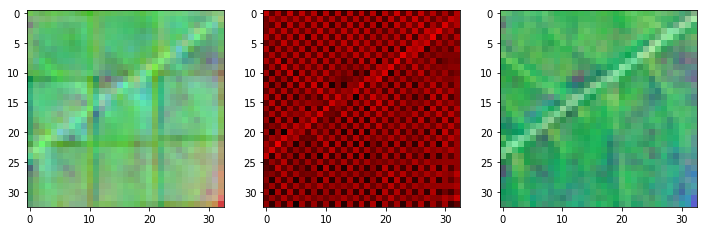

Epoch [1/250], Step [0/782], Loss: 0.09792491793632507
Epoch [1/250], Step [50/782], Loss: 0.08649307489395142
Epoch [1/250], Step [100/782], Loss: 0.09234807640314102
Epoch [1/250], Step [150/782], Loss: 0.07115571945905685
Epoch [1/250], Step [200/782], Loss: 0.07587383687496185
Epoch [1/250], Step [250/782], Loss: 0.06378873437643051
Epoch [1/250], Step [300/782], Loss: 0.05649681016802788
Epoch [1/250], Step [350/782], Loss: 0.10865333676338196
Epoch [1/250], Step [400/782], Loss: 0.08085626363754272
Epoch [1/250], Step [450/782], Loss: 0.06960441917181015
Epoch [1/250], Step [500/782], Loss: 0.07272925227880478
Epoch [1/250], Step [550/782], Loss: 0.06158636137843132
Epoch [1/250], Step [600/782], Loss: 0.07611004263162613
Epoch [1/250], Step [650/782], Loss: 0.05567028373479843
Epoch [1/250], Step [700/782], Loss: 0.06306690722703934
Epoch [1/250], Step [750/782], Loss: 0.06352114677429199


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 1, Loss --- mean: 0.07067779665979583, std 0.015317323716547347



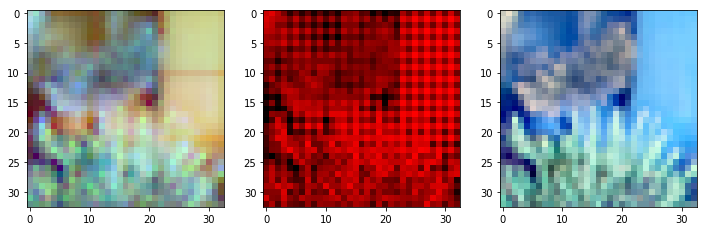

Epoch [2/250], Step [0/782], Loss: 0.06904350966215134
Epoch [2/250], Step [50/782], Loss: 0.07047352939844131
Epoch [2/250], Step [100/782], Loss: 0.05410143360495567
Epoch [2/250], Step [150/782], Loss: 0.08306139707565308
Epoch [2/250], Step [200/782], Loss: 0.07520455121994019
Epoch [2/250], Step [250/782], Loss: 0.07136129587888718
Epoch [2/250], Step [300/782], Loss: 0.05234436318278313
Epoch [2/250], Step [350/782], Loss: 0.06116466224193573
Epoch [2/250], Step [400/782], Loss: 0.0778045579791069
Epoch [2/250], Step [450/782], Loss: 0.0563301146030426
Epoch [2/250], Step [500/782], Loss: 0.07800620049238205
Epoch [2/250], Step [550/782], Loss: 0.051994688808918
Epoch [2/250], Step [600/782], Loss: 0.06601709127426147
Epoch [2/250], Step [650/782], Loss: 0.06788136810064316
Epoch [2/250], Step [700/782], Loss: 0.061451222747564316
Epoch [2/250], Step [750/782], Loss: 0.08646219223737717


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 2, Loss --- mean: 0.0654900743747535, std 0.0172855452194435



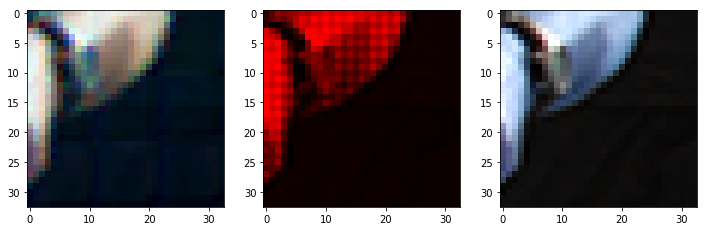

Epoch [3/250], Step [0/782], Loss: 0.060970619320869446
Epoch [3/250], Step [50/782], Loss: 0.07439879328012466
Epoch [3/250], Step [100/782], Loss: 0.06216564401984215
Epoch [3/250], Step [150/782], Loss: 0.06206098943948746
Epoch [3/250], Step [200/782], Loss: 0.07192598283290863
Epoch [3/250], Step [250/782], Loss: 0.05764618143439293
Epoch [3/250], Step [300/782], Loss: 0.05705857649445534
Epoch [3/250], Step [350/782], Loss: 0.057747434824705124
Epoch [3/250], Step [400/782], Loss: 0.05201839283108711
Epoch [3/250], Step [450/782], Loss: 0.06568283587694168
Epoch [3/250], Step [500/782], Loss: 0.05389034375548363
Epoch [3/250], Step [550/782], Loss: 0.05079827457666397
Epoch [3/250], Step [600/782], Loss: 0.059885174036026
Epoch [3/250], Step [650/782], Loss: 0.04826228320598602
Epoch [3/250], Step [700/782], Loss: 0.05226213112473488
Epoch [3/250], Step [750/782], Loss: 0.039007000625133514


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 3, Loss --- mean: 0.05661851887250571, std 0.009169421831434496



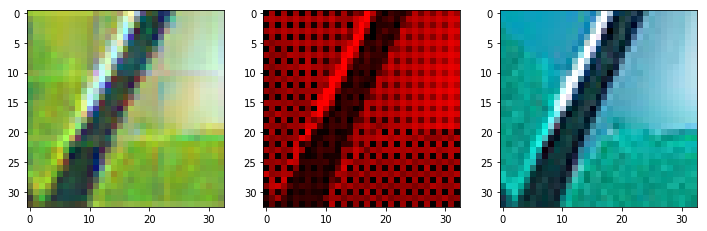

Epoch [4/250], Step [0/782], Loss: 0.05527453124523163
Epoch [4/250], Step [50/782], Loss: 0.04249260574579239
Epoch [4/250], Step [100/782], Loss: 0.04959214851260185
Epoch [4/250], Step [150/782], Loss: 0.032804593443870544
Epoch [4/250], Step [200/782], Loss: 0.04709845781326294
Epoch [4/250], Step [250/782], Loss: 0.054699093103408813
Epoch [4/250], Step [300/782], Loss: 0.04827193170785904
Epoch [4/250], Step [350/782], Loss: 0.06330596655607224
Epoch [4/250], Step [400/782], Loss: 0.06693118810653687
Epoch [4/250], Step [450/782], Loss: 0.05312648043036461
Epoch [4/250], Step [500/782], Loss: 0.04032764956355095
Epoch [4/250], Step [550/782], Loss: 0.0389898307621479
Epoch [4/250], Step [600/782], Loss: 0.04785601794719696
Epoch [4/250], Step [650/782], Loss: 0.04439501836895943
Epoch [4/250], Step [700/782], Loss: 0.048157915472984314
Epoch [4/250], Step [750/782], Loss: 0.045297399163246155


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 4, Loss --- mean: 0.050797990256506005, std 0.008546205054550839



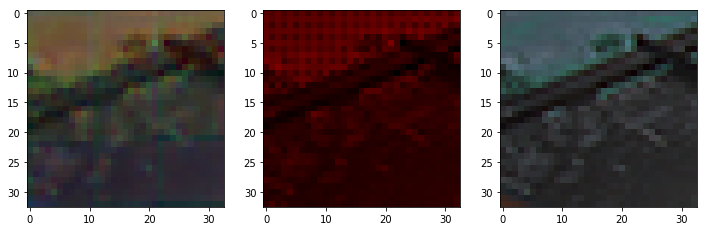

Epoch [5/250], Step [0/782], Loss: 0.06727228313684464
Epoch [5/250], Step [50/782], Loss: 0.04670577868819237
Epoch [5/250], Step [100/782], Loss: 0.039495643228292465
Epoch [5/250], Step [150/782], Loss: 0.04759865999221802
Epoch [5/250], Step [200/782], Loss: 0.05110803619027138
Epoch [5/250], Step [250/782], Loss: 0.0514676608145237
Epoch [5/250], Step [300/782], Loss: 0.03235171362757683
Epoch [5/250], Step [350/782], Loss: 0.07680916041135788
Epoch [5/250], Step [400/782], Loss: 0.06054056063294411
Epoch [5/250], Step [450/782], Loss: 0.04971477761864662
Epoch [5/250], Step [500/782], Loss: 0.04126393049955368
Epoch [5/250], Step [550/782], Loss: 0.055767711251974106
Epoch [5/250], Step [600/782], Loss: 0.035404663532972336
Epoch [5/250], Step [650/782], Loss: 0.03848106786608696
Epoch [5/250], Step [700/782], Loss: 0.0495491549372673
Epoch [5/250], Step [750/782], Loss: 0.04106689989566803

Finished Epoch 5, Loss --- mean: 0.05005944204157042, std 0.010801916527263472



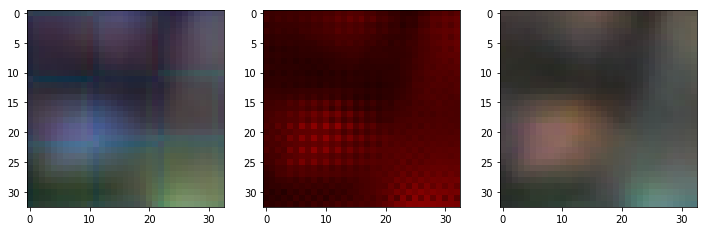

Epoch [6/250], Step [0/782], Loss: 0.034832682460546494
Epoch [6/250], Step [50/782], Loss: 0.049857914447784424
Epoch [6/250], Step [100/782], Loss: 0.0472475066781044
Epoch [6/250], Step [150/782], Loss: 0.04902520775794983
Epoch [6/250], Step [200/782], Loss: 0.04732823744416237
Epoch [6/250], Step [250/782], Loss: 0.04290035367012024
Epoch [6/250], Step [300/782], Loss: 0.04142565652728081
Epoch [6/250], Step [350/782], Loss: 0.044651616364717484
Epoch [6/250], Step [400/782], Loss: 0.04947461932897568
Epoch [6/250], Step [450/782], Loss: 0.04927310347557068
Epoch [6/250], Step [500/782], Loss: 0.050204984843730927
Epoch [6/250], Step [550/782], Loss: 0.05261512100696564
Epoch [6/250], Step [600/782], Loss: 0.04634394124150276
Epoch [6/250], Step [650/782], Loss: 0.03869381919503212
Epoch [6/250], Step [700/782], Loss: 0.03783413767814636
Epoch [6/250], Step [750/782], Loss: 0.050974924117326736

Finished Epoch 6, Loss --- mean: 0.04461727306827941, std 0.008329420315592343



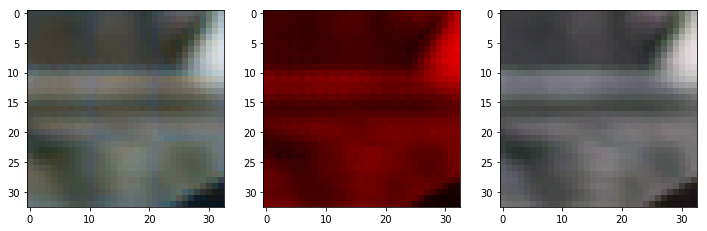

Epoch [7/250], Step [0/782], Loss: 0.05285850912332535
Epoch [7/250], Step [50/782], Loss: 0.0480525828897953
Epoch [7/250], Step [100/782], Loss: 0.04941466450691223
Epoch [7/250], Step [150/782], Loss: 0.045128390192985535
Epoch [7/250], Step [200/782], Loss: 0.03874948248267174
Epoch [7/250], Step [250/782], Loss: 0.05409707874059677
Epoch [7/250], Step [300/782], Loss: 0.05057907849550247
Epoch [7/250], Step [350/782], Loss: 0.03922901675105095
Epoch [7/250], Step [400/782], Loss: 0.037230852991342545
Epoch [7/250], Step [450/782], Loss: 0.031015144661068916
Epoch [7/250], Step [500/782], Loss: 0.033595312386751175
Epoch [7/250], Step [550/782], Loss: 0.03045503981411457
Epoch [7/250], Step [600/782], Loss: 0.03834942355751991
Epoch [7/250], Step [650/782], Loss: 0.04485168680548668
Epoch [7/250], Step [700/782], Loss: 0.04233613982796669
Epoch [7/250], Step [750/782], Loss: 0.050178200006484985


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 7, Loss --- mean: 0.043002154466117284, std 0.008142797526875759



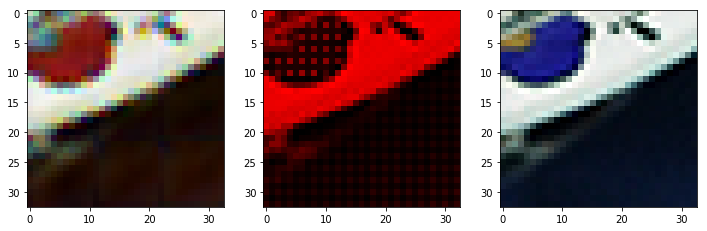

Epoch [8/250], Step [0/782], Loss: 0.05544894561171532
Epoch [8/250], Step [50/782], Loss: 0.04358229786157608
Epoch [8/250], Step [100/782], Loss: 0.04967516288161278
Epoch [8/250], Step [150/782], Loss: 0.048118993639945984
Epoch [8/250], Step [200/782], Loss: 0.04265427589416504
Epoch [8/250], Step [250/782], Loss: 0.035563334822654724
Epoch [8/250], Step [300/782], Loss: 0.04643853381276131
Epoch [8/250], Step [350/782], Loss: 0.043537966907024384
Epoch [8/250], Step [400/782], Loss: 0.03913986682891846
Epoch [8/250], Step [450/782], Loss: 0.040152739733457565
Epoch [8/250], Step [500/782], Loss: 0.04051082208752632
Epoch [8/250], Step [550/782], Loss: 0.04270414635539055
Epoch [8/250], Step [600/782], Loss: 0.04261639341711998
Epoch [8/250], Step [650/782], Loss: 0.05267300456762314
Epoch [8/250], Step [700/782], Loss: 0.0338108204305172
Epoch [8/250], Step [750/782], Loss: 0.04189623147249222

Finished Epoch 8, Loss --- mean: 0.04264351274684795, std 0.007803011453508357



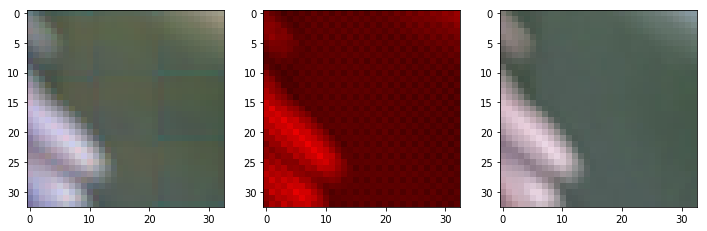

Epoch [9/250], Step [0/782], Loss: 0.05020981281995773
Epoch [9/250], Step [50/782], Loss: 0.03493198752403259
Epoch [9/250], Step [100/782], Loss: 0.04400074481964111
Epoch [9/250], Step [150/782], Loss: 0.05259276181459427
Epoch [9/250], Step [200/782], Loss: 0.030111225321888924
Epoch [9/250], Step [250/782], Loss: 0.054383426904678345
Epoch [9/250], Step [300/782], Loss: 0.04973549395799637
Epoch [9/250], Step [350/782], Loss: 0.04837927222251892
Epoch [9/250], Step [400/782], Loss: 0.032435305416584015
Epoch [9/250], Step [450/782], Loss: 0.035117149353027344
Epoch [9/250], Step [500/782], Loss: 0.04133889451622963
Epoch [9/250], Step [550/782], Loss: 0.0406729057431221
Epoch [9/250], Step [600/782], Loss: 0.037577465176582336
Epoch [9/250], Step [650/782], Loss: 0.047852370887994766
Epoch [9/250], Step [700/782], Loss: 0.033368419855833054
Epoch [9/250], Step [750/782], Loss: 0.0380345955491066

Finished Epoch 9, Loss --- mean: 0.04236289676126388, std 0.007602842165354736



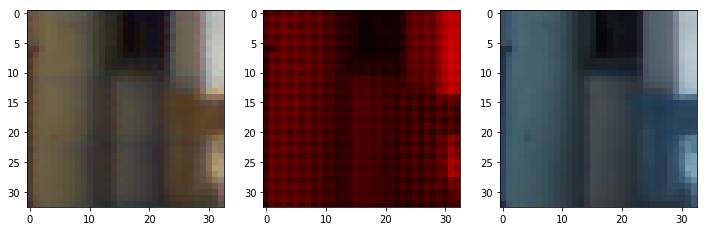

Epoch [10/250], Step [0/782], Loss: 0.045859791338443756
Epoch [10/250], Step [50/782], Loss: 0.04231441020965576
Epoch [10/250], Step [100/782], Loss: 0.05334632471203804
Epoch [10/250], Step [150/782], Loss: 0.035480182617902756
Epoch [10/250], Step [200/782], Loss: 0.05020029470324516
Epoch [10/250], Step [250/782], Loss: 0.05656878650188446
Epoch [10/250], Step [300/782], Loss: 0.036290112882852554
Epoch [10/250], Step [350/782], Loss: 0.04896098002791405
Epoch [10/250], Step [400/782], Loss: 0.04617343097925186
Epoch [10/250], Step [450/782], Loss: 0.03496978059411049
Epoch [10/250], Step [500/782], Loss: 0.05345943197607994
Epoch [10/250], Step [550/782], Loss: 0.04266486316919327
Epoch [10/250], Step [600/782], Loss: 0.0364471971988678
Epoch [10/250], Step [650/782], Loss: 0.0376068614423275
Epoch [10/250], Step [700/782], Loss: 0.04000328108668327
Epoch [10/250], Step [750/782], Loss: 0.04994140937924385

Finished Epoch 10, Loss --- mean: 0.04187196795888188, std 0.007796657619

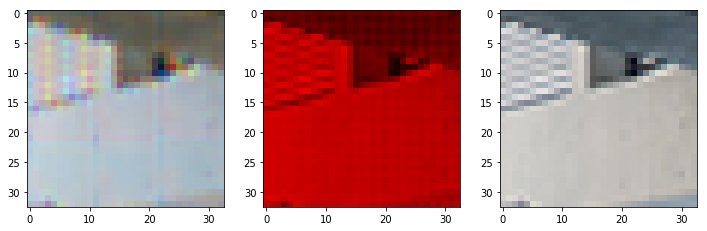

Epoch [11/250], Step [0/782], Loss: 0.02873978205025196
Epoch [11/250], Step [50/782], Loss: 0.043127480894327164
Epoch [11/250], Step [100/782], Loss: 0.04144363850355148
Epoch [11/250], Step [150/782], Loss: 0.04008784145116806
Epoch [11/250], Step [200/782], Loss: 0.03553968667984009
Epoch [11/250], Step [250/782], Loss: 0.042653996497392654
Epoch [11/250], Step [300/782], Loss: 0.03910154849290848
Epoch [11/250], Step [350/782], Loss: 0.02805769070982933
Epoch [11/250], Step [400/782], Loss: 0.03809551149606705
Epoch [11/250], Step [450/782], Loss: 0.04261954128742218
Epoch [11/250], Step [500/782], Loss: 0.03416416794061661
Epoch [11/250], Step [550/782], Loss: 0.031165514141321182
Epoch [11/250], Step [600/782], Loss: 0.03599678725004196
Epoch [11/250], Step [650/782], Loss: 0.03714685142040253
Epoch [11/250], Step [700/782], Loss: 0.027747776359319687
Epoch [11/250], Step [750/782], Loss: 0.046484481543302536


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 11, Loss --- mean: 0.04161767914291004, std 0.007863126481697125



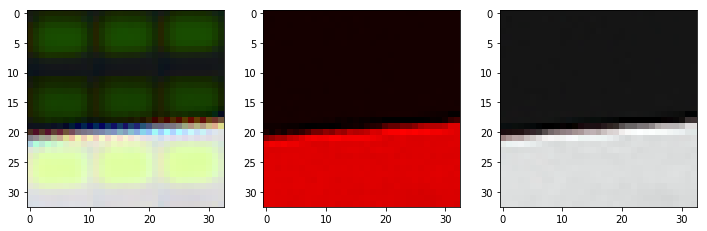

Epoch [12/250], Step [0/782], Loss: 0.04083549976348877
Epoch [12/250], Step [50/782], Loss: 0.033648885786533356
Epoch [12/250], Step [100/782], Loss: 0.04509647190570831
Epoch [12/250], Step [150/782], Loss: 0.030676795169711113
Epoch [12/250], Step [200/782], Loss: 0.0400192029774189
Epoch [12/250], Step [250/782], Loss: 0.05131208151578903
Epoch [12/250], Step [300/782], Loss: 0.035793453454971313
Epoch [12/250], Step [350/782], Loss: 0.04650223255157471
Epoch [12/250], Step [400/782], Loss: 0.033068183809518814
Epoch [12/250], Step [450/782], Loss: 0.03950235992670059
Epoch [12/250], Step [500/782], Loss: 0.03736204281449318
Epoch [12/250], Step [550/782], Loss: 0.06125364452600479
Epoch [12/250], Step [600/782], Loss: 0.046522799879312515
Epoch [12/250], Step [650/782], Loss: 0.029914293438196182
Epoch [12/250], Step [700/782], Loss: 0.05151360481977463
Epoch [12/250], Step [750/782], Loss: 0.06412463635206223


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 12, Loss --- mean: 0.041069302938954756, std 0.007836398710686065



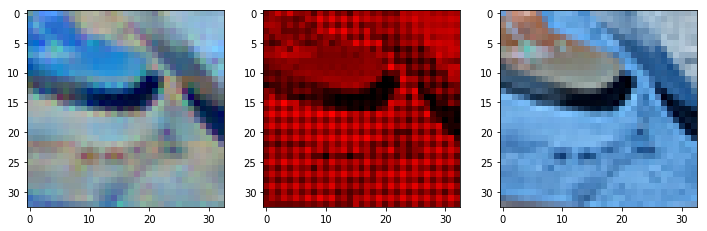

Epoch [13/250], Step [0/782], Loss: 0.05329587683081627
Epoch [13/250], Step [50/782], Loss: 0.03286273777484894
Epoch [13/250], Step [100/782], Loss: 0.028736647218465805
Epoch [13/250], Step [150/782], Loss: 0.054756175726652145
Epoch [13/250], Step [200/782], Loss: 0.039987485855817795
Epoch [13/250], Step [250/782], Loss: 0.034337978810071945
Epoch [13/250], Step [300/782], Loss: 0.058150772005319595
Epoch [13/250], Step [350/782], Loss: 0.04220793396234512
Epoch [13/250], Step [400/782], Loss: 0.036550842225551605
Epoch [13/250], Step [450/782], Loss: 0.04443223774433136
Epoch [13/250], Step [500/782], Loss: 0.03413785621523857
Epoch [13/250], Step [550/782], Loss: 0.03708084672689438
Epoch [13/250], Step [600/782], Loss: 0.045267630368471146
Epoch [13/250], Step [650/782], Loss: 0.03632598742842674
Epoch [13/250], Step [700/782], Loss: 0.03981509432196617
Epoch [13/250], Step [750/782], Loss: 0.038833510130643845


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 13, Loss --- mean: 0.040617442323023556, std 0.007929215702142885



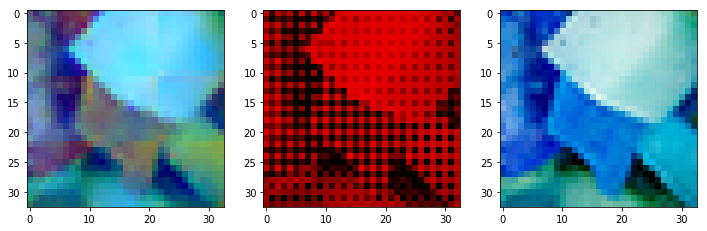

Epoch [14/250], Step [0/782], Loss: 0.05578920617699623
Epoch [14/250], Step [50/782], Loss: 0.03530498966574669
Epoch [14/250], Step [100/782], Loss: 0.03939296305179596
Epoch [14/250], Step [150/782], Loss: 0.04851236566901207
Epoch [14/250], Step [200/782], Loss: 0.04084226116538048
Epoch [14/250], Step [250/782], Loss: 0.037210144102573395
Epoch [14/250], Step [300/782], Loss: 0.03703450784087181
Epoch [14/250], Step [350/782], Loss: 0.03682510182261467
Epoch [14/250], Step [400/782], Loss: 0.03833353891968727
Epoch [14/250], Step [450/782], Loss: 0.03958556801080704
Epoch [14/250], Step [500/782], Loss: 0.04024166613817215
Epoch [14/250], Step [550/782], Loss: 0.03976376727223396
Epoch [14/250], Step [600/782], Loss: 0.04838124290108681
Epoch [14/250], Step [650/782], Loss: 0.02799997664988041
Epoch [14/250], Step [700/782], Loss: 0.03399926796555519
Epoch [14/250], Step [750/782], Loss: 0.03374768793582916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 14, Loss --- mean: 0.0402102050183298, std 0.007779797287026493



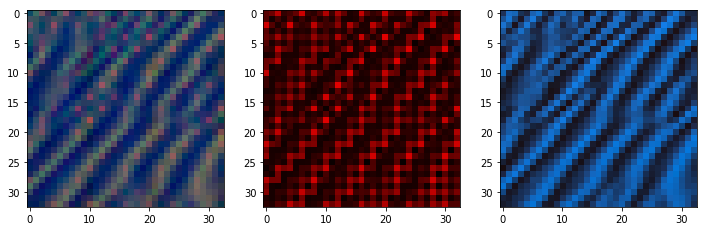

Epoch [15/250], Step [0/782], Loss: 0.04577165096998215
Epoch [15/250], Step [50/782], Loss: 0.037157364189624786
Epoch [15/250], Step [100/782], Loss: 0.03877924755215645
Epoch [15/250], Step [150/782], Loss: 0.0306209959089756
Epoch [15/250], Step [200/782], Loss: 0.03531359136104584
Epoch [15/250], Step [250/782], Loss: 0.03811674565076828
Epoch [15/250], Step [300/782], Loss: 0.05512690916657448
Epoch [15/250], Step [350/782], Loss: 0.05381549894809723
Epoch [15/250], Step [400/782], Loss: 0.037724051624536514
Epoch [15/250], Step [450/782], Loss: 0.030584974214434624
Epoch [15/250], Step [500/782], Loss: 0.042879149317741394
Epoch [15/250], Step [550/782], Loss: 0.03811311721801758
Epoch [15/250], Step [600/782], Loss: 0.034029968082904816
Epoch [15/250], Step [650/782], Loss: 0.03181711584329605
Epoch [15/250], Step [700/782], Loss: 0.041298165917396545
Epoch [15/250], Step [750/782], Loss: 0.041716501116752625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 15, Loss --- mean: 0.04001878093823295, std 0.007639854915450013



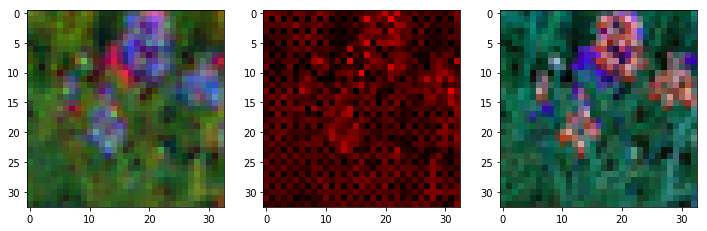

Epoch [16/250], Step [0/782], Loss: 0.033589933067560196
Epoch [16/250], Step [50/782], Loss: 0.045964013785123825
Epoch [16/250], Step [100/782], Loss: 0.036377616226673126
Epoch [16/250], Step [150/782], Loss: 0.04548594728112221
Epoch [16/250], Step [200/782], Loss: 0.05463776737451553
Epoch [16/250], Step [250/782], Loss: 0.03740868344902992
Epoch [16/250], Step [300/782], Loss: 0.045375850051641464
Epoch [16/250], Step [350/782], Loss: 0.042089760303497314
Epoch [16/250], Step [400/782], Loss: 0.03103148750960827
Epoch [16/250], Step [450/782], Loss: 0.05371063947677612
Epoch [16/250], Step [500/782], Loss: 0.04926571995019913
Epoch [16/250], Step [550/782], Loss: 0.0452895388007164
Epoch [16/250], Step [600/782], Loss: 0.030340343713760376
Epoch [16/250], Step [650/782], Loss: 0.0320388600230217
Epoch [16/250], Step [700/782], Loss: 0.04010331630706787
Epoch [16/250], Step [750/782], Loss: 0.03786173090338707


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 16, Loss --- mean: 0.03963872933488749, std 0.0077445695664860245



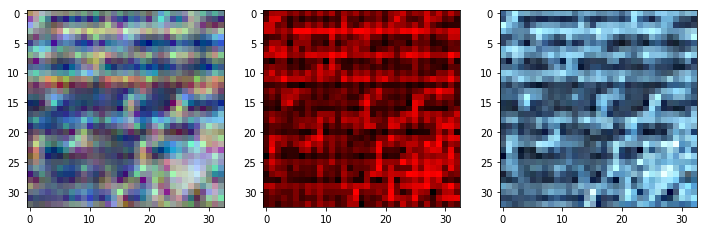

Epoch [17/250], Step [0/782], Loss: 0.04237192124128342
Epoch [17/250], Step [50/782], Loss: 0.05083521828055382
Epoch [17/250], Step [100/782], Loss: 0.02504708245396614
Epoch [17/250], Step [150/782], Loss: 0.042128708213567734
Epoch [17/250], Step [200/782], Loss: 0.038761287927627563
Epoch [17/250], Step [250/782], Loss: 0.05397610366344452
Epoch [17/250], Step [300/782], Loss: 0.03576209768652916
Epoch [17/250], Step [350/782], Loss: 0.03264353424310684
Epoch [17/250], Step [400/782], Loss: 0.03277245908975601
Epoch [17/250], Step [450/782], Loss: 0.045366402715444565
Epoch [17/250], Step [500/782], Loss: 0.030323849990963936
Epoch [17/250], Step [550/782], Loss: 0.02800924703478813
Epoch [17/250], Step [600/782], Loss: 0.03570479154586792
Epoch [17/250], Step [650/782], Loss: 0.03352336958050728
Epoch [17/250], Step [700/782], Loss: 0.04101736098527908
Epoch [17/250], Step [750/782], Loss: 0.043166399002075195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 17, Loss --- mean: 0.03935812144776058, std 0.007894154792162319



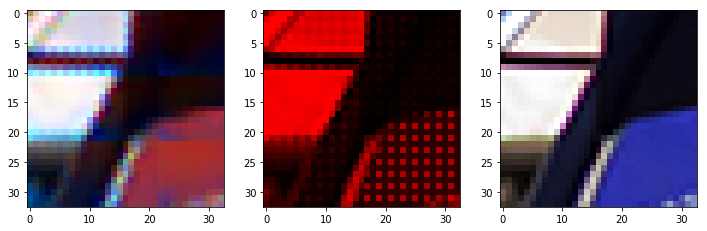

Epoch [18/250], Step [0/782], Loss: 0.03176611661911011
Epoch [18/250], Step [50/782], Loss: 0.04025840386748314
Epoch [18/250], Step [100/782], Loss: 0.033008407801389694
Epoch [18/250], Step [150/782], Loss: 0.04834924265742302
Epoch [18/250], Step [200/782], Loss: 0.044983938336372375
Epoch [18/250], Step [250/782], Loss: 0.0479370579123497
Epoch [18/250], Step [300/782], Loss: 0.031227748841047287
Epoch [18/250], Step [350/782], Loss: 0.05497903376817703
Epoch [18/250], Step [400/782], Loss: 0.044466353952884674
Epoch [18/250], Step [450/782], Loss: 0.03966992348432541
Epoch [18/250], Step [500/782], Loss: 0.029620205983519554
Epoch [18/250], Step [550/782], Loss: 0.04277278110384941
Epoch [18/250], Step [600/782], Loss: 0.0417616181075573
Epoch [18/250], Step [650/782], Loss: 0.03922193497419357
Epoch [18/250], Step [700/782], Loss: 0.025632042437791824
Epoch [18/250], Step [750/782], Loss: 0.044681135565042496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 18, Loss --- mean: 0.039377307595537446, std 0.007630122591152139



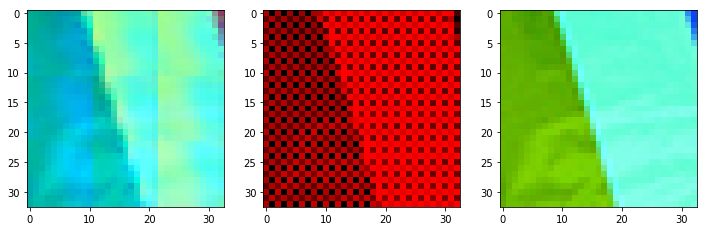

Epoch [19/250], Step [0/782], Loss: 0.033089615404605865
Epoch [19/250], Step [50/782], Loss: 0.03395988792181015
Epoch [19/250], Step [100/782], Loss: 0.03411759063601494
Epoch [19/250], Step [150/782], Loss: 0.03699260205030441
Epoch [19/250], Step [200/782], Loss: 0.051708489656448364
Epoch [19/250], Step [250/782], Loss: 0.034046947956085205
Epoch [19/250], Step [300/782], Loss: 0.04416150599718094
Epoch [19/250], Step [350/782], Loss: 0.047974228858947754
Epoch [19/250], Step [400/782], Loss: 0.035110726952552795
Epoch [19/250], Step [450/782], Loss: 0.03178570792078972
Epoch [19/250], Step [500/782], Loss: 0.043779779225587845
Epoch [19/250], Step [550/782], Loss: 0.037334442138671875
Epoch [19/250], Step [600/782], Loss: 0.03377601131796837
Epoch [19/250], Step [650/782], Loss: 0.03442377597093582
Epoch [19/250], Step [700/782], Loss: 0.043950121849775314
Epoch [19/250], Step [750/782], Loss: 0.034760620445013046


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 19, Loss --- mean: 0.0392212393762701, std 0.008011600237879281



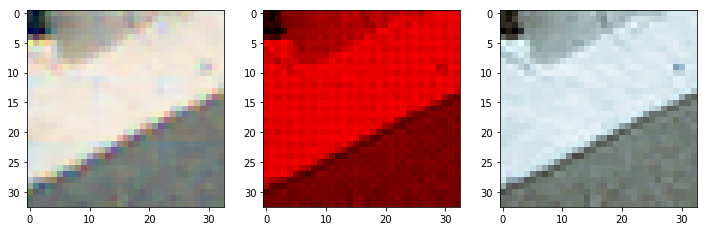

Epoch [20/250], Step [0/782], Loss: 0.03217035531997681
Epoch [20/250], Step [50/782], Loss: 0.04132639616727829
Epoch [20/250], Step [100/782], Loss: 0.04301074892282486
Epoch [20/250], Step [150/782], Loss: 0.03948132321238518
Epoch [20/250], Step [200/782], Loss: 0.03118865191936493
Epoch [20/250], Step [250/782], Loss: 0.025128059089183807
Epoch [20/250], Step [300/782], Loss: 0.03690451756119728
Epoch [20/250], Step [350/782], Loss: 0.044065456837415695
Epoch [20/250], Step [400/782], Loss: 0.031128879636526108
Epoch [20/250], Step [450/782], Loss: 0.04448290541768074
Epoch [20/250], Step [500/782], Loss: 0.035867106169462204
Epoch [20/250], Step [550/782], Loss: 0.03989621624350548
Epoch [20/250], Step [600/782], Loss: 0.04519683122634888
Epoch [20/250], Step [650/782], Loss: 0.0501311719417572
Epoch [20/250], Step [700/782], Loss: 0.030869996175169945
Epoch [20/250], Step [750/782], Loss: 0.04519863426685333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 20, Loss --- mean: 0.038998041916495696, std 0.007736321586200253



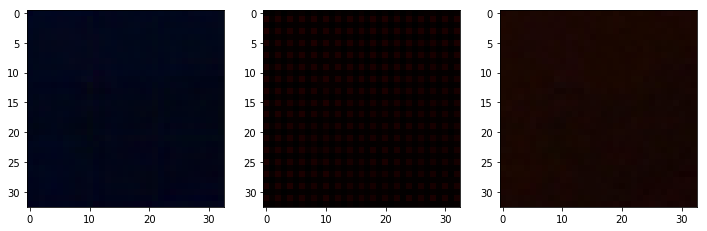

Epoch [21/250], Step [0/782], Loss: 0.033566977828741074
Epoch [21/250], Step [50/782], Loss: 0.02366507425904274
Epoch [21/250], Step [100/782], Loss: 0.03495709225535393
Epoch [21/250], Step [150/782], Loss: 0.04739057645201683
Epoch [21/250], Step [200/782], Loss: 0.03806287795305252
Epoch [21/250], Step [250/782], Loss: 0.04047589376568794
Epoch [21/250], Step [300/782], Loss: 0.041467878967523575
Epoch [21/250], Step [350/782], Loss: 0.032353948801755905
Epoch [21/250], Step [400/782], Loss: 0.028441598638892174
Epoch [21/250], Step [450/782], Loss: 0.029997000470757484
Epoch [21/250], Step [500/782], Loss: 0.04229828715324402
Epoch [21/250], Step [550/782], Loss: 0.030692823231220245
Epoch [21/250], Step [600/782], Loss: 0.03106972947716713
Epoch [21/250], Step [650/782], Loss: 0.04097028821706772
Epoch [21/250], Step [700/782], Loss: 0.04088500142097473
Epoch [21/250], Step [750/782], Loss: 0.03079143725335598


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 21, Loss --- mean: 0.03878871085422347, std 0.007629792915769168



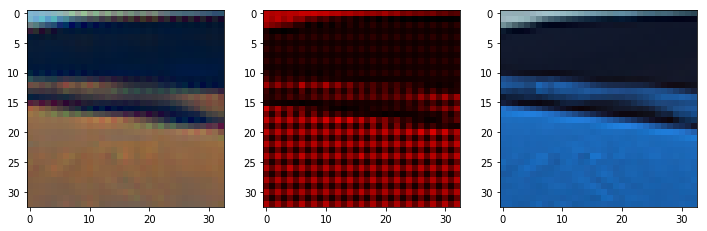

Epoch [22/250], Step [0/782], Loss: 0.03811822459101677
Epoch [22/250], Step [50/782], Loss: 0.04139380156993866
Epoch [22/250], Step [100/782], Loss: 0.042721375823020935
Epoch [22/250], Step [150/782], Loss: 0.028516985476017
Epoch [22/250], Step [200/782], Loss: 0.040835004299879074
Epoch [22/250], Step [250/782], Loss: 0.045065026730298996
Epoch [22/250], Step [300/782], Loss: 0.052895061671733856
Epoch [22/250], Step [350/782], Loss: 0.0432514026761055
Epoch [22/250], Step [400/782], Loss: 0.036426007747650146
Epoch [22/250], Step [450/782], Loss: 0.04741911217570305
Epoch [22/250], Step [500/782], Loss: 0.033638205379247665
Epoch [22/250], Step [550/782], Loss: 0.040962133556604385
Epoch [22/250], Step [600/782], Loss: 0.05522864684462547
Epoch [22/250], Step [650/782], Loss: 0.03989795595407486
Epoch [22/250], Step [700/782], Loss: 0.038266632705926895
Epoch [22/250], Step [750/782], Loss: 0.033445846289396286


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 22, Loss --- mean: 0.03858084465041185, std 0.0078008039315502365



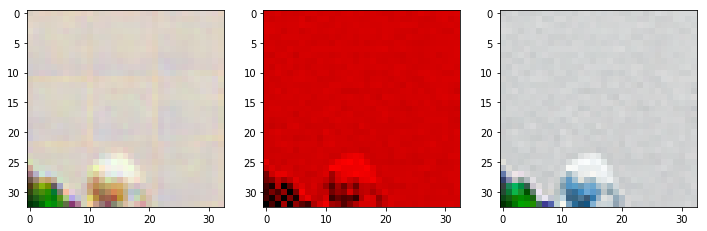

Epoch [23/250], Step [0/782], Loss: 0.02732853963971138
Epoch [23/250], Step [50/782], Loss: 0.03601003810763359
Epoch [23/250], Step [100/782], Loss: 0.05448798090219498
Epoch [23/250], Step [150/782], Loss: 0.04677931219339371
Epoch [23/250], Step [200/782], Loss: 0.03724495321512222
Epoch [23/250], Step [250/782], Loss: 0.04545319080352783
Epoch [23/250], Step [300/782], Loss: 0.059680379927158356
Epoch [23/250], Step [350/782], Loss: 0.036407094448804855
Epoch [23/250], Step [400/782], Loss: 0.03206561505794525
Epoch [23/250], Step [450/782], Loss: 0.045268211513757706
Epoch [23/250], Step [500/782], Loss: 0.034355491399765015
Epoch [23/250], Step [550/782], Loss: 0.033332716673612595
Epoch [23/250], Step [600/782], Loss: 0.054570987820625305
Epoch [23/250], Step [650/782], Loss: 0.031897757202386856
Epoch [23/250], Step [700/782], Loss: 0.043769076466560364
Epoch [23/250], Step [750/782], Loss: 0.04474543407559395

Finished Epoch 23, Loss --- mean: 0.03849298286649501, std 0.00765

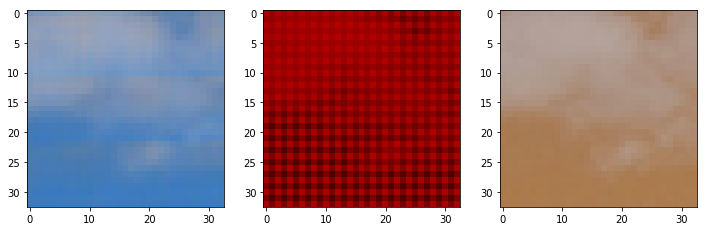

Epoch [24/250], Step [0/782], Loss: 0.03320060297846794
Epoch [24/250], Step [50/782], Loss: 0.0357137955725193
Epoch [24/250], Step [100/782], Loss: 0.04534224420785904
Epoch [24/250], Step [150/782], Loss: 0.03578748553991318
Epoch [24/250], Step [200/782], Loss: 0.061576422303915024
Epoch [24/250], Step [250/782], Loss: 0.045993417501449585
Epoch [24/250], Step [300/782], Loss: 0.04042969271540642
Epoch [24/250], Step [350/782], Loss: 0.03477557748556137
Epoch [24/250], Step [400/782], Loss: 0.052975088357925415
Epoch [24/250], Step [450/782], Loss: 0.0347890742123127
Epoch [24/250], Step [500/782], Loss: 0.02682044915854931
Epoch [24/250], Step [550/782], Loss: 0.03704259917140007
Epoch [24/250], Step [600/782], Loss: 0.03584294766187668
Epoch [24/250], Step [650/782], Loss: 0.04088635370135307
Epoch [24/250], Step [700/782], Loss: 0.03653092682361603
Epoch [24/250], Step [750/782], Loss: 0.044581059366464615


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 24, Loss --- mean: 0.03828255187415177, std 0.007923144795636808



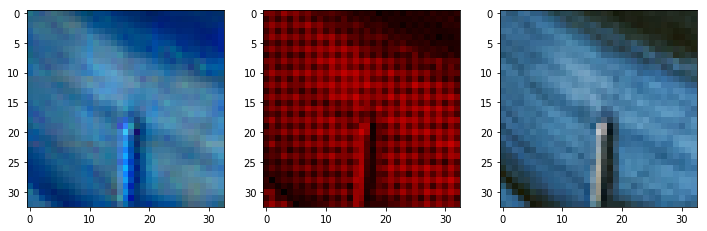

Epoch [25/250], Step [0/782], Loss: 0.02881958894431591
Epoch [25/250], Step [50/782], Loss: 0.02622123248875141
Epoch [25/250], Step [100/782], Loss: 0.05456369370222092
Epoch [25/250], Step [150/782], Loss: 0.02884327992796898
Epoch [25/250], Step [200/782], Loss: 0.04623773694038391
Epoch [25/250], Step [250/782], Loss: 0.053438734263181686
Epoch [25/250], Step [300/782], Loss: 0.040847521275281906
Epoch [25/250], Step [350/782], Loss: 0.04128929227590561
Epoch [25/250], Step [400/782], Loss: 0.04064616188406944
Epoch [25/250], Step [450/782], Loss: 0.04233163595199585
Epoch [25/250], Step [500/782], Loss: 0.03921292722225189
Epoch [25/250], Step [550/782], Loss: 0.047673434019088745
Epoch [25/250], Step [600/782], Loss: 0.029913779348134995
Epoch [25/250], Step [650/782], Loss: 0.038071345537900925
Epoch [25/250], Step [700/782], Loss: 0.044576775282621384
Epoch [25/250], Step [750/782], Loss: 0.04065863415598869


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 25, Loss --- mean: 0.03826957542087187, std 0.007632454707032793



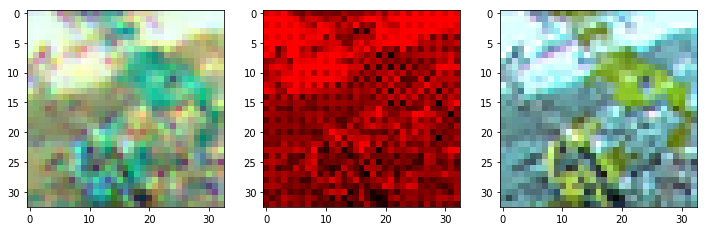

Epoch [26/250], Step [0/782], Loss: 0.026376739144325256
Epoch [26/250], Step [50/782], Loss: 0.027834072709083557
Epoch [26/250], Step [100/782], Loss: 0.04307249188423157
Epoch [26/250], Step [150/782], Loss: 0.039391953498125076
Epoch [26/250], Step [200/782], Loss: 0.052731335163116455
Epoch [26/250], Step [250/782], Loss: 0.03094288520514965
Epoch [26/250], Step [300/782], Loss: 0.05620571970939636
Epoch [26/250], Step [350/782], Loss: 0.044287871569395065
Epoch [26/250], Step [400/782], Loss: 0.04961536079645157
Epoch [26/250], Step [450/782], Loss: 0.04527644068002701
Epoch [26/250], Step [500/782], Loss: 0.035349395126104355
Epoch [26/250], Step [550/782], Loss: 0.03191067650914192
Epoch [26/250], Step [600/782], Loss: 0.04308181256055832
Epoch [26/250], Step [650/782], Loss: 0.03982893377542496
Epoch [26/250], Step [700/782], Loss: 0.033245425671339035
Epoch [26/250], Step [750/782], Loss: 0.04405061528086662


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 26, Loss --- mean: 0.03815168605359924, std 0.007530141796035565



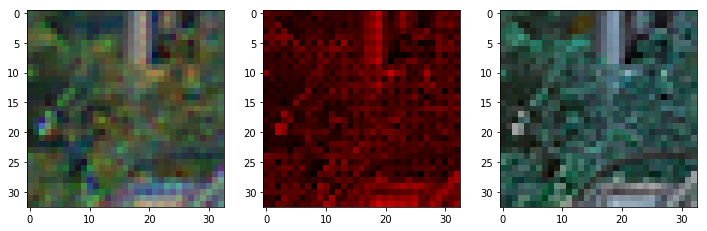

Epoch [27/250], Step [0/782], Loss: 0.031117407605051994
Epoch [27/250], Step [50/782], Loss: 0.04884950816631317
Epoch [27/250], Step [100/782], Loss: 0.04319388419389725
Epoch [27/250], Step [150/782], Loss: 0.03473931550979614
Epoch [27/250], Step [200/782], Loss: 0.04660342261195183
Epoch [27/250], Step [250/782], Loss: 0.03326423093676567
Epoch [27/250], Step [300/782], Loss: 0.03604132682085037
Epoch [27/250], Step [350/782], Loss: 0.03410385549068451
Epoch [27/250], Step [400/782], Loss: 0.039319101721048355
Epoch [27/250], Step [450/782], Loss: 0.024333186447620392
Epoch [27/250], Step [500/782], Loss: 0.0315106101334095
Epoch [27/250], Step [550/782], Loss: 0.0302731990814209
Epoch [27/250], Step [600/782], Loss: 0.03892039135098457
Epoch [27/250], Step [650/782], Loss: 0.028749901801347733
Epoch [27/250], Step [700/782], Loss: 0.03397684916853905
Epoch [27/250], Step [750/782], Loss: 0.029123656451702118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 27, Loss --- mean: 0.037911628449188016, std 0.0077574670689391475



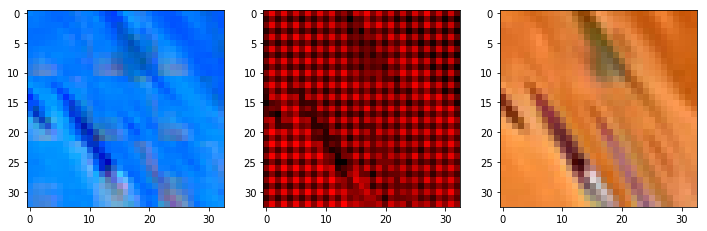

Epoch [28/250], Step [0/782], Loss: 0.04422552511096001
Epoch [28/250], Step [50/782], Loss: 0.03494715690612793
Epoch [28/250], Step [100/782], Loss: 0.04608521983027458
Epoch [28/250], Step [150/782], Loss: 0.030977752059698105
Epoch [28/250], Step [200/782], Loss: 0.03437802195549011
Epoch [28/250], Step [250/782], Loss: 0.03119785524904728
Epoch [28/250], Step [300/782], Loss: 0.0272343959659338
Epoch [28/250], Step [350/782], Loss: 0.03255968913435936
Epoch [28/250], Step [400/782], Loss: 0.04913957789540291
Epoch [28/250], Step [450/782], Loss: 0.0370546393096447
Epoch [28/250], Step [500/782], Loss: 0.032773684710264206
Epoch [28/250], Step [550/782], Loss: 0.0407957024872303
Epoch [28/250], Step [600/782], Loss: 0.03089245781302452
Epoch [28/250], Step [650/782], Loss: 0.03408410772681236
Epoch [28/250], Step [700/782], Loss: 0.034588199108839035
Epoch [28/250], Step [750/782], Loss: 0.03481990098953247

Finished Epoch 28, Loss --- mean: 0.037916576661302916, std 0.007204172651

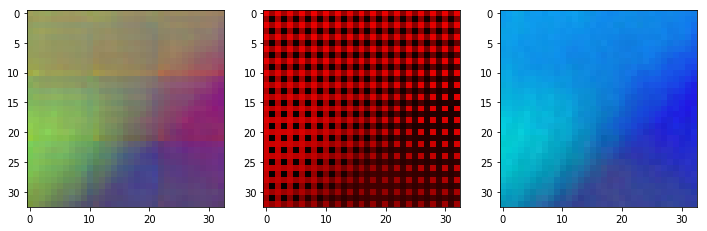

Epoch [29/250], Step [0/782], Loss: 0.03840753808617592
Epoch [29/250], Step [50/782], Loss: 0.03196719288825989
Epoch [29/250], Step [100/782], Loss: 0.033081572502851486
Epoch [29/250], Step [150/782], Loss: 0.037960492074489594
Epoch [29/250], Step [200/782], Loss: 0.03972414880990982
Epoch [29/250], Step [250/782], Loss: 0.033583253622055054
Epoch [29/250], Step [300/782], Loss: 0.02919168956577778
Epoch [29/250], Step [350/782], Loss: 0.04114411398768425
Epoch [29/250], Step [400/782], Loss: 0.030473319813609123
Epoch [29/250], Step [450/782], Loss: 0.059819355607032776
Epoch [29/250], Step [500/782], Loss: 0.03875437751412392
Epoch [29/250], Step [550/782], Loss: 0.04641100391745567
Epoch [29/250], Step [600/782], Loss: 0.038101717829704285
Epoch [29/250], Step [650/782], Loss: 0.03424781188368797
Epoch [29/250], Step [700/782], Loss: 0.03130818158388138
Epoch [29/250], Step [750/782], Loss: 0.03540292754769325

Finished Epoch 29, Loss --- mean: 0.03785022471547889, std 0.0075466

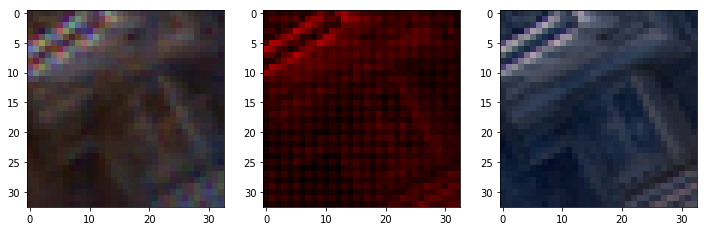

Epoch [30/250], Step [0/782], Loss: 0.0317886620759964
Epoch [30/250], Step [50/782], Loss: 0.036602847278118134
Epoch [30/250], Step [100/782], Loss: 0.053213126957416534
Epoch [30/250], Step [150/782], Loss: 0.032015953212976456
Epoch [30/250], Step [200/782], Loss: 0.03830579295754433
Epoch [30/250], Step [250/782], Loss: 0.04133092612028122
Epoch [30/250], Step [300/782], Loss: 0.03559322655200958
Epoch [30/250], Step [350/782], Loss: 0.03275077044963837
Epoch [30/250], Step [400/782], Loss: 0.057875338941812515
Epoch [30/250], Step [450/782], Loss: 0.03755098581314087
Epoch [30/250], Step [500/782], Loss: 0.030193710699677467
Epoch [30/250], Step [550/782], Loss: 0.038103505969047546
Epoch [30/250], Step [600/782], Loss: 0.028642801567912102
Epoch [30/250], Step [650/782], Loss: 0.043097175657749176
Epoch [30/250], Step [700/782], Loss: 0.0345400869846344
Epoch [30/250], Step [750/782], Loss: 0.034842684864997864


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 30, Loss --- mean: 0.03759209276951107, std 0.007819669933900127



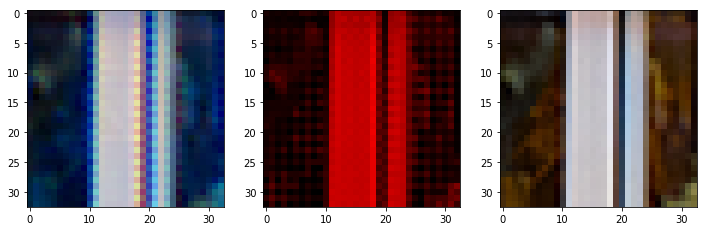

Epoch [31/250], Step [0/782], Loss: 0.039014700800180435
Epoch [31/250], Step [50/782], Loss: 0.04220343008637428
Epoch [31/250], Step [100/782], Loss: 0.04176380857825279
Epoch [31/250], Step [150/782], Loss: 0.032934822142124176
Epoch [31/250], Step [200/782], Loss: 0.04452250152826309
Epoch [31/250], Step [250/782], Loss: 0.051056019961833954
Epoch [31/250], Step [300/782], Loss: 0.04109283909201622
Epoch [31/250], Step [350/782], Loss: 0.042858466506004333
Epoch [31/250], Step [400/782], Loss: 0.027072660624980927
Epoch [31/250], Step [450/782], Loss: 0.038875602185726166
Epoch [31/250], Step [500/782], Loss: 0.0333232656121254
Epoch [31/250], Step [550/782], Loss: 0.05421462282538414
Epoch [31/250], Step [600/782], Loss: 0.03439890965819359
Epoch [31/250], Step [650/782], Loss: 0.031454551964998245
Epoch [31/250], Step [700/782], Loss: 0.026116114109754562
Epoch [31/250], Step [750/782], Loss: 0.031189389526844025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 31, Loss --- mean: 0.03750211332241059, std 0.007589037656104147



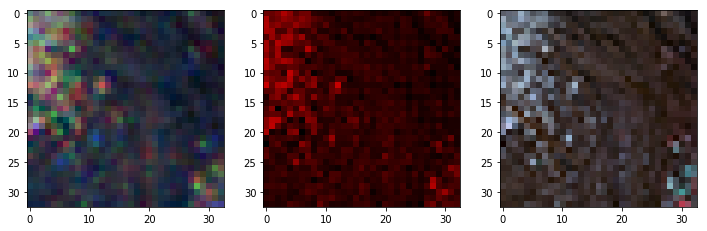

Epoch [32/250], Step [0/782], Loss: 0.04484696686267853
Epoch [32/250], Step [50/782], Loss: 0.06161767989397049
Epoch [32/250], Step [100/782], Loss: 0.060545776039361954
Epoch [32/250], Step [150/782], Loss: 0.0555175356566906
Epoch [32/250], Step [200/782], Loss: 0.05142906308174133
Epoch [32/250], Step [250/782], Loss: 0.04622273147106171
Epoch [32/250], Step [300/782], Loss: 0.043751396238803864
Epoch [32/250], Step [350/782], Loss: 0.03429844230413437
Epoch [32/250], Step [400/782], Loss: 0.036014143377542496
Epoch [32/250], Step [450/782], Loss: 0.030740845948457718
Epoch [32/250], Step [500/782], Loss: 0.027765536680817604
Epoch [32/250], Step [550/782], Loss: 0.02979045733809471
Epoch [32/250], Step [600/782], Loss: 0.03866633027791977
Epoch [32/250], Step [650/782], Loss: 0.028832413256168365
Epoch [32/250], Step [700/782], Loss: 0.03579871356487274
Epoch [32/250], Step [750/782], Loss: 0.05028269812464714


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 32, Loss --- mean: 0.0374495036628507, std 0.007948702824303742



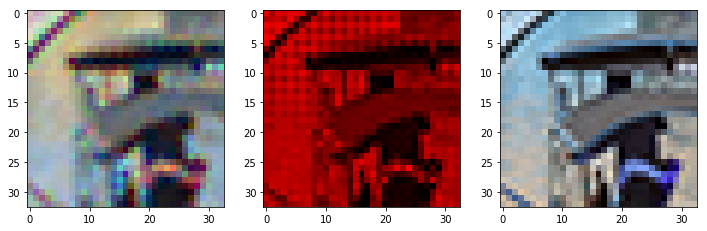

Epoch [33/250], Step [0/782], Loss: 0.03809070959687233
Epoch [33/250], Step [50/782], Loss: 0.02315787971019745
Epoch [33/250], Step [100/782], Loss: 0.04571942985057831
Epoch [33/250], Step [150/782], Loss: 0.05625739321112633
Epoch [33/250], Step [200/782], Loss: 0.043940212577581406
Epoch [33/250], Step [250/782], Loss: 0.04170747846364975
Epoch [33/250], Step [300/782], Loss: 0.03749031573534012
Epoch [33/250], Step [350/782], Loss: 0.044037654995918274
Epoch [33/250], Step [400/782], Loss: 0.04316689446568489
Epoch [33/250], Step [450/782], Loss: 0.03368576988577843
Epoch [33/250], Step [500/782], Loss: 0.03494532033801079
Epoch [33/250], Step [550/782], Loss: 0.03225473687052727
Epoch [33/250], Step [600/782], Loss: 0.0502372570335865
Epoch [33/250], Step [650/782], Loss: 0.025893941521644592
Epoch [33/250], Step [700/782], Loss: 0.035291846841573715
Epoch [33/250], Step [750/782], Loss: 0.03780063986778259


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 33, Loss --- mean: 0.03736653413785541, std 0.007381087765292805



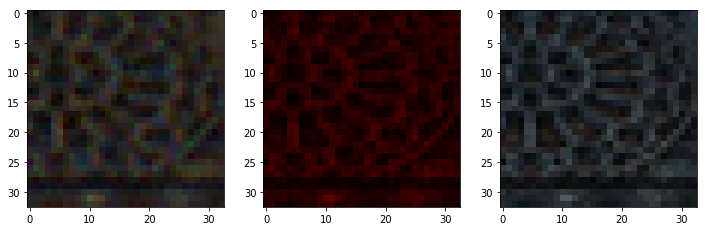

Epoch [34/250], Step [0/782], Loss: 0.028097819536924362
Epoch [34/250], Step [50/782], Loss: 0.0355524905025959
Epoch [34/250], Step [100/782], Loss: 0.038870297372341156
Epoch [34/250], Step [150/782], Loss: 0.035733550786972046
Epoch [34/250], Step [200/782], Loss: 0.03665269911289215
Epoch [34/250], Step [250/782], Loss: 0.06072745844721794
Epoch [34/250], Step [300/782], Loss: 0.04126207157969475
Epoch [34/250], Step [350/782], Loss: 0.028247978538274765
Epoch [34/250], Step [400/782], Loss: 0.03530237451195717
Epoch [34/250], Step [450/782], Loss: 0.04019416496157646
Epoch [34/250], Step [500/782], Loss: 0.0434124730527401
Epoch [34/250], Step [550/782], Loss: 0.04311566799879074
Epoch [34/250], Step [600/782], Loss: 0.03864153474569321
Epoch [34/250], Step [650/782], Loss: 0.03796618804335594
Epoch [34/250], Step [700/782], Loss: 0.0416904054582119
Epoch [34/250], Step [750/782], Loss: 0.027434565126895905


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 34, Loss --- mean: 0.03707172092802994, std 0.007373791066575419



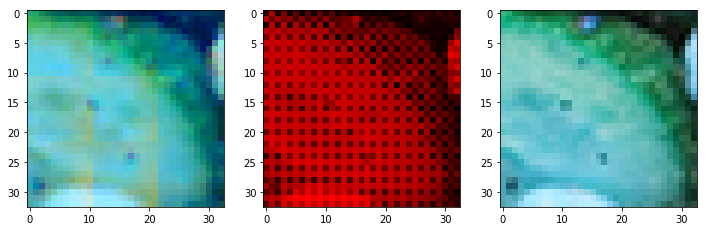

Epoch [35/250], Step [0/782], Loss: 0.03832448646426201
Epoch [35/250], Step [50/782], Loss: 0.03775571286678314
Epoch [35/250], Step [100/782], Loss: 0.03739093244075775
Epoch [35/250], Step [150/782], Loss: 0.049948565661907196
Epoch [35/250], Step [200/782], Loss: 0.03812405467033386
Epoch [35/250], Step [250/782], Loss: 0.03427191823720932
Epoch [35/250], Step [300/782], Loss: 0.034657422453165054
Epoch [35/250], Step [350/782], Loss: 0.03361387178301811
Epoch [35/250], Step [400/782], Loss: 0.032506104558706284
Epoch [35/250], Step [450/782], Loss: 0.03842531517148018
Epoch [35/250], Step [500/782], Loss: 0.025789018720388412
Epoch [35/250], Step [550/782], Loss: 0.036278512328863144
Epoch [35/250], Step [600/782], Loss: 0.03281185030937195
Epoch [35/250], Step [650/782], Loss: 0.03123663365840912
Epoch [35/250], Step [700/782], Loss: 0.04417760670185089
Epoch [35/250], Step [750/782], Loss: 0.04297933354973793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 35, Loss --- mean: 0.037015122892644706, std 0.0074908071750514095



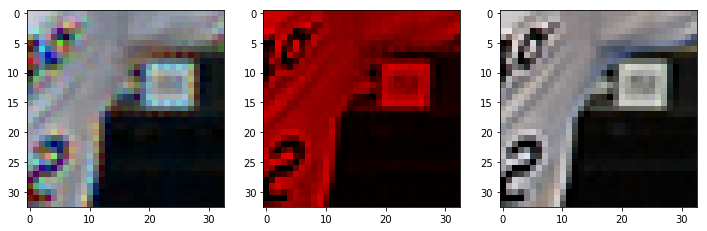

Epoch [36/250], Step [0/782], Loss: 0.045610975474119186
Epoch [36/250], Step [50/782], Loss: 0.03399963676929474
Epoch [36/250], Step [100/782], Loss: 0.0381891243159771
Epoch [36/250], Step [150/782], Loss: 0.03565104305744171
Epoch [36/250], Step [200/782], Loss: 0.030717995017766953
Epoch [36/250], Step [250/782], Loss: 0.032136667519807816
Epoch [36/250], Step [300/782], Loss: 0.0376625619828701
Epoch [36/250], Step [350/782], Loss: 0.02702920325100422
Epoch [36/250], Step [400/782], Loss: 0.03044554404914379
Epoch [36/250], Step [450/782], Loss: 0.03259680047631264
Epoch [36/250], Step [500/782], Loss: 0.04055028408765793
Epoch [36/250], Step [550/782], Loss: 0.031163685023784637
Epoch [36/250], Step [600/782], Loss: 0.034625716507434845
Epoch [36/250], Step [650/782], Loss: 0.04193080589175224
Epoch [36/250], Step [700/782], Loss: 0.039333608001470566
Epoch [36/250], Step [750/782], Loss: 0.046074897050857544


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 36, Loss --- mean: 0.036694904239109864, std 0.007437946816015017



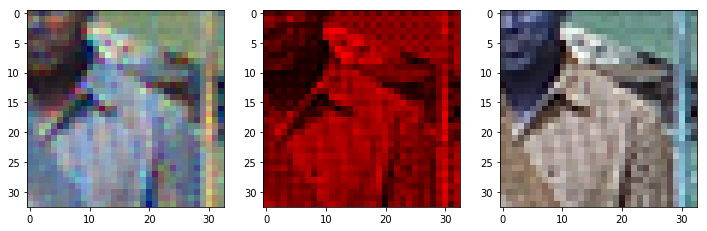

Epoch [37/250], Step [0/782], Loss: 0.04329654946923256
Epoch [37/250], Step [50/782], Loss: 0.029207641258835793
Epoch [37/250], Step [100/782], Loss: 0.04079756885766983
Epoch [37/250], Step [150/782], Loss: 0.05138029903173447
Epoch [37/250], Step [200/782], Loss: 0.03586062416434288
Epoch [37/250], Step [250/782], Loss: 0.03216084837913513
Epoch [37/250], Step [300/782], Loss: 0.028966300189495087
Epoch [37/250], Step [350/782], Loss: 0.03171960264444351
Epoch [37/250], Step [400/782], Loss: 0.0408175028860569
Epoch [37/250], Step [450/782], Loss: 0.049312736839056015
Epoch [37/250], Step [500/782], Loss: 0.043062109500169754
Epoch [37/250], Step [550/782], Loss: 0.034665193408727646
Epoch [37/250], Step [600/782], Loss: 0.037292804569005966
Epoch [37/250], Step [650/782], Loss: 0.04652351513504982
Epoch [37/250], Step [700/782], Loss: 0.03206087276339531
Epoch [37/250], Step [750/782], Loss: 0.03517642617225647

Finished Epoch 37, Loss --- mean: 0.03651972449220279, std 0.00755438

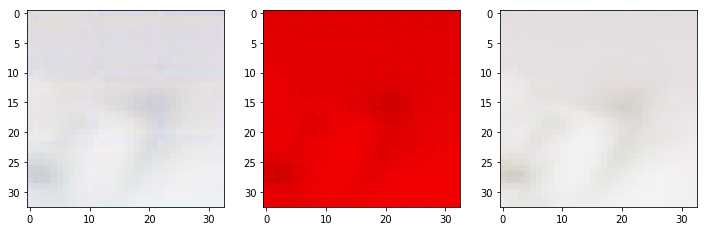

Epoch [38/250], Step [0/782], Loss: 0.028752019628882408
Epoch [38/250], Step [50/782], Loss: 0.0488508939743042
Epoch [38/250], Step [100/782], Loss: 0.028894882649183273
Epoch [38/250], Step [150/782], Loss: 0.03294753655791283
Epoch [38/250], Step [200/782], Loss: 0.04048720374703407
Epoch [38/250], Step [250/782], Loss: 0.03563663363456726
Epoch [38/250], Step [300/782], Loss: 0.03772442415356636
Epoch [38/250], Step [350/782], Loss: 0.03471355512738228
Epoch [38/250], Step [400/782], Loss: 0.03291552513837814
Epoch [38/250], Step [450/782], Loss: 0.028491150587797165
Epoch [38/250], Step [500/782], Loss: 0.034242838621139526
Epoch [38/250], Step [550/782], Loss: 0.022137153893709183
Epoch [38/250], Step [600/782], Loss: 0.03380415588617325
Epoch [38/250], Step [650/782], Loss: 0.037686653435230255
Epoch [38/250], Step [700/782], Loss: 0.030398137867450714
Epoch [38/250], Step [750/782], Loss: 0.03799954056739807

Finished Epoch 38, Loss --- mean: 0.0363577072439558, std 0.00741591

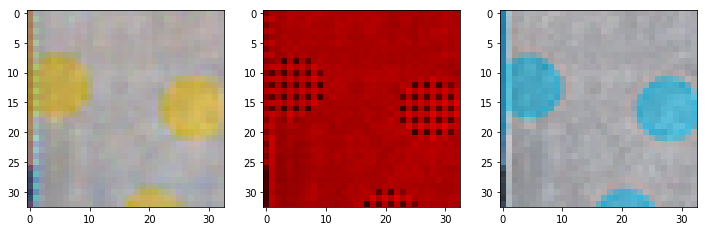

Epoch [39/250], Step [0/782], Loss: 0.039827678352594376
Epoch [39/250], Step [50/782], Loss: 0.03587852790951729
Epoch [39/250], Step [100/782], Loss: 0.030200116336345673
Epoch [39/250], Step [150/782], Loss: 0.040439900010824203
Epoch [39/250], Step [200/782], Loss: 0.043571796268224716
Epoch [39/250], Step [250/782], Loss: 0.028133876621723175
Epoch [39/250], Step [300/782], Loss: 0.029101958498358727
Epoch [39/250], Step [350/782], Loss: 0.03739750012755394
Epoch [39/250], Step [400/782], Loss: 0.040824469178915024
Epoch [39/250], Step [450/782], Loss: 0.04459568113088608
Epoch [39/250], Step [500/782], Loss: 0.020892532542347908
Epoch [39/250], Step [550/782], Loss: 0.031619925051927567
Epoch [39/250], Step [600/782], Loss: 0.0337732769548893
Epoch [39/250], Step [650/782], Loss: 0.02799374796450138
Epoch [39/250], Step [700/782], Loss: 0.03109978698194027
Epoch [39/250], Step [750/782], Loss: 0.03866085410118103


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 39, Loss --- mean: 0.035851652314767356, std 0.007465652161328929



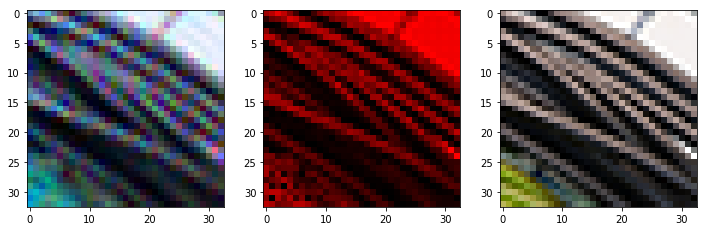

Epoch [40/250], Step [0/782], Loss: 0.04824664816260338
Epoch [40/250], Step [50/782], Loss: 0.03566862642765045
Epoch [40/250], Step [100/782], Loss: 0.02736557088792324
Epoch [40/250], Step [150/782], Loss: 0.023258013650774956
Epoch [40/250], Step [200/782], Loss: 0.02854073792695999
Epoch [40/250], Step [250/782], Loss: 0.04812696948647499
Epoch [40/250], Step [300/782], Loss: 0.030851999297738075
Epoch [40/250], Step [350/782], Loss: 0.028687676414847374
Epoch [40/250], Step [400/782], Loss: 0.0351509265601635
Epoch [40/250], Step [450/782], Loss: 0.0437735989689827
Epoch [40/250], Step [500/782], Loss: 0.0348571352660656
Epoch [40/250], Step [550/782], Loss: 0.04516644403338432
Epoch [40/250], Step [600/782], Loss: 0.036191675812006
Epoch [40/250], Step [650/782], Loss: 0.04289236664772034
Epoch [40/250], Step [700/782], Loss: 0.045909665524959564
Epoch [40/250], Step [750/782], Loss: 0.03793089836835861


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 40, Loss --- mean: 0.03557725722337013, std 0.007437571914319433



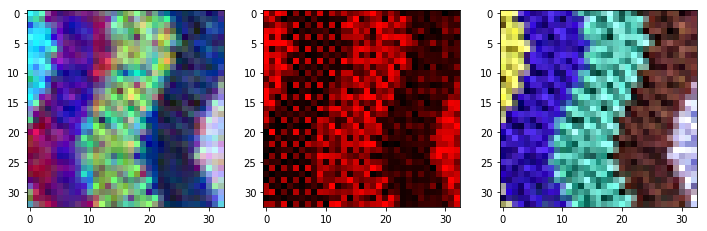

Epoch [41/250], Step [0/782], Loss: 0.04275977239012718
Epoch [41/250], Step [50/782], Loss: 0.032268986105918884
Epoch [41/250], Step [100/782], Loss: 0.03347347676753998
Epoch [41/250], Step [150/782], Loss: 0.04803219437599182
Epoch [41/250], Step [200/782], Loss: 0.029012145474553108
Epoch [41/250], Step [250/782], Loss: 0.024526141583919525
Epoch [41/250], Step [300/782], Loss: 0.0540231317281723
Epoch [41/250], Step [350/782], Loss: 0.04150088503956795
Epoch [41/250], Step [400/782], Loss: 0.02342872880399227
Epoch [41/250], Step [450/782], Loss: 0.04531945288181305
Epoch [41/250], Step [500/782], Loss: 0.03635485842823982
Epoch [41/250], Step [550/782], Loss: 0.04825878515839577
Epoch [41/250], Step [600/782], Loss: 0.021813081577420235
Epoch [41/250], Step [650/782], Loss: 0.04043443128466606
Epoch [41/250], Step [700/782], Loss: 0.0340229794383049
Epoch [41/250], Step [750/782], Loss: 0.042414162307977676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 41, Loss --- mean: 0.035371705013162946, std 0.007471869480917984



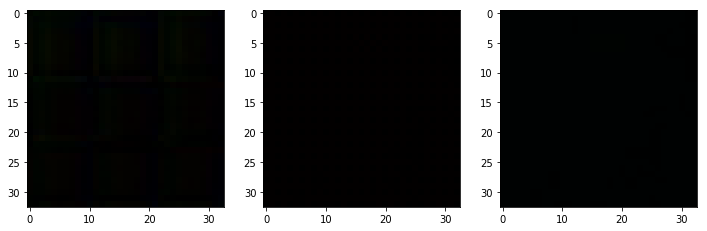

Epoch [42/250], Step [0/782], Loss: 0.03197496384382248
Epoch [42/250], Step [50/782], Loss: 0.038596201688051224
Epoch [42/250], Step [100/782], Loss: 0.02285396307706833
Epoch [42/250], Step [150/782], Loss: 0.05045374855399132
Epoch [42/250], Step [200/782], Loss: 0.03244099020957947
Epoch [42/250], Step [250/782], Loss: 0.027015522122383118
Epoch [42/250], Step [300/782], Loss: 0.04094995558261871
Epoch [42/250], Step [350/782], Loss: 0.03614891692996025
Epoch [42/250], Step [400/782], Loss: 0.032985154539346695
Epoch [42/250], Step [450/782], Loss: 0.03658709302544594
Epoch [42/250], Step [500/782], Loss: 0.03814207389950752
Epoch [42/250], Step [550/782], Loss: 0.02600931189954281
Epoch [42/250], Step [600/782], Loss: 0.03231308236718178
Epoch [42/250], Step [650/782], Loss: 0.024735284969210625
Epoch [42/250], Step [700/782], Loss: 0.02459963783621788
Epoch [42/250], Step [750/782], Loss: 0.041101448237895966


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 42, Loss --- mean: 0.03517960793460193, std 0.007656528759413239



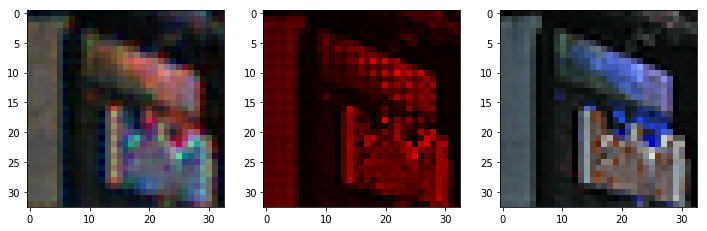

Epoch [43/250], Step [0/782], Loss: 0.026872124522924423
Epoch [43/250], Step [50/782], Loss: 0.028376620262861252
Epoch [43/250], Step [100/782], Loss: 0.04688262194395065
Epoch [43/250], Step [150/782], Loss: 0.0372919887304306
Epoch [43/250], Step [200/782], Loss: 0.030334295704960823
Epoch [43/250], Step [250/782], Loss: 0.041290249675512314
Epoch [43/250], Step [300/782], Loss: 0.039404015988111496
Epoch [43/250], Step [350/782], Loss: 0.040053196251392365
Epoch [43/250], Step [400/782], Loss: 0.033614713698625565
Epoch [43/250], Step [450/782], Loss: 0.03028903342783451
Epoch [43/250], Step [500/782], Loss: 0.029277419671416283
Epoch [43/250], Step [550/782], Loss: 0.040660567581653595
Epoch [43/250], Step [600/782], Loss: 0.03322102874517441
Epoch [43/250], Step [650/782], Loss: 0.030990077182650566
Epoch [43/250], Step [700/782], Loss: 0.04483753442764282
Epoch [43/250], Step [750/782], Loss: 0.029557619243860245


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 43, Loss --- mean: 0.03486042458902273, std 0.007163923387366204



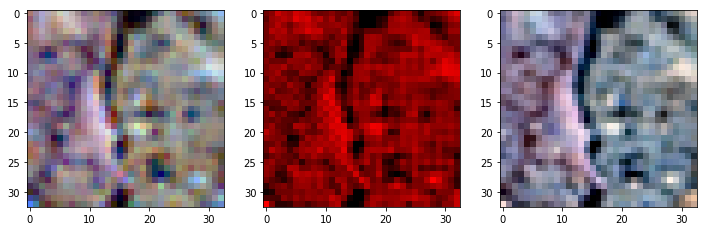

Epoch [44/250], Step [0/782], Loss: 0.039146628230810165
Epoch [44/250], Step [50/782], Loss: 0.034322403371334076
Epoch [44/250], Step [100/782], Loss: 0.02908075973391533
Epoch [44/250], Step [150/782], Loss: 0.041477009654045105
Epoch [44/250], Step [200/782], Loss: 0.032655019313097
Epoch [44/250], Step [250/782], Loss: 0.022127028554677963
Epoch [44/250], Step [300/782], Loss: 0.03715943545103073
Epoch [44/250], Step [350/782], Loss: 0.033338822424411774
Epoch [44/250], Step [400/782], Loss: 0.0288385096937418
Epoch [44/250], Step [450/782], Loss: 0.05701367184519768
Epoch [44/250], Step [500/782], Loss: 0.03792394697666168
Epoch [44/250], Step [550/782], Loss: 0.04127171263098717
Epoch [44/250], Step [600/782], Loss: 0.038666851818561554
Epoch [44/250], Step [650/782], Loss: 0.0510740764439106
Epoch [44/250], Step [700/782], Loss: 0.038220472633838654
Epoch [44/250], Step [750/782], Loss: 0.02934371307492256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 44, Loss --- mean: 0.03463079641475473, std 0.007463290557462925



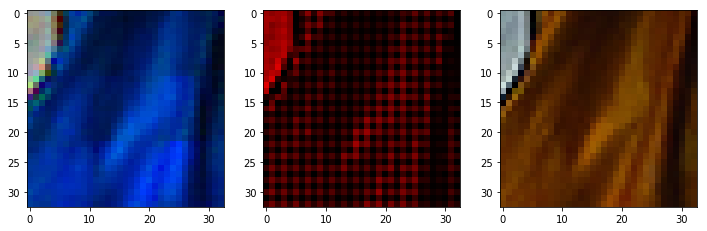

Epoch [45/250], Step [0/782], Loss: 0.02880902774631977
Epoch [45/250], Step [50/782], Loss: 0.024379823356866837
Epoch [45/250], Step [100/782], Loss: 0.031086010858416557
Epoch [45/250], Step [150/782], Loss: 0.03152124956250191
Epoch [45/250], Step [200/782], Loss: 0.02786468341946602
Epoch [45/250], Step [250/782], Loss: 0.03769306465983391
Epoch [45/250], Step [300/782], Loss: 0.02950183115899563
Epoch [45/250], Step [350/782], Loss: 0.03310353308916092
Epoch [45/250], Step [400/782], Loss: 0.029569268226623535
Epoch [45/250], Step [450/782], Loss: 0.03189406916499138
Epoch [45/250], Step [500/782], Loss: 0.03627370670437813
Epoch [45/250], Step [550/782], Loss: 0.029298778623342514
Epoch [45/250], Step [600/782], Loss: 0.03516659885644913
Epoch [45/250], Step [650/782], Loss: 0.030655402690172195
Epoch [45/250], Step [700/782], Loss: 0.024556342512369156
Epoch [45/250], Step [750/782], Loss: 0.023431943729519844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 45, Loss --- mean: 0.03427599588899737, std 0.007083362761403098



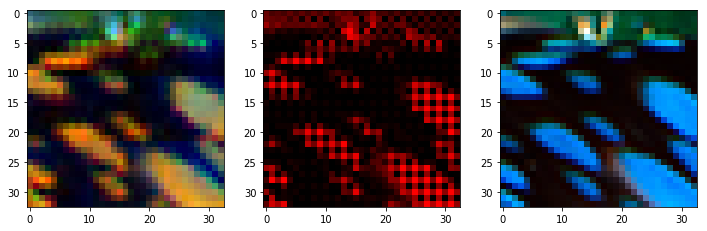

Epoch [46/250], Step [0/782], Loss: 0.035314105451107025
Epoch [46/250], Step [50/782], Loss: 0.03514773026108742
Epoch [46/250], Step [100/782], Loss: 0.02318829484283924
Epoch [46/250], Step [150/782], Loss: 0.026084642857313156
Epoch [46/250], Step [200/782], Loss: 0.038538698107004166
Epoch [46/250], Step [250/782], Loss: 0.02897465229034424
Epoch [46/250], Step [300/782], Loss: 0.029627589508891106
Epoch [46/250], Step [350/782], Loss: 0.03272171691060066
Epoch [46/250], Step [400/782], Loss: 0.026582753285765648
Epoch [46/250], Step [450/782], Loss: 0.03086438775062561
Epoch [46/250], Step [500/782], Loss: 0.06721024215221405
Epoch [46/250], Step [550/782], Loss: 0.03366340696811676
Epoch [46/250], Step [600/782], Loss: 0.04702872782945633
Epoch [46/250], Step [650/782], Loss: 0.06725544482469559
Epoch [46/250], Step [700/782], Loss: 0.034965869039297104
Epoch [46/250], Step [750/782], Loss: 0.03963804244995117

Finished Epoch 46, Loss --- mean: 0.034059261000426985, std 0.007052

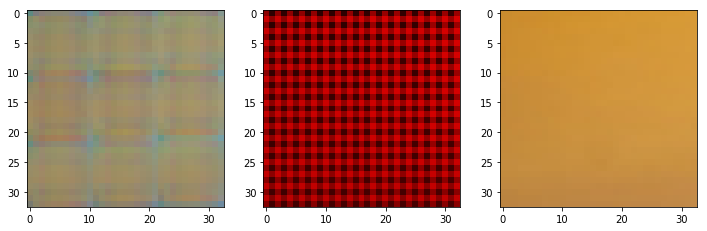

Epoch [47/250], Step [0/782], Loss: 0.040083371102809906
Epoch [47/250], Step [50/782], Loss: 0.03965889662504196
Epoch [47/250], Step [100/782], Loss: 0.031450167298316956
Epoch [47/250], Step [150/782], Loss: 0.021821847185492516
Epoch [47/250], Step [200/782], Loss: 0.029291149228811264
Epoch [47/250], Step [250/782], Loss: 0.029368789866566658
Epoch [47/250], Step [300/782], Loss: 0.030852491036057472
Epoch [47/250], Step [350/782], Loss: 0.0319976843893528
Epoch [47/250], Step [400/782], Loss: 0.02547561377286911
Epoch [47/250], Step [450/782], Loss: 0.03625751659274101
Epoch [47/250], Step [500/782], Loss: 0.033019471913576126
Epoch [47/250], Step [550/782], Loss: 0.03514120355248451
Epoch [47/250], Step [600/782], Loss: 0.050428252667188644
Epoch [47/250], Step [650/782], Loss: 0.030542809516191483
Epoch [47/250], Step [700/782], Loss: 0.03683948889374733
Epoch [47/250], Step [750/782], Loss: 0.026139086112380028


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 47, Loss --- mean: 0.03385218843112669, std 0.007127952412285056



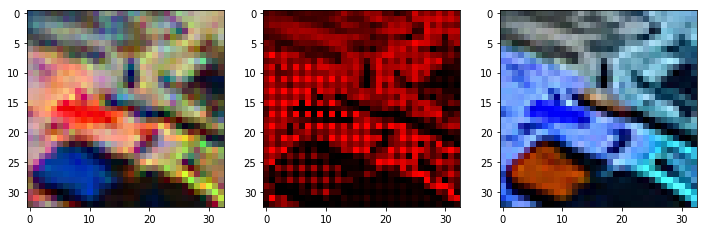

Epoch [48/250], Step [0/782], Loss: 0.037606723606586456
Epoch [48/250], Step [50/782], Loss: 0.031399644911289215
Epoch [48/250], Step [100/782], Loss: 0.024073287844657898
Epoch [48/250], Step [150/782], Loss: 0.03527408838272095
Epoch [48/250], Step [200/782], Loss: 0.02547704242169857
Epoch [48/250], Step [250/782], Loss: 0.029563046991825104
Epoch [48/250], Step [300/782], Loss: 0.03461223840713501
Epoch [48/250], Step [350/782], Loss: 0.03467453271150589
Epoch [48/250], Step [400/782], Loss: 0.036346107721328735
Epoch [48/250], Step [450/782], Loss: 0.04515073448419571
Epoch [48/250], Step [500/782], Loss: 0.022799283266067505
Epoch [48/250], Step [550/782], Loss: 0.03824761509895325
Epoch [48/250], Step [600/782], Loss: 0.03762776777148247
Epoch [48/250], Step [650/782], Loss: 0.039025694131851196
Epoch [48/250], Step [700/782], Loss: 0.03565951809287071
Epoch [48/250], Step [750/782], Loss: 0.04326602816581726


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 48, Loss --- mean: 0.0336089762704223, std 0.007030386516455247



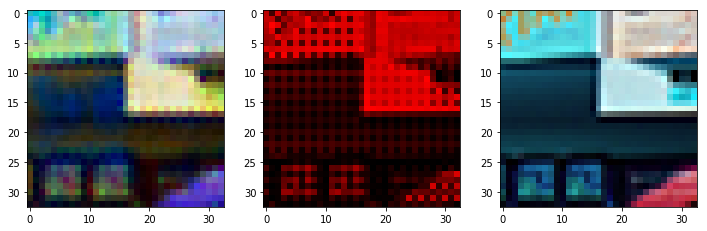

Epoch [49/250], Step [0/782], Loss: 0.03593364357948303
Epoch [49/250], Step [50/782], Loss: 0.026054687798023224
Epoch [49/250], Step [100/782], Loss: 0.03957926109433174
Epoch [49/250], Step [150/782], Loss: 0.03243900462985039
Epoch [49/250], Step [200/782], Loss: 0.04007671773433685
Epoch [49/250], Step [250/782], Loss: 0.052689678966999054
Epoch [49/250], Step [300/782], Loss: 0.025553394109010696
Epoch [49/250], Step [350/782], Loss: 0.05276104435324669
Epoch [49/250], Step [400/782], Loss: 0.031093914061784744
Epoch [49/250], Step [450/782], Loss: 0.0386088602244854
Epoch [49/250], Step [500/782], Loss: 0.04823145642876625
Epoch [49/250], Step [550/782], Loss: 0.03926108032464981
Epoch [49/250], Step [600/782], Loss: 0.02778117172420025
Epoch [49/250], Step [650/782], Loss: 0.04067261889576912
Epoch [49/250], Step [700/782], Loss: 0.03447412699460983
Epoch [49/250], Step [750/782], Loss: 0.033915963023900986

Finished Epoch 49, Loss --- mean: 0.033421875808931065, std 0.00739355

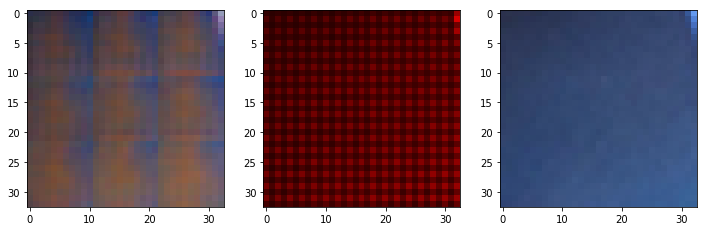

Epoch [50/250], Step [0/782], Loss: 0.03530130907893181
Epoch [50/250], Step [50/782], Loss: 0.03467889875173569
Epoch [50/250], Step [100/782], Loss: 0.03441283851861954
Epoch [50/250], Step [150/782], Loss: 0.0304824598133564
Epoch [50/250], Step [200/782], Loss: 0.03147975727915764
Epoch [50/250], Step [250/782], Loss: 0.037190429866313934
Epoch [50/250], Step [300/782], Loss: 0.04049888253211975
Epoch [50/250], Step [350/782], Loss: 0.023367609828710556
Epoch [50/250], Step [400/782], Loss: 0.03431569039821625
Epoch [50/250], Step [450/782], Loss: 0.0248856320977211
Epoch [50/250], Step [500/782], Loss: 0.030160710215568542
Epoch [50/250], Step [550/782], Loss: 0.02969842590391636
Epoch [50/250], Step [600/782], Loss: 0.03540941700339317
Epoch [50/250], Step [650/782], Loss: 0.03422598913311958
Epoch [50/250], Step [700/782], Loss: 0.03331747651100159
Epoch [50/250], Step [750/782], Loss: 0.040357839316129684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 50, Loss --- mean: 0.03329491841337641, std 0.006839445759738709



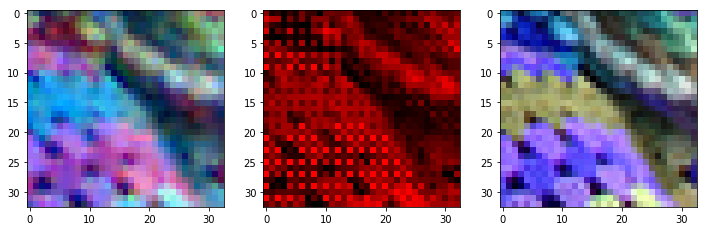

Epoch [51/250], Step [0/782], Loss: 0.024994339793920517
Epoch [51/250], Step [50/782], Loss: 0.02225176803767681
Epoch [51/250], Step [100/782], Loss: 0.030102157965302467
Epoch [51/250], Step [150/782], Loss: 0.024072423577308655
Epoch [51/250], Step [200/782], Loss: 0.030185658484697342
Epoch [51/250], Step [250/782], Loss: 0.028883956372737885
Epoch [51/250], Step [300/782], Loss: 0.04333383962512016
Epoch [51/250], Step [350/782], Loss: 0.04379064589738846
Epoch [51/250], Step [400/782], Loss: 0.04634655639529228
Epoch [51/250], Step [450/782], Loss: 0.027868418022990227
Epoch [51/250], Step [500/782], Loss: 0.03453156352043152
Epoch [51/250], Step [550/782], Loss: 0.04172263294458389
Epoch [51/250], Step [600/782], Loss: 0.033906422555446625
Epoch [51/250], Step [650/782], Loss: 0.031743124127388
Epoch [51/250], Step [700/782], Loss: 0.029251787811517715
Epoch [51/250], Step [750/782], Loss: 0.03385338932275772


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 51, Loss --- mean: 0.03324514997127416, std 0.007055810007767759



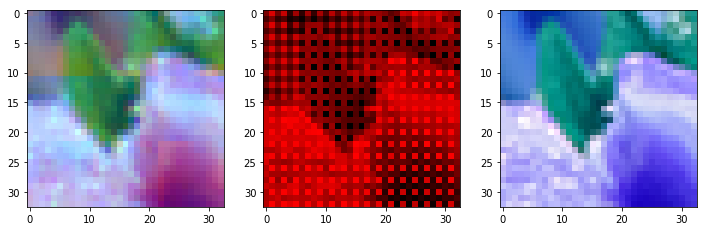

Epoch [52/250], Step [0/782], Loss: 0.03455352410674095
Epoch [52/250], Step [50/782], Loss: 0.028498265892267227
Epoch [52/250], Step [100/782], Loss: 0.03240804374217987
Epoch [52/250], Step [150/782], Loss: 0.0423138402402401
Epoch [52/250], Step [200/782], Loss: 0.04067597910761833
Epoch [52/250], Step [250/782], Loss: 0.028792552649974823
Epoch [52/250], Step [300/782], Loss: 0.024424636736512184
Epoch [52/250], Step [350/782], Loss: 0.02915886417031288
Epoch [52/250], Step [400/782], Loss: 0.027124227955937386
Epoch [52/250], Step [450/782], Loss: 0.03927888721227646
Epoch [52/250], Step [500/782], Loss: 0.04270432889461517
Epoch [52/250], Step [550/782], Loss: 0.032913003116846085
Epoch [52/250], Step [600/782], Loss: 0.030619733035564423
Epoch [52/250], Step [650/782], Loss: 0.036957524716854095
Epoch [52/250], Step [700/782], Loss: 0.032226208597421646
Epoch [52/250], Step [750/782], Loss: 0.028792718425393105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 52, Loss --- mean: 0.032967284362277256, std 0.007144722783996061



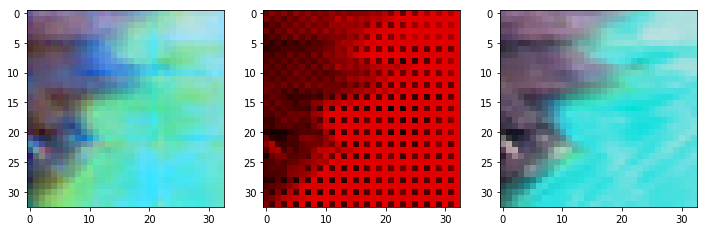

Epoch [53/250], Step [0/782], Loss: 0.025099601596593857
Epoch [53/250], Step [50/782], Loss: 0.027010705322027206
Epoch [53/250], Step [100/782], Loss: 0.031896792352199554
Epoch [53/250], Step [150/782], Loss: 0.02898065745830536
Epoch [53/250], Step [200/782], Loss: 0.02640768140554428
Epoch [53/250], Step [250/782], Loss: 0.026938557624816895
Epoch [53/250], Step [300/782], Loss: 0.02516048401594162
Epoch [53/250], Step [350/782], Loss: 0.021239643916487694
Epoch [53/250], Step [400/782], Loss: 0.03610922768712044
Epoch [53/250], Step [450/782], Loss: 0.03643893077969551
Epoch [53/250], Step [500/782], Loss: 0.03657340630888939
Epoch [53/250], Step [550/782], Loss: 0.025198377668857574
Epoch [53/250], Step [600/782], Loss: 0.027580559253692627
Epoch [53/250], Step [650/782], Loss: 0.031745731830596924
Epoch [53/250], Step [700/782], Loss: 0.03635179623961449
Epoch [53/250], Step [750/782], Loss: 0.028191056102514267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 53, Loss --- mean: 0.03260694221233773, std 0.00709281062277509



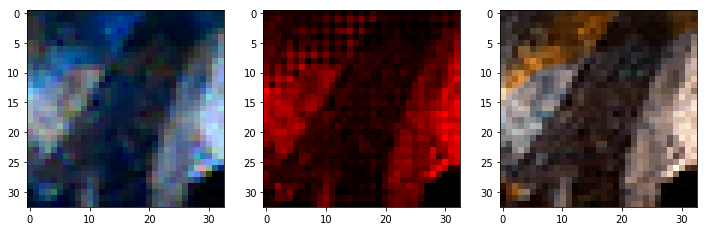

Epoch [54/250], Step [0/782], Loss: 0.025950614362955093
Epoch [54/250], Step [50/782], Loss: 0.03463007137179375
Epoch [54/250], Step [100/782], Loss: 0.030432237312197685
Epoch [54/250], Step [150/782], Loss: 0.03822691738605499
Epoch [54/250], Step [200/782], Loss: 0.03425717353820801
Epoch [54/250], Step [250/782], Loss: 0.03162265196442604
Epoch [54/250], Step [300/782], Loss: 0.023569030687212944
Epoch [54/250], Step [350/782], Loss: 0.022934705018997192
Epoch [54/250], Step [400/782], Loss: 0.027222225442528725
Epoch [54/250], Step [450/782], Loss: 0.0257885679602623
Epoch [54/250], Step [500/782], Loss: 0.028364701196551323
Epoch [54/250], Step [550/782], Loss: 0.031734392046928406
Epoch [54/250], Step [600/782], Loss: 0.025980912148952484
Epoch [54/250], Step [650/782], Loss: 0.0640997514128685
Epoch [54/250], Step [700/782], Loss: 0.03334308788180351
Epoch [54/250], Step [750/782], Loss: 0.02673528529703617


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 54, Loss --- mean: 0.032651446797811165, std 0.007439535576696869



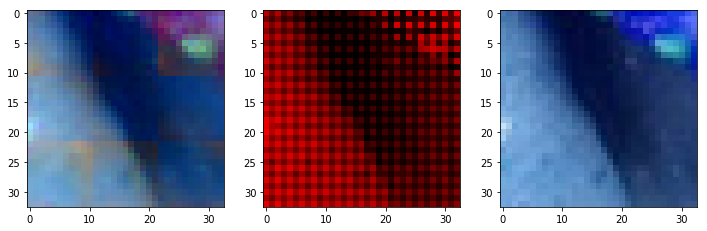

Epoch [55/250], Step [0/782], Loss: 0.02758340910077095
Epoch [55/250], Step [50/782], Loss: 0.03036130592226982
Epoch [55/250], Step [100/782], Loss: 0.028882523998618126
Epoch [55/250], Step [150/782], Loss: 0.029565881937742233
Epoch [55/250], Step [200/782], Loss: 0.030732885003089905
Epoch [55/250], Step [250/782], Loss: 0.04575633630156517
Epoch [55/250], Step [300/782], Loss: 0.020802389830350876
Epoch [55/250], Step [350/782], Loss: 0.04233751446008682
Epoch [55/250], Step [400/782], Loss: 0.026873808354139328
Epoch [55/250], Step [450/782], Loss: 0.04583843797445297
Epoch [55/250], Step [500/782], Loss: 0.034779973328113556
Epoch [55/250], Step [550/782], Loss: 0.030677877366542816
Epoch [55/250], Step [600/782], Loss: 0.02616097591817379
Epoch [55/250], Step [650/782], Loss: 0.03218855708837509
Epoch [55/250], Step [700/782], Loss: 0.03221125155687332
Epoch [55/250], Step [750/782], Loss: 0.029773013666272163


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 55, Loss --- mean: 0.032367977611434735, std 0.006929880659854714



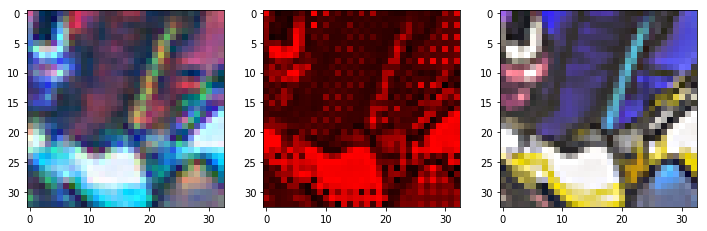

Epoch [56/250], Step [0/782], Loss: 0.025904076173901558
Epoch [56/250], Step [50/782], Loss: 0.03116726316511631
Epoch [56/250], Step [100/782], Loss: 0.029504084959626198
Epoch [56/250], Step [150/782], Loss: 0.035490483045578
Epoch [56/250], Step [200/782], Loss: 0.026434406638145447
Epoch [56/250], Step [250/782], Loss: 0.04221693426370621
Epoch [56/250], Step [300/782], Loss: 0.041144389659166336
Epoch [56/250], Step [350/782], Loss: 0.047812413424253464
Epoch [56/250], Step [400/782], Loss: 0.030424781143665314
Epoch [56/250], Step [450/782], Loss: 0.03537673503160477
Epoch [56/250], Step [500/782], Loss: 0.04186601564288139
Epoch [56/250], Step [550/782], Loss: 0.026809778064489365
Epoch [56/250], Step [600/782], Loss: 0.04327118769288063
Epoch [56/250], Step [650/782], Loss: 0.029897376894950867
Epoch [56/250], Step [700/782], Loss: 0.030153347179293633
Epoch [56/250], Step [750/782], Loss: 0.02881532907485962


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 56, Loss --- mean: 0.03227143256169984, std 0.00699414231130694



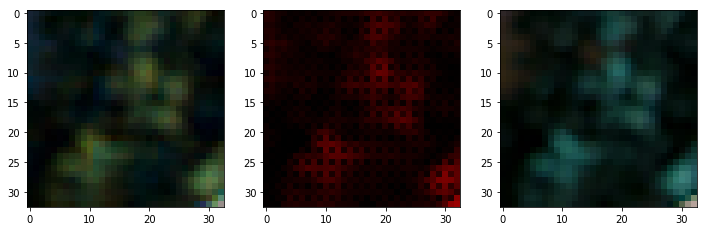

Epoch [57/250], Step [0/782], Loss: 0.027027860283851624
Epoch [57/250], Step [50/782], Loss: 0.02946663834154606
Epoch [57/250], Step [100/782], Loss: 0.03219788894057274
Epoch [57/250], Step [150/782], Loss: 0.03702094405889511
Epoch [57/250], Step [200/782], Loss: 0.029493547976017
Epoch [57/250], Step [250/782], Loss: 0.039656952023506165
Epoch [57/250], Step [300/782], Loss: 0.025876525789499283
Epoch [57/250], Step [350/782], Loss: 0.03944208845496178
Epoch [57/250], Step [400/782], Loss: 0.03415629267692566
Epoch [57/250], Step [450/782], Loss: 0.025056829676032066
Epoch [57/250], Step [500/782], Loss: 0.026332363486289978
Epoch [57/250], Step [550/782], Loss: 0.044877368956804276
Epoch [57/250], Step [600/782], Loss: 0.03006158396601677
Epoch [57/250], Step [650/782], Loss: 0.03383204713463783
Epoch [57/250], Step [700/782], Loss: 0.028313852846622467
Epoch [57/250], Step [750/782], Loss: 0.01922830007970333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 57, Loss --- mean: 0.03228650425258271, std 0.006844419532678968



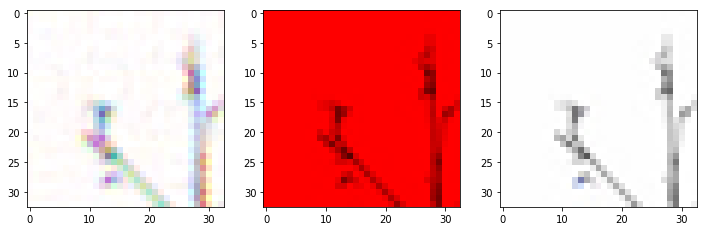

Epoch [58/250], Step [0/782], Loss: 0.04250534251332283
Epoch [58/250], Step [50/782], Loss: 0.03254402056336403
Epoch [58/250], Step [100/782], Loss: 0.027213294059038162
Epoch [58/250], Step [150/782], Loss: 0.027191895991563797
Epoch [58/250], Step [200/782], Loss: 0.022473378106951714
Epoch [58/250], Step [250/782], Loss: 0.040679145604372025
Epoch [58/250], Step [300/782], Loss: 0.04392775148153305
Epoch [58/250], Step [350/782], Loss: 0.03249431774020195
Epoch [58/250], Step [400/782], Loss: 0.033212192356586456
Epoch [58/250], Step [450/782], Loss: 0.028633082285523415
Epoch [58/250], Step [500/782], Loss: 0.021161645650863647
Epoch [58/250], Step [550/782], Loss: 0.028873169794678688
Epoch [58/250], Step [600/782], Loss: 0.0299699567258358
Epoch [58/250], Step [650/782], Loss: 0.043534133583307266
Epoch [58/250], Step [700/782], Loss: 0.03558843582868576
Epoch [58/250], Step [750/782], Loss: 0.03496132418513298


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 58, Loss --- mean: 0.03175282944946566, std 0.006853469511511262



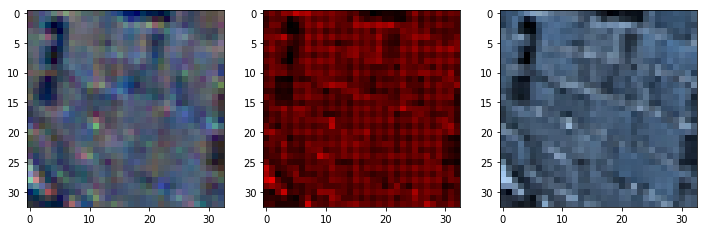

Epoch [59/250], Step [0/782], Loss: 0.038700543344020844
Epoch [59/250], Step [50/782], Loss: 0.020741771906614304
Epoch [59/250], Step [100/782], Loss: 0.036953404545784
Epoch [59/250], Step [150/782], Loss: 0.024534694850444794
Epoch [59/250], Step [200/782], Loss: 0.028112314641475677
Epoch [59/250], Step [250/782], Loss: 0.018936550244688988
Epoch [59/250], Step [300/782], Loss: 0.04436011239886284
Epoch [59/250], Step [350/782], Loss: 0.031839318573474884
Epoch [59/250], Step [400/782], Loss: 0.02592397667467594
Epoch [59/250], Step [450/782], Loss: 0.03500549867749214
Epoch [59/250], Step [500/782], Loss: 0.0336402989923954
Epoch [59/250], Step [550/782], Loss: 0.03200313448905945
Epoch [59/250], Step [600/782], Loss: 0.03679518774151802
Epoch [59/250], Step [650/782], Loss: 0.021701136603951454
Epoch [59/250], Step [700/782], Loss: 0.034314095973968506
Epoch [59/250], Step [750/782], Loss: 0.0220546443015337


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 59, Loss --- mean: 0.0320164473855968, std 0.0069008592671766875



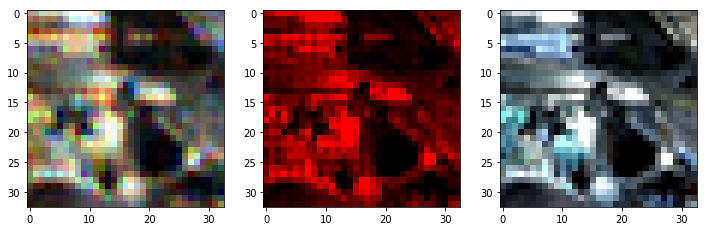

Epoch [60/250], Step [0/782], Loss: 0.027212180197238922
Epoch [60/250], Step [50/782], Loss: 0.02991563268005848
Epoch [60/250], Step [100/782], Loss: 0.028156936168670654
Epoch [60/250], Step [150/782], Loss: 0.04192788153886795
Epoch [60/250], Step [200/782], Loss: 0.036839354783296585
Epoch [60/250], Step [250/782], Loss: 0.04780930280685425
Epoch [60/250], Step [300/782], Loss: 0.036000076681375504
Epoch [60/250], Step [350/782], Loss: 0.02956581860780716
Epoch [60/250], Step [400/782], Loss: 0.03216526284813881
Epoch [60/250], Step [450/782], Loss: 0.023674866184592247
Epoch [60/250], Step [500/782], Loss: 0.02888767048716545
Epoch [60/250], Step [550/782], Loss: 0.034512244164943695
Epoch [60/250], Step [600/782], Loss: 0.04612848162651062
Epoch [60/250], Step [650/782], Loss: 0.030203325673937798
Epoch [60/250], Step [700/782], Loss: 0.028265127912163734
Epoch [60/250], Step [750/782], Loss: 0.024335701018571854


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 60, Loss --- mean: 0.03182112733068902, std 0.006870663031464832



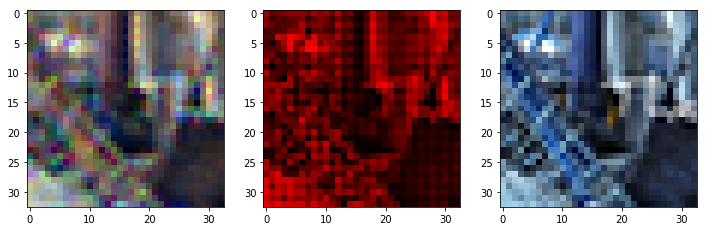

Epoch [61/250], Step [0/782], Loss: 0.038317956030368805
Epoch [61/250], Step [50/782], Loss: 0.02185150980949402
Epoch [61/250], Step [100/782], Loss: 0.02389737218618393
Epoch [61/250], Step [150/782], Loss: 0.033151235431432724
Epoch [61/250], Step [200/782], Loss: 0.019393762573599815
Epoch [61/250], Step [250/782], Loss: 0.028904911130666733
Epoch [61/250], Step [300/782], Loss: 0.02201385609805584
Epoch [61/250], Step [350/782], Loss: 0.050375066697597504
Epoch [61/250], Step [400/782], Loss: 0.023510664701461792
Epoch [61/250], Step [450/782], Loss: 0.04998243227601051
Epoch [61/250], Step [500/782], Loss: 0.0251059178262949
Epoch [61/250], Step [550/782], Loss: 0.04369353502988815
Epoch [61/250], Step [600/782], Loss: 0.03423817828297615
Epoch [61/250], Step [650/782], Loss: 0.01941096782684326
Epoch [61/250], Step [700/782], Loss: 0.020686492323875427
Epoch [61/250], Step [750/782], Loss: 0.027080796658992767


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 61, Loss --- mean: 0.03133908348977375, std 0.007183834820591766



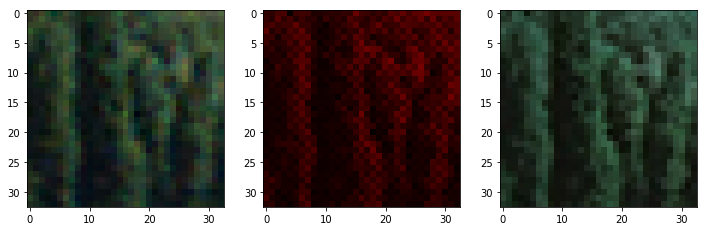

Epoch [62/250], Step [0/782], Loss: 0.025650780647993088
Epoch [62/250], Step [50/782], Loss: 0.03951302915811539
Epoch [62/250], Step [100/782], Loss: 0.04701216518878937
Epoch [62/250], Step [150/782], Loss: 0.035878244787454605
Epoch [62/250], Step [200/782], Loss: 0.03319757059216499
Epoch [62/250], Step [250/782], Loss: 0.02114289440214634
Epoch [62/250], Step [300/782], Loss: 0.041885800659656525
Epoch [62/250], Step [350/782], Loss: 0.03988777846097946
Epoch [62/250], Step [400/782], Loss: 0.03569282218813896
Epoch [62/250], Step [450/782], Loss: 0.043249715119600296
Epoch [62/250], Step [500/782], Loss: 0.029840923845767975
Epoch [62/250], Step [550/782], Loss: 0.03664866462349892
Epoch [62/250], Step [600/782], Loss: 0.024843944236636162
Epoch [62/250], Step [650/782], Loss: 0.028866294771432877
Epoch [62/250], Step [700/782], Loss: 0.029832247644662857
Epoch [62/250], Step [750/782], Loss: 0.03796399012207985


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 62, Loss --- mean: 0.030891772669256495, std 0.006743858022148937



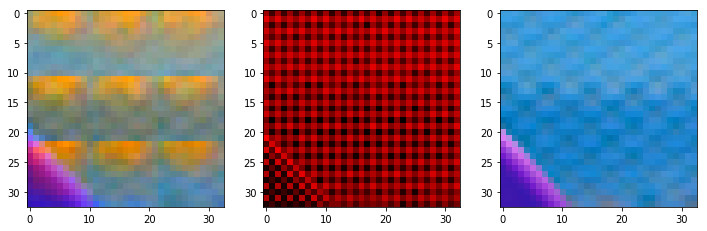

Epoch [63/250], Step [0/782], Loss: 0.024389654397964478
Epoch [63/250], Step [50/782], Loss: 0.030287832021713257
Epoch [63/250], Step [100/782], Loss: 0.02563677355647087
Epoch [63/250], Step [150/782], Loss: 0.025958815589547157
Epoch [63/250], Step [200/782], Loss: 0.030954336747527122
Epoch [63/250], Step [250/782], Loss: 0.030821945518255234
Epoch [63/250], Step [300/782], Loss: 0.02665211819112301
Epoch [63/250], Step [350/782], Loss: 0.026480430737137794
Epoch [63/250], Step [400/782], Loss: 0.025339188054203987
Epoch [63/250], Step [450/782], Loss: 0.02910609543323517
Epoch [63/250], Step [500/782], Loss: 0.026745056733489037
Epoch [63/250], Step [550/782], Loss: 0.025300195440649986
Epoch [63/250], Step [600/782], Loss: 0.023735592141747475
Epoch [63/250], Step [650/782], Loss: 0.03390372544527054
Epoch [63/250], Step [700/782], Loss: 0.022002171725034714
Epoch [63/250], Step [750/782], Loss: 0.0366290919482708


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 63, Loss --- mean: 0.030857122095916276, std 0.007074488548732915



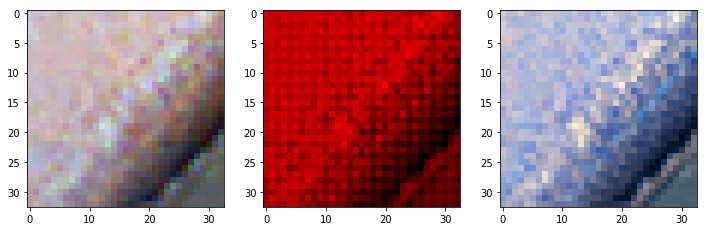

Epoch [64/250], Step [0/782], Loss: 0.027924073860049248
Epoch [64/250], Step [50/782], Loss: 0.0310350451618433
Epoch [64/250], Step [100/782], Loss: 0.026428839191794395
Epoch [64/250], Step [150/782], Loss: 0.029184209182858467
Epoch [64/250], Step [200/782], Loss: 0.024754688143730164
Epoch [64/250], Step [250/782], Loss: 0.03838567063212395
Epoch [64/250], Step [300/782], Loss: 0.031489159911870956
Epoch [64/250], Step [350/782], Loss: 0.0339958593249321
Epoch [64/250], Step [400/782], Loss: 0.026020994409918785
Epoch [64/250], Step [450/782], Loss: 0.03294287994503975
Epoch [64/250], Step [500/782], Loss: 0.02985364943742752
Epoch [64/250], Step [550/782], Loss: 0.03414769098162651
Epoch [64/250], Step [600/782], Loss: 0.03951448202133179
Epoch [64/250], Step [650/782], Loss: 0.040048591792583466
Epoch [64/250], Step [700/782], Loss: 0.03965788707137108
Epoch [64/250], Step [750/782], Loss: 0.041662584990262985

Finished Epoch 64, Loss --- mean: 0.030690320684095784, std 0.006590

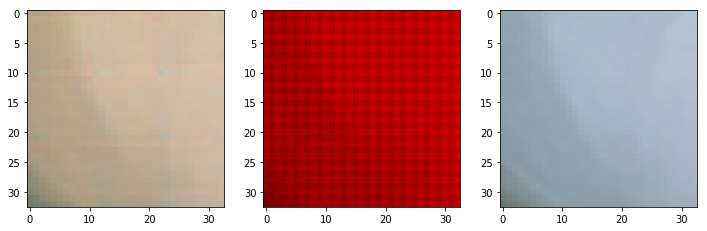

Epoch [65/250], Step [0/782], Loss: 0.028405653312802315
Epoch [65/250], Step [50/782], Loss: 0.049993135035037994
Epoch [65/250], Step [100/782], Loss: 0.03163629025220871
Epoch [65/250], Step [150/782], Loss: 0.029098471626639366
Epoch [65/250], Step [200/782], Loss: 0.0254600178450346
Epoch [65/250], Step [250/782], Loss: 0.03736438974738121
Epoch [65/250], Step [300/782], Loss: 0.02676054835319519
Epoch [65/250], Step [350/782], Loss: 0.04150961712002754
Epoch [65/250], Step [400/782], Loss: 0.02689766325056553
Epoch [65/250], Step [450/782], Loss: 0.0299692265689373
Epoch [65/250], Step [500/782], Loss: 0.03347001224756241
Epoch [65/250], Step [550/782], Loss: 0.025022797286510468
Epoch [65/250], Step [600/782], Loss: 0.03618406876921654
Epoch [65/250], Step [650/782], Loss: 0.022614171728491783
Epoch [65/250], Step [700/782], Loss: 0.03065324015915394
Epoch [65/250], Step [750/782], Loss: 0.02676229551434517

Finished Epoch 65, Loss --- mean: 0.030730283421361842, std 0.006968738

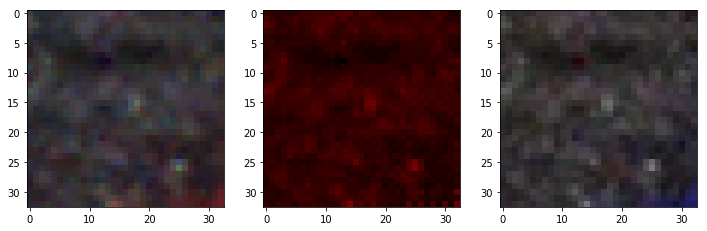

Epoch [66/250], Step [0/782], Loss: 0.029930002987384796
Epoch [66/250], Step [50/782], Loss: 0.02466929331421852
Epoch [66/250], Step [100/782], Loss: 0.02480538934469223
Epoch [66/250], Step [150/782], Loss: 0.021376200020313263
Epoch [66/250], Step [200/782], Loss: 0.023274188861250877
Epoch [66/250], Step [250/782], Loss: 0.0486394539475441
Epoch [66/250], Step [300/782], Loss: 0.03331316262483597
Epoch [66/250], Step [350/782], Loss: 0.02433534525334835
Epoch [66/250], Step [400/782], Loss: 0.03616547957062721
Epoch [66/250], Step [450/782], Loss: 0.034998584538698196
Epoch [66/250], Step [500/782], Loss: 0.03517767786979675
Epoch [66/250], Step [550/782], Loss: 0.02282818965613842
Epoch [66/250], Step [600/782], Loss: 0.036495789885520935
Epoch [66/250], Step [650/782], Loss: 0.03283169865608215
Epoch [66/250], Step [700/782], Loss: 0.033848147839307785
Epoch [66/250], Step [750/782], Loss: 0.023753279820084572


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 66, Loss --- mean: 0.0304656571368008, std 0.0066005399519594166



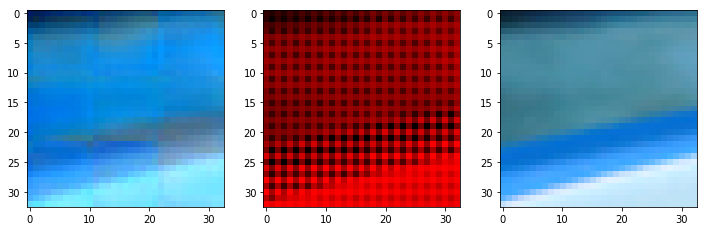

Epoch [67/250], Step [0/782], Loss: 0.03770056366920471
Epoch [67/250], Step [50/782], Loss: 0.027425503358244896
Epoch [67/250], Step [100/782], Loss: 0.04233315959572792
Epoch [67/250], Step [150/782], Loss: 0.025658568367362022
Epoch [67/250], Step [200/782], Loss: 0.03700181469321251
Epoch [67/250], Step [250/782], Loss: 0.026017433032393456
Epoch [67/250], Step [300/782], Loss: 0.04600777477025986
Epoch [67/250], Step [350/782], Loss: 0.022802339866757393
Epoch [67/250], Step [400/782], Loss: 0.0250660702586174
Epoch [67/250], Step [450/782], Loss: 0.03357498720288277
Epoch [67/250], Step [500/782], Loss: 0.02970409393310547
Epoch [67/250], Step [550/782], Loss: 0.026542847976088524
Epoch [67/250], Step [600/782], Loss: 0.03127817437052727
Epoch [67/250], Step [650/782], Loss: 0.025646619498729706
Epoch [67/250], Step [700/782], Loss: 0.02463863417506218
Epoch [67/250], Step [750/782], Loss: 0.031243234872817993


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 67, Loss --- mean: 0.030177820940761615, std 0.006597604437158844



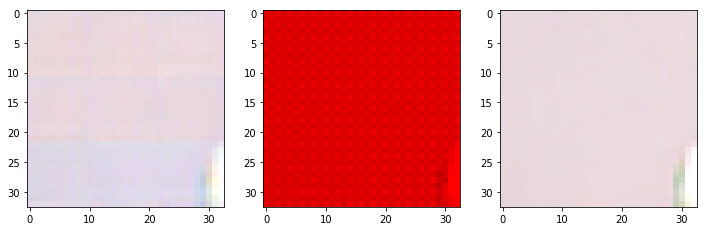

Epoch [68/250], Step [0/782], Loss: 0.03312486782670021
Epoch [68/250], Step [50/782], Loss: 0.03175552189350128
Epoch [68/250], Step [100/782], Loss: 0.03576052561402321
Epoch [68/250], Step [150/782], Loss: 0.030571183189749718
Epoch [68/250], Step [200/782], Loss: 0.023854944854974747
Epoch [68/250], Step [250/782], Loss: 0.03724301978945732
Epoch [68/250], Step [300/782], Loss: 0.024578599259257317
Epoch [68/250], Step [350/782], Loss: 0.035027455538511276
Epoch [68/250], Step [400/782], Loss: 0.0292778629809618
Epoch [68/250], Step [450/782], Loss: 0.04367203265428543
Epoch [68/250], Step [500/782], Loss: 0.038836363703012466
Epoch [68/250], Step [550/782], Loss: 0.03033613972365856
Epoch [68/250], Step [600/782], Loss: 0.03815605863928795
Epoch [68/250], Step [650/782], Loss: 0.029261477291584015
Epoch [68/250], Step [700/782], Loss: 0.030491605401039124
Epoch [68/250], Step [750/782], Loss: 0.03121517412364483


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 68, Loss --- mean: 0.03019778586714469, std 0.006722650066572189



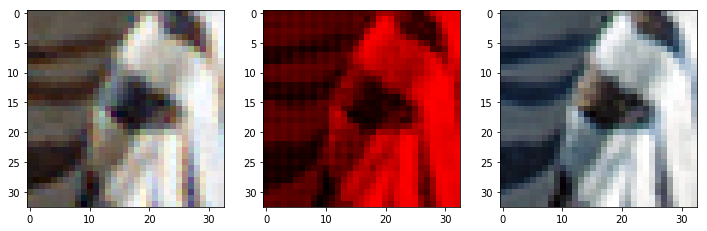

Epoch [69/250], Step [0/782], Loss: 0.03316537290811539
Epoch [69/250], Step [50/782], Loss: 0.02341574989259243
Epoch [69/250], Step [100/782], Loss: 0.034679532051086426
Epoch [69/250], Step [150/782], Loss: 0.03918455168604851
Epoch [69/250], Step [200/782], Loss: 0.026965094730257988
Epoch [69/250], Step [250/782], Loss: 0.03282395377755165
Epoch [69/250], Step [300/782], Loss: 0.03765407204627991
Epoch [69/250], Step [350/782], Loss: 0.023778850212693214
Epoch [69/250], Step [400/782], Loss: 0.03340278938412666
Epoch [69/250], Step [450/782], Loss: 0.023660888895392418
Epoch [69/250], Step [500/782], Loss: 0.0436762273311615
Epoch [69/250], Step [550/782], Loss: 0.025628652423620224
Epoch [69/250], Step [600/782], Loss: 0.019422369077801704
Epoch [69/250], Step [650/782], Loss: 0.02116543985903263
Epoch [69/250], Step [700/782], Loss: 0.033806681632995605
Epoch [69/250], Step [750/782], Loss: 0.0405782014131546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 69, Loss --- mean: 0.029913942984607825, std 0.006688242168516357



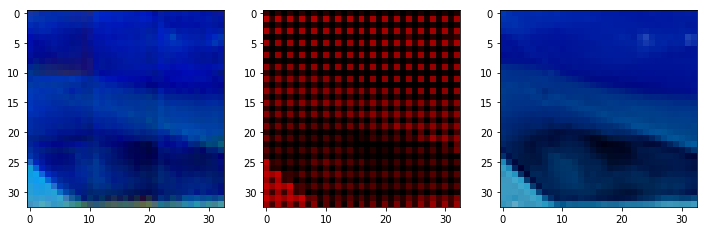

Epoch [70/250], Step [0/782], Loss: 0.029748858883976936
Epoch [70/250], Step [50/782], Loss: 0.02154371328651905
Epoch [70/250], Step [100/782], Loss: 0.027616938576102257
Epoch [70/250], Step [150/782], Loss: 0.026833374053239822
Epoch [70/250], Step [200/782], Loss: 0.030955489724874496
Epoch [70/250], Step [250/782], Loss: 0.03407241031527519
Epoch [70/250], Step [300/782], Loss: 0.024212779477238655
Epoch [70/250], Step [350/782], Loss: 0.028815889731049538
Epoch [70/250], Step [400/782], Loss: 0.03295465558767319
Epoch [70/250], Step [450/782], Loss: 0.029697341844439507
Epoch [70/250], Step [500/782], Loss: 0.0323641262948513
Epoch [70/250], Step [550/782], Loss: 0.022937312722206116
Epoch [70/250], Step [600/782], Loss: 0.021388502791523933
Epoch [70/250], Step [650/782], Loss: 0.030923372134566307
Epoch [70/250], Step [700/782], Loss: 0.02840866521000862
Epoch [70/250], Step [750/782], Loss: 0.032237160950899124


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 70, Loss --- mean: 0.029854864088099096, std 0.00668221364586998



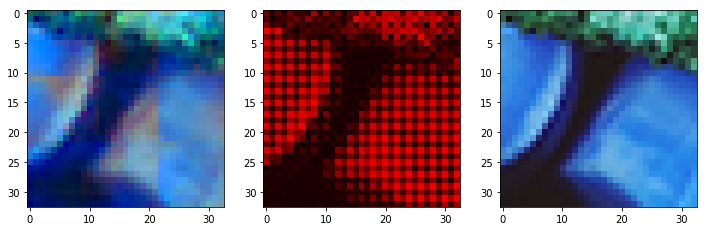

Epoch [71/250], Step [0/782], Loss: 0.029791422188282013
Epoch [71/250], Step [50/782], Loss: 0.031788866966962814
Epoch [71/250], Step [100/782], Loss: 0.02416900359094143
Epoch [71/250], Step [150/782], Loss: 0.02135555073618889
Epoch [71/250], Step [200/782], Loss: 0.036921560764312744
Epoch [71/250], Step [250/782], Loss: 0.03295202925801277
Epoch [71/250], Step [300/782], Loss: 0.03204294294118881
Epoch [71/250], Step [350/782], Loss: 0.0286225825548172
Epoch [71/250], Step [400/782], Loss: 0.026586312800645828
Epoch [71/250], Step [450/782], Loss: 0.03527328372001648
Epoch [71/250], Step [500/782], Loss: 0.03229531645774841
Epoch [71/250], Step [550/782], Loss: 0.03585609793663025
Epoch [71/250], Step [600/782], Loss: 0.03728243336081505
Epoch [71/250], Step [650/782], Loss: 0.024367164820432663
Epoch [71/250], Step [700/782], Loss: 0.021556906402111053
Epoch [71/250], Step [750/782], Loss: 0.029522869735956192


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 71, Loss --- mean: 0.029746871640491286, std 0.0067290123308603



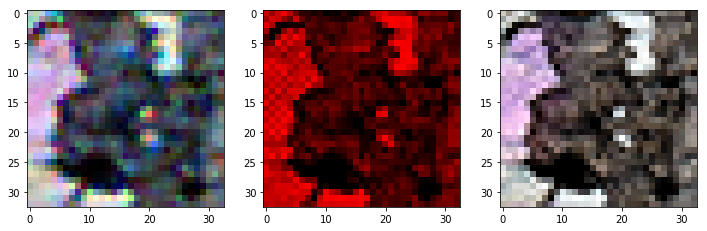

Epoch [72/250], Step [0/782], Loss: 0.0402410551905632
Epoch [72/250], Step [50/782], Loss: 0.02020478993654251
Epoch [72/250], Step [100/782], Loss: 0.03942481428384781
Epoch [72/250], Step [150/782], Loss: 0.03174320235848427
Epoch [72/250], Step [200/782], Loss: 0.034442536532878876
Epoch [72/250], Step [250/782], Loss: 0.027689503505825996
Epoch [72/250], Step [300/782], Loss: 0.030027655884623528
Epoch [72/250], Step [350/782], Loss: 0.020838811993598938
Epoch [72/250], Step [400/782], Loss: 0.04258052259683609
Epoch [72/250], Step [450/782], Loss: 0.025684189051389694
Epoch [72/250], Step [500/782], Loss: 0.04108984023332596
Epoch [72/250], Step [550/782], Loss: 0.028757017105817795
Epoch [72/250], Step [600/782], Loss: 0.03114965744316578
Epoch [72/250], Step [650/782], Loss: 0.03078208677470684
Epoch [72/250], Step [700/782], Loss: 0.027693551033735275
Epoch [72/250], Step [750/782], Loss: 0.03313751891255379


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 72, Loss --- mean: 0.029596986949367597, std 0.006560749261171059



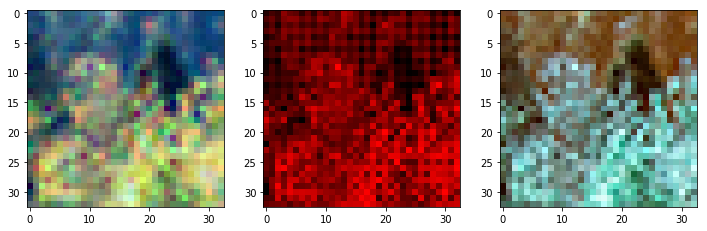

Epoch [73/250], Step [0/782], Loss: 0.027321254834532738
Epoch [73/250], Step [50/782], Loss: 0.021170135587453842
Epoch [73/250], Step [100/782], Loss: 0.02831406705081463
Epoch [73/250], Step [150/782], Loss: 0.029340092092752457
Epoch [73/250], Step [200/782], Loss: 0.029309283941984177
Epoch [73/250], Step [250/782], Loss: 0.02901013009250164
Epoch [73/250], Step [300/782], Loss: 0.04759370908141136
Epoch [73/250], Step [350/782], Loss: 0.030437052249908447
Epoch [73/250], Step [400/782], Loss: 0.023091286420822144
Epoch [73/250], Step [450/782], Loss: 0.025390181690454483
Epoch [73/250], Step [500/782], Loss: 0.019298790022730827
Epoch [73/250], Step [550/782], Loss: 0.027167407795786858
Epoch [73/250], Step [600/782], Loss: 0.030288556590676308
Epoch [73/250], Step [650/782], Loss: 0.03285394236445427
Epoch [73/250], Step [700/782], Loss: 0.028375335037708282
Epoch [73/250], Step [750/782], Loss: 0.03382708132266998

Finished Epoch 73, Loss --- mean: 0.029536443357558353, std 0.0

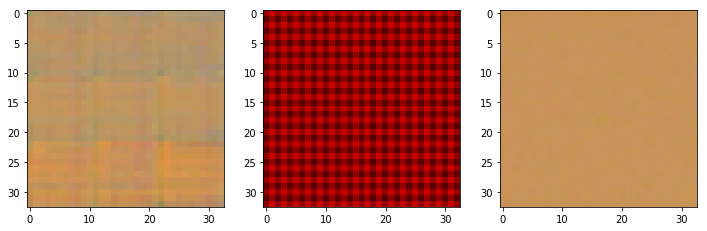

Epoch [74/250], Step [0/782], Loss: 0.04389738291501999
Epoch [74/250], Step [50/782], Loss: 0.02936318702995777
Epoch [74/250], Step [100/782], Loss: 0.039110030978918076
Epoch [74/250], Step [150/782], Loss: 0.035621434450149536
Epoch [74/250], Step [200/782], Loss: 0.036426443606615067
Epoch [74/250], Step [250/782], Loss: 0.03715386241674423
Epoch [74/250], Step [300/782], Loss: 0.034734390676021576
Epoch [74/250], Step [350/782], Loss: 0.02569238282740116
Epoch [74/250], Step [400/782], Loss: 0.02238360233604908
Epoch [74/250], Step [450/782], Loss: 0.032484687864780426
Epoch [74/250], Step [500/782], Loss: 0.026279693469405174
Epoch [74/250], Step [550/782], Loss: 0.026368431746959686
Epoch [74/250], Step [600/782], Loss: 0.020208409056067467
Epoch [74/250], Step [650/782], Loss: 0.027421286329627037
Epoch [74/250], Step [700/782], Loss: 0.030796248465776443
Epoch [74/250], Step [750/782], Loss: 0.03664807602763176

Finished Epoch 74, Loss --- mean: 0.02921695072475411, std 0.006

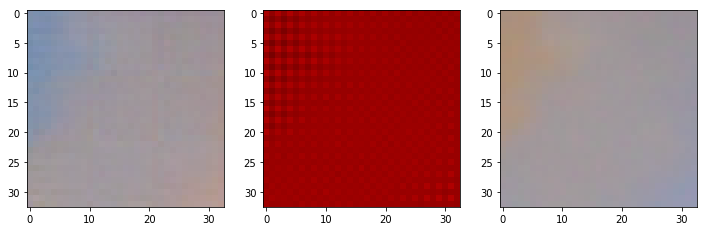

Epoch [75/250], Step [0/782], Loss: 0.03366301953792572
Epoch [75/250], Step [50/782], Loss: 0.015627099201083183
Epoch [75/250], Step [100/782], Loss: 0.02833748236298561
Epoch [75/250], Step [150/782], Loss: 0.02861763723194599
Epoch [75/250], Step [200/782], Loss: 0.027034025639295578
Epoch [75/250], Step [250/782], Loss: 0.03327254578471184
Epoch [75/250], Step [300/782], Loss: 0.030938010662794113
Epoch [75/250], Step [350/782], Loss: 0.01824232004582882
Epoch [75/250], Step [400/782], Loss: 0.025376543402671814
Epoch [75/250], Step [450/782], Loss: 0.022416800260543823
Epoch [75/250], Step [500/782], Loss: 0.017840281128883362
Epoch [75/250], Step [550/782], Loss: 0.026543645188212395
Epoch [75/250], Step [600/782], Loss: 0.02917572669684887
Epoch [75/250], Step [650/782], Loss: 0.039220087230205536
Epoch [75/250], Step [700/782], Loss: 0.03947978839278221
Epoch [75/250], Step [750/782], Loss: 0.03183722868561745


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 75, Loss --- mean: 0.029272369514017002, std 0.00632762289496984



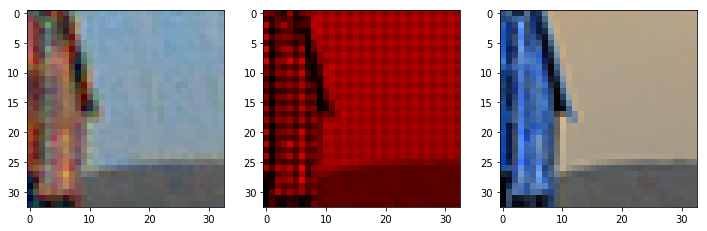

Epoch [76/250], Step [0/782], Loss: 0.028033604845404625
Epoch [76/250], Step [50/782], Loss: 0.02375279739499092
Epoch [76/250], Step [100/782], Loss: 0.04104156419634819
Epoch [76/250], Step [150/782], Loss: 0.017886871472001076
Epoch [76/250], Step [200/782], Loss: 0.032531220465898514
Epoch [76/250], Step [250/782], Loss: 0.02770565077662468
Epoch [76/250], Step [300/782], Loss: 0.018342390656471252
Epoch [76/250], Step [350/782], Loss: 0.034564316272735596
Epoch [76/250], Step [400/782], Loss: 0.027031494304537773
Epoch [76/250], Step [450/782], Loss: 0.025140730664134026
Epoch [76/250], Step [500/782], Loss: 0.026844188570976257
Epoch [76/250], Step [550/782], Loss: 0.028253667056560516
Epoch [76/250], Step [600/782], Loss: 0.02592424862086773
Epoch [76/250], Step [650/782], Loss: 0.027307238429784775
Epoch [76/250], Step [700/782], Loss: 0.03479689732193947
Epoch [76/250], Step [750/782], Loss: 0.02947300300002098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 76, Loss --- mean: 0.029052702754097597, std 0.006512916502273995



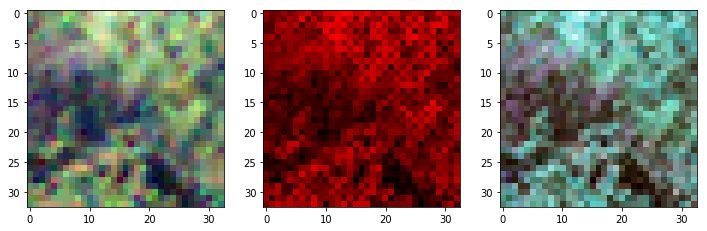

Epoch [77/250], Step [0/782], Loss: 0.026043422520160675
Epoch [77/250], Step [50/782], Loss: 0.02393323741853237
Epoch [77/250], Step [100/782], Loss: 0.0323837511241436
Epoch [77/250], Step [150/782], Loss: 0.021823015064001083
Epoch [77/250], Step [200/782], Loss: 0.028708869591355324
Epoch [77/250], Step [250/782], Loss: 0.027784662321209908
Epoch [77/250], Step [300/782], Loss: 0.02993532083928585
Epoch [77/250], Step [350/782], Loss: 0.03644320368766785
Epoch [77/250], Step [400/782], Loss: 0.02766527608036995
Epoch [77/250], Step [450/782], Loss: 0.02363990806043148
Epoch [77/250], Step [500/782], Loss: 0.031376030296087265
Epoch [77/250], Step [550/782], Loss: 0.028826260939240456
Epoch [77/250], Step [600/782], Loss: 0.02939648926258087
Epoch [77/250], Step [650/782], Loss: 0.0216141939163208
Epoch [77/250], Step [700/782], Loss: 0.02074209414422512
Epoch [77/250], Step [750/782], Loss: 0.022956617176532745


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 77, Loss --- mean: 0.02915266509551336, std 0.0065204743211040505



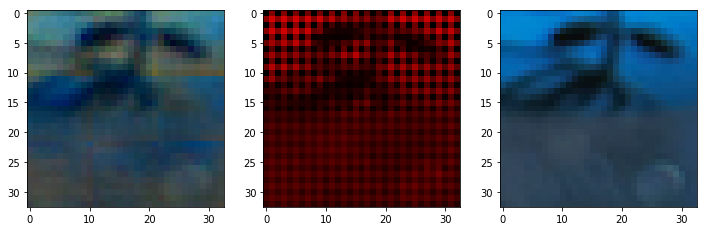

Epoch [78/250], Step [0/782], Loss: 0.01962483488023281
Epoch [78/250], Step [50/782], Loss: 0.024830598384141922
Epoch [78/250], Step [100/782], Loss: 0.04354915767908096
Epoch [78/250], Step [150/782], Loss: 0.034066665917634964
Epoch [78/250], Step [200/782], Loss: 0.026322687044739723
Epoch [78/250], Step [250/782], Loss: 0.028366027399897575
Epoch [78/250], Step [300/782], Loss: 0.031156709417700768
Epoch [78/250], Step [350/782], Loss: 0.035923317074775696
Epoch [78/250], Step [400/782], Loss: 0.020529193803668022
Epoch [78/250], Step [450/782], Loss: 0.026033904403448105
Epoch [78/250], Step [500/782], Loss: 0.020914550870656967
Epoch [78/250], Step [550/782], Loss: 0.033717699348926544
Epoch [78/250], Step [600/782], Loss: 0.027935044839978218
Epoch [78/250], Step [650/782], Loss: 0.017527224496006966
Epoch [78/250], Step [700/782], Loss: 0.023426765576004982
Epoch [78/250], Step [750/782], Loss: 0.04236935079097748

Finished Epoch 78, Loss --- mean: 0.028777667153340854, std 0

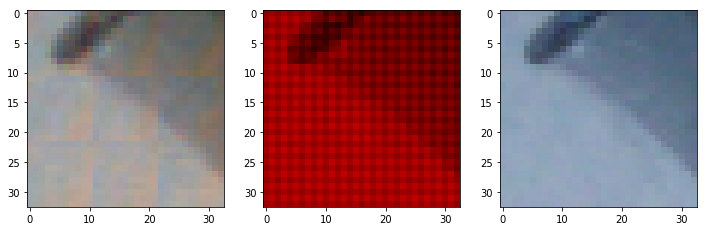

Epoch [79/250], Step [0/782], Loss: 0.030507942661643028
Epoch [79/250], Step [50/782], Loss: 0.02125234343111515
Epoch [79/250], Step [100/782], Loss: 0.02151249162852764
Epoch [79/250], Step [150/782], Loss: 0.02667938731610775
Epoch [79/250], Step [200/782], Loss: 0.025266991928219795
Epoch [79/250], Step [250/782], Loss: 0.04617830738425255
Epoch [79/250], Step [300/782], Loss: 0.024791071191430092
Epoch [79/250], Step [350/782], Loss: 0.029342109337449074
Epoch [79/250], Step [400/782], Loss: 0.023947415873408318
Epoch [79/250], Step [450/782], Loss: 0.024410298094153404
Epoch [79/250], Step [500/782], Loss: 0.022402213886380196
Epoch [79/250], Step [550/782], Loss: 0.033295080065727234
Epoch [79/250], Step [600/782], Loss: 0.02803073264658451
Epoch [79/250], Step [650/782], Loss: 0.033234622329473495
Epoch [79/250], Step [700/782], Loss: 0.031721197068691254
Epoch [79/250], Step [750/782], Loss: 0.04233990237116814

Finished Epoch 79, Loss --- mean: 0.02879174182648816, std 0.006

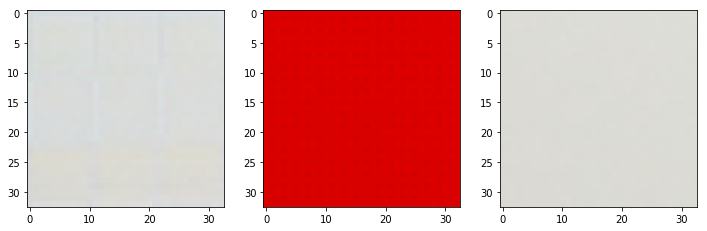

Epoch [80/250], Step [0/782], Loss: 0.0366557352244854
Epoch [80/250], Step [50/782], Loss: 0.03353191912174225
Epoch [80/250], Step [100/782], Loss: 0.021700279787182808
Epoch [80/250], Step [150/782], Loss: 0.025101810693740845
Epoch [80/250], Step [200/782], Loss: 0.026130996644496918
Epoch [80/250], Step [250/782], Loss: 0.02850390411913395
Epoch [80/250], Step [300/782], Loss: 0.03373384848237038
Epoch [80/250], Step [350/782], Loss: 0.027772817760705948
Epoch [80/250], Step [400/782], Loss: 0.035320062190294266
Epoch [80/250], Step [450/782], Loss: 0.025895914062857628
Epoch [80/250], Step [500/782], Loss: 0.03451874107122421
Epoch [80/250], Step [550/782], Loss: 0.023334262892603874
Epoch [80/250], Step [600/782], Loss: 0.023438256233930588
Epoch [80/250], Step [650/782], Loss: 0.027751538902521133
Epoch [80/250], Step [700/782], Loss: 0.041626714169979095
Epoch [80/250], Step [750/782], Loss: 0.02373451180756092

Finished Epoch 80, Loss --- mean: 0.02850432612497331, std 0.0061

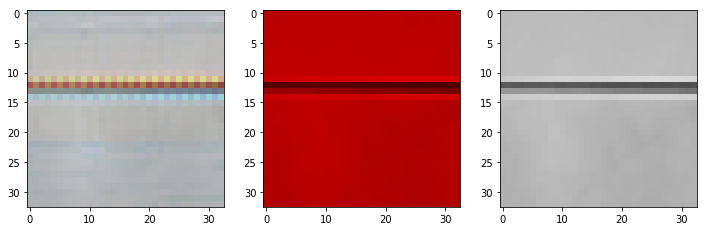

Epoch [81/250], Step [0/782], Loss: 0.020151203498244286
Epoch [81/250], Step [50/782], Loss: 0.032500166445970535
Epoch [81/250], Step [100/782], Loss: 0.02104991115629673
Epoch [81/250], Step [150/782], Loss: 0.02200906351208687
Epoch [81/250], Step [200/782], Loss: 0.02576798014342785
Epoch [81/250], Step [250/782], Loss: 0.03208417445421219
Epoch [81/250], Step [300/782], Loss: 0.027675265446305275
Epoch [81/250], Step [350/782], Loss: 0.03808891400694847
Epoch [81/250], Step [400/782], Loss: 0.033862415701150894
Epoch [81/250], Step [450/782], Loss: 0.019992219284176826
Epoch [81/250], Step [500/782], Loss: 0.03666028752923012
Epoch [81/250], Step [550/782], Loss: 0.02613474614918232
Epoch [81/250], Step [600/782], Loss: 0.03202686458826065
Epoch [81/250], Step [650/782], Loss: 0.027737202122807503
Epoch [81/250], Step [700/782], Loss: 0.017570219933986664
Epoch [81/250], Step [750/782], Loss: 0.023381317034363747


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 81, Loss --- mean: 0.028596992390063566, std 0.006257523999177977



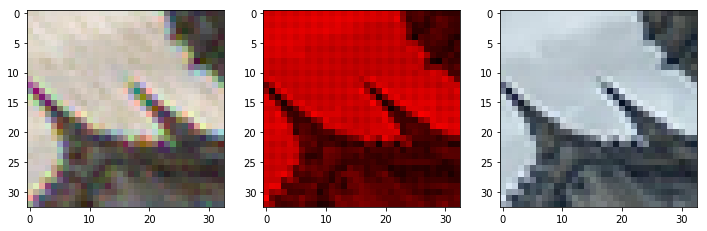

Epoch [82/250], Step [0/782], Loss: 0.02521555684506893
Epoch [82/250], Step [50/782], Loss: 0.021503064781427383
Epoch [82/250], Step [100/782], Loss: 0.026697689667344093
Epoch [82/250], Step [150/782], Loss: 0.028405610471963882
Epoch [82/250], Step [200/782], Loss: 0.02382385917007923
Epoch [82/250], Step [250/782], Loss: 0.03163360059261322
Epoch [82/250], Step [300/782], Loss: 0.026896877214312553
Epoch [82/250], Step [350/782], Loss: 0.02541552297770977
Epoch [82/250], Step [400/782], Loss: 0.031982745975255966
Epoch [82/250], Step [450/782], Loss: 0.035276442766189575
Epoch [82/250], Step [500/782], Loss: 0.03143132105469704
Epoch [82/250], Step [550/782], Loss: 0.027445971965789795
Epoch [82/250], Step [600/782], Loss: 0.026951143518090248
Epoch [82/250], Step [650/782], Loss: 0.03405093401670456
Epoch [82/250], Step [700/782], Loss: 0.020685093477368355
Epoch [82/250], Step [750/782], Loss: 0.03313538432121277


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 82, Loss --- mean: 0.028306064918837356, std 0.006360918112958981



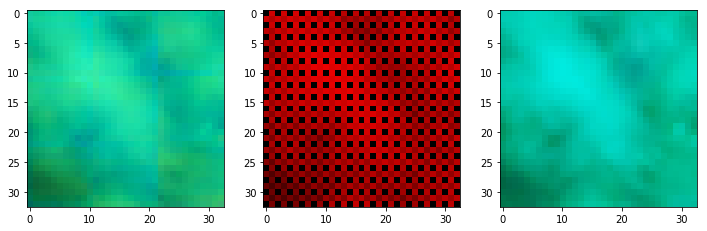

Epoch [83/250], Step [0/782], Loss: 0.02969074808061123
Epoch [83/250], Step [50/782], Loss: 0.03128744289278984
Epoch [83/250], Step [100/782], Loss: 0.02697618305683136
Epoch [83/250], Step [150/782], Loss: 0.03170481324195862
Epoch [83/250], Step [200/782], Loss: 0.034165751188993454
Epoch [83/250], Step [250/782], Loss: 0.023359054699540138
Epoch [83/250], Step [300/782], Loss: 0.021769830957055092
Epoch [83/250], Step [350/782], Loss: 0.03535991907119751
Epoch [83/250], Step [400/782], Loss: 0.03017180599272251
Epoch [83/250], Step [450/782], Loss: 0.025693770498037338
Epoch [83/250], Step [500/782], Loss: 0.02629782073199749
Epoch [83/250], Step [550/782], Loss: 0.02052709273993969
Epoch [83/250], Step [600/782], Loss: 0.02666599676012993
Epoch [83/250], Step [650/782], Loss: 0.03468216210603714
Epoch [83/250], Step [700/782], Loss: 0.03724154084920883
Epoch [83/250], Step [750/782], Loss: 0.030650120228528976

Finished Epoch 83, Loss --- mean: 0.028364477019347346, std 0.0064358

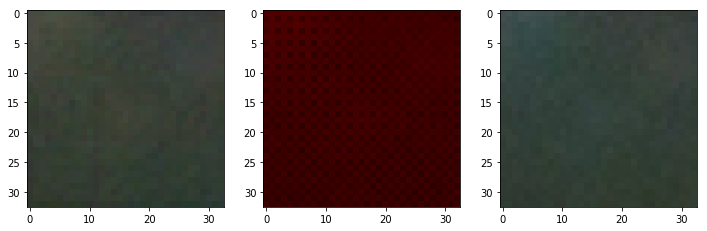

Epoch [84/250], Step [0/782], Loss: 0.03800796717405319
Epoch [84/250], Step [50/782], Loss: 0.028663301840424538
Epoch [84/250], Step [100/782], Loss: 0.029958268627524376
Epoch [84/250], Step [150/782], Loss: 0.032239530235528946
Epoch [84/250], Step [200/782], Loss: 0.028785161674022675
Epoch [84/250], Step [250/782], Loss: 0.02146007865667343
Epoch [84/250], Step [300/782], Loss: 0.030960876494646072
Epoch [84/250], Step [350/782], Loss: 0.02176312543451786
Epoch [84/250], Step [400/782], Loss: 0.04062589257955551
Epoch [84/250], Step [450/782], Loss: 0.0236342903226614
Epoch [84/250], Step [500/782], Loss: 0.024498464539647102
Epoch [84/250], Step [550/782], Loss: 0.03088570199906826
Epoch [84/250], Step [600/782], Loss: 0.034005507826805115
Epoch [84/250], Step [650/782], Loss: 0.030359257012605667
Epoch [84/250], Step [700/782], Loss: 0.017244333401322365
Epoch [84/250], Step [750/782], Loss: 0.039780471473932266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 84, Loss --- mean: 0.028292994781890336, std 0.0063700827713323045



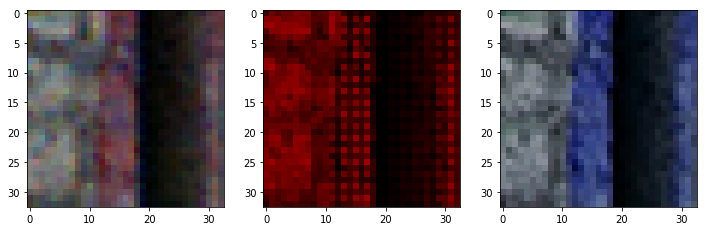

Epoch [85/250], Step [0/782], Loss: 0.02963319979608059
Epoch [85/250], Step [50/782], Loss: 0.016931967809796333
Epoch [85/250], Step [100/782], Loss: 0.027113327756524086
Epoch [85/250], Step [150/782], Loss: 0.035135600715875626
Epoch [85/250], Step [200/782], Loss: 0.031121792271733284
Epoch [85/250], Step [250/782], Loss: 0.033109087496995926
Epoch [85/250], Step [300/782], Loss: 0.035096198320388794
Epoch [85/250], Step [350/782], Loss: 0.02999437414109707
Epoch [85/250], Step [400/782], Loss: 0.023007573559880257
Epoch [85/250], Step [450/782], Loss: 0.02501869760453701
Epoch [85/250], Step [500/782], Loss: 0.027378592640161514
Epoch [85/250], Step [550/782], Loss: 0.019522719085216522
Epoch [85/250], Step [600/782], Loss: 0.03489912301301956
Epoch [85/250], Step [650/782], Loss: 0.03204302117228508
Epoch [85/250], Step [700/782], Loss: 0.026673449203372
Epoch [85/250], Step [750/782], Loss: 0.030441338196396828

Finished Epoch 85, Loss --- mean: 0.02799277569946197, std 0.00614

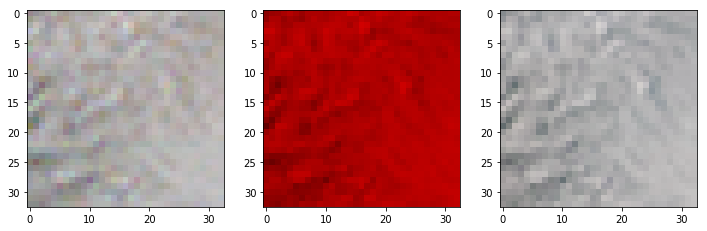

Epoch [86/250], Step [0/782], Loss: 0.024049168452620506
Epoch [86/250], Step [50/782], Loss: 0.025981355458498
Epoch [86/250], Step [100/782], Loss: 0.02388003095984459
Epoch [86/250], Step [150/782], Loss: 0.0237246286123991
Epoch [86/250], Step [200/782], Loss: 0.02903735265135765
Epoch [86/250], Step [250/782], Loss: 0.028627917170524597
Epoch [86/250], Step [300/782], Loss: 0.024815883487462997
Epoch [86/250], Step [350/782], Loss: 0.027116868644952774
Epoch [86/250], Step [400/782], Loss: 0.024419115856289864
Epoch [86/250], Step [450/782], Loss: 0.03711993247270584
Epoch [86/250], Step [500/782], Loss: 0.04087148606777191
Epoch [86/250], Step [550/782], Loss: 0.022322949022054672
Epoch [86/250], Step [600/782], Loss: 0.02187214232981205
Epoch [86/250], Step [650/782], Loss: 0.014866254292428493
Epoch [86/250], Step [700/782], Loss: 0.027385208755731583
Epoch [86/250], Step [750/782], Loss: 0.021542195230722427

Finished Epoch 86, Loss --- mean: 0.027849785196344793, std 0.006365

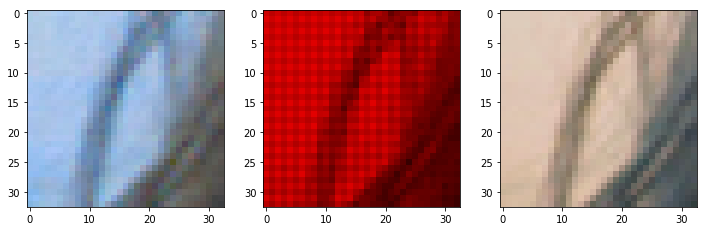

Epoch [87/250], Step [0/782], Loss: 0.032371848821640015
Epoch [87/250], Step [50/782], Loss: 0.032885633409023285
Epoch [87/250], Step [100/782], Loss: 0.03448808193206787
Epoch [87/250], Step [150/782], Loss: 0.03233101963996887
Epoch [87/250], Step [200/782], Loss: 0.029964754357933998
Epoch [87/250], Step [250/782], Loss: 0.02870408445596695
Epoch [87/250], Step [300/782], Loss: 0.034712307155132294
Epoch [87/250], Step [350/782], Loss: 0.023764126002788544
Epoch [87/250], Step [400/782], Loss: 0.03181862458586693
Epoch [87/250], Step [450/782], Loss: 0.029005391523241997
Epoch [87/250], Step [500/782], Loss: 0.02401277795433998
Epoch [87/250], Step [550/782], Loss: 0.02178758941590786
Epoch [87/250], Step [600/782], Loss: 0.03111286275088787
Epoch [87/250], Step [650/782], Loss: 0.025309698656201363
Epoch [87/250], Step [700/782], Loss: 0.022018199786543846
Epoch [87/250], Step [750/782], Loss: 0.03432704135775566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 87, Loss --- mean: 0.028065345827680645, std 0.006368045170298769



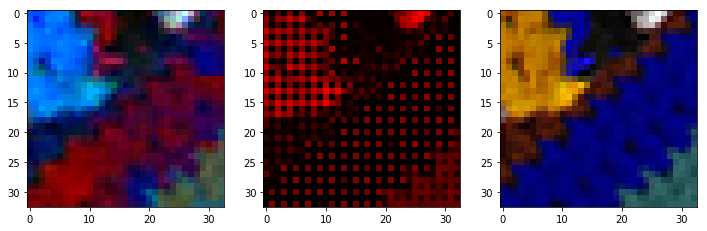

Epoch [88/250], Step [0/782], Loss: 0.022293733432888985
Epoch [88/250], Step [50/782], Loss: 0.02985016629099846
Epoch [88/250], Step [100/782], Loss: 0.03180438280105591
Epoch [88/250], Step [150/782], Loss: 0.02520737797021866
Epoch [88/250], Step [200/782], Loss: 0.021607019007205963
Epoch [88/250], Step [250/782], Loss: 0.035818859934806824
Epoch [88/250], Step [300/782], Loss: 0.034916434437036514
Epoch [88/250], Step [350/782], Loss: 0.024957789108157158
Epoch [88/250], Step [400/782], Loss: 0.019021393731236458
Epoch [88/250], Step [450/782], Loss: 0.025323452427983284
Epoch [88/250], Step [500/782], Loss: 0.030146514996886253
Epoch [88/250], Step [550/782], Loss: 0.024871010333299637
Epoch [88/250], Step [600/782], Loss: 0.028120918199419975
Epoch [88/250], Step [650/782], Loss: 0.032906100153923035
Epoch [88/250], Step [700/782], Loss: 0.029120588675141335
Epoch [88/250], Step [750/782], Loss: 0.020858975127339363


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 88, Loss --- mean: 0.027856966861716622, std 0.006428741780500524



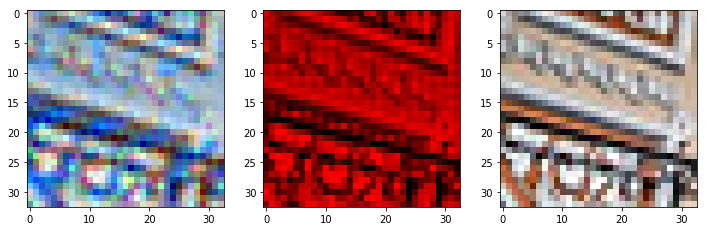

Epoch [89/250], Step [0/782], Loss: 0.03470678627490997
Epoch [89/250], Step [50/782], Loss: 0.03809734433889389
Epoch [89/250], Step [100/782], Loss: 0.02320937067270279
Epoch [89/250], Step [150/782], Loss: 0.021989628672599792
Epoch [89/250], Step [200/782], Loss: 0.034437086433172226
Epoch [89/250], Step [250/782], Loss: 0.031580664217472076
Epoch [89/250], Step [300/782], Loss: 0.02681187354028225
Epoch [89/250], Step [350/782], Loss: 0.023180916905403137
Epoch [89/250], Step [400/782], Loss: 0.02635062299668789
Epoch [89/250], Step [450/782], Loss: 0.019959066063165665
Epoch [89/250], Step [500/782], Loss: 0.021393658593297005
Epoch [89/250], Step [550/782], Loss: 0.026133127510547638
Epoch [89/250], Step [600/782], Loss: 0.03006337583065033
Epoch [89/250], Step [650/782], Loss: 0.026669219136238098
Epoch [89/250], Step [700/782], Loss: 0.025693904608488083
Epoch [89/250], Step [750/782], Loss: 0.02102338895201683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 89, Loss --- mean: 0.02778565230519723, std 0.006126123750601812



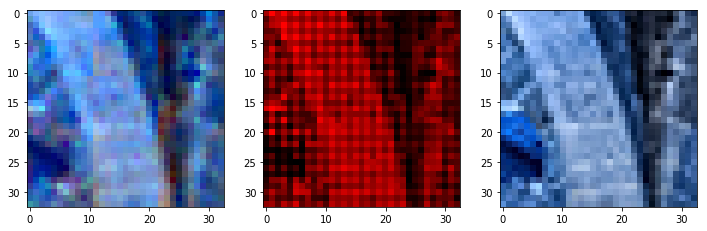

Epoch [90/250], Step [0/782], Loss: 0.023403236642479897
Epoch [90/250], Step [50/782], Loss: 0.0322536900639534
Epoch [90/250], Step [100/782], Loss: 0.03363307937979698
Epoch [90/250], Step [150/782], Loss: 0.023641595616936684
Epoch [90/250], Step [200/782], Loss: 0.03220224380493164
Epoch [90/250], Step [250/782], Loss: 0.031089337542653084
Epoch [90/250], Step [300/782], Loss: 0.026688285171985626
Epoch [90/250], Step [350/782], Loss: 0.027618659660220146
Epoch [90/250], Step [400/782], Loss: 0.02129531279206276
Epoch [90/250], Step [450/782], Loss: 0.024935491383075714
Epoch [90/250], Step [500/782], Loss: 0.033155929297208786
Epoch [90/250], Step [550/782], Loss: 0.023857934400439262
Epoch [90/250], Step [600/782], Loss: 0.0282179843634367
Epoch [90/250], Step [650/782], Loss: 0.01892326958477497
Epoch [90/250], Step [700/782], Loss: 0.020590711385011673
Epoch [90/250], Step [750/782], Loss: 0.03473621606826782

Finished Epoch 90, Loss --- mean: 0.027633079857615483, std 0.00610

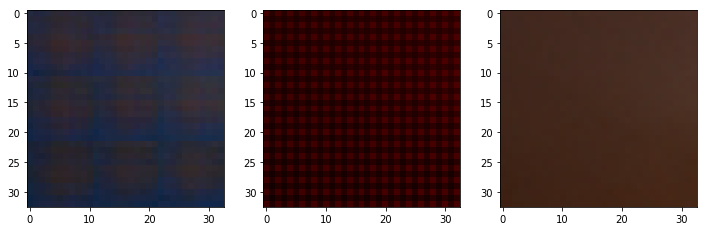

Epoch [91/250], Step [0/782], Loss: 0.02558651939034462
Epoch [91/250], Step [50/782], Loss: 0.026066776365041733
Epoch [91/250], Step [100/782], Loss: 0.03168468177318573
Epoch [91/250], Step [150/782], Loss: 0.022620107978582382
Epoch [91/250], Step [200/782], Loss: 0.023585407063364983
Epoch [91/250], Step [250/782], Loss: 0.024402592331171036
Epoch [91/250], Step [300/782], Loss: 0.02551100216805935
Epoch [91/250], Step [350/782], Loss: 0.01995665207505226
Epoch [91/250], Step [400/782], Loss: 0.033396944403648376
Epoch [91/250], Step [450/782], Loss: 0.030320962890982628
Epoch [91/250], Step [500/782], Loss: 0.04498916119337082
Epoch [91/250], Step [550/782], Loss: 0.02767758257687092
Epoch [91/250], Step [600/782], Loss: 0.030806804075837135
Epoch [91/250], Step [650/782], Loss: 0.021792467683553696
Epoch [91/250], Step [700/782], Loss: 0.015786999836564064
Epoch [91/250], Step [750/782], Loss: 0.018011055886745453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 91, Loss --- mean: 0.02757414500645893, std 0.00628163712702215



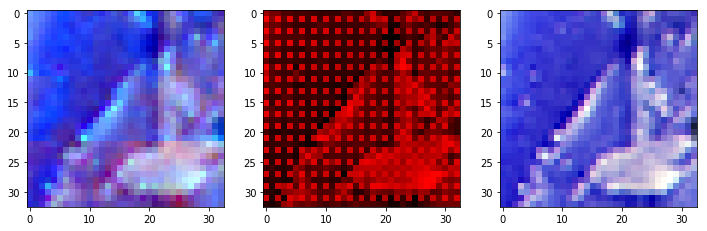

Epoch [92/250], Step [0/782], Loss: 0.03262745216488838
Epoch [92/250], Step [50/782], Loss: 0.023704465478658676
Epoch [92/250], Step [100/782], Loss: 0.025966698303818703
Epoch [92/250], Step [150/782], Loss: 0.025074174627661705
Epoch [92/250], Step [200/782], Loss: 0.03491808474063873
Epoch [92/250], Step [250/782], Loss: 0.024044713005423546
Epoch [92/250], Step [300/782], Loss: 0.04916704073548317
Epoch [92/250], Step [350/782], Loss: 0.024098273366689682
Epoch [92/250], Step [400/782], Loss: 0.02124406211078167
Epoch [92/250], Step [450/782], Loss: 0.022872822359204292
Epoch [92/250], Step [500/782], Loss: 0.0192175954580307
Epoch [92/250], Step [550/782], Loss: 0.023150820285081863
Epoch [92/250], Step [600/782], Loss: 0.03134631738066673
Epoch [92/250], Step [650/782], Loss: 0.028024043887853622
Epoch [92/250], Step [700/782], Loss: 0.02220032922923565
Epoch [92/250], Step [750/782], Loss: 0.03546281158924103

Finished Epoch 92, Loss --- mean: 0.02727215476167362, std 0.005957

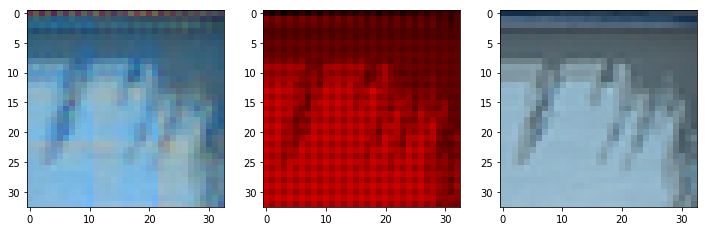

Epoch [93/250], Step [0/782], Loss: 0.040419820696115494
Epoch [93/250], Step [50/782], Loss: 0.027339430525898933
Epoch [93/250], Step [100/782], Loss: 0.022927986457943916
Epoch [93/250], Step [150/782], Loss: 0.018039317801594734
Epoch [93/250], Step [200/782], Loss: 0.02952522225677967
Epoch [93/250], Step [250/782], Loss: 0.027826810255646706
Epoch [93/250], Step [300/782], Loss: 0.03169363737106323
Epoch [93/250], Step [350/782], Loss: 0.021531881764531136
Epoch [93/250], Step [400/782], Loss: 0.02962397038936615
Epoch [93/250], Step [450/782], Loss: 0.019792551174759865
Epoch [93/250], Step [500/782], Loss: 0.040722962468862534
Epoch [93/250], Step [550/782], Loss: 0.030278749763965607
Epoch [93/250], Step [600/782], Loss: 0.03195248171687126
Epoch [93/250], Step [650/782], Loss: 0.03251638635993004
Epoch [93/250], Step [700/782], Loss: 0.02765927091240883
Epoch [93/250], Step [750/782], Loss: 0.032567378133535385


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 93, Loss --- mean: 0.02719851166648252, std 0.006032127683889059



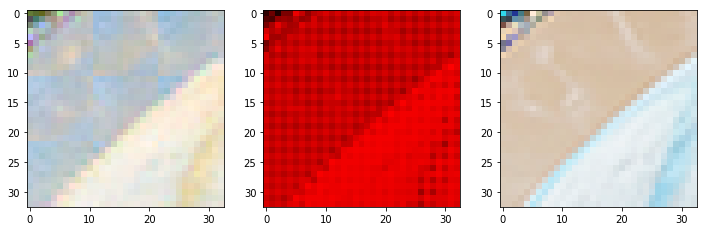

Epoch [94/250], Step [0/782], Loss: 0.02218896523118019
Epoch [94/250], Step [50/782], Loss: 0.02420777641236782
Epoch [94/250], Step [100/782], Loss: 0.024780485779047012
Epoch [94/250], Step [150/782], Loss: 0.03239980712532997
Epoch [94/250], Step [200/782], Loss: 0.028986141085624695
Epoch [94/250], Step [250/782], Loss: 0.02454768307507038
Epoch [94/250], Step [300/782], Loss: 0.02783275954425335
Epoch [94/250], Step [350/782], Loss: 0.023844121024012566
Epoch [94/250], Step [400/782], Loss: 0.028162922710180283
Epoch [94/250], Step [450/782], Loss: 0.020244013518095016
Epoch [94/250], Step [500/782], Loss: 0.027539825066924095
Epoch [94/250], Step [550/782], Loss: 0.023499613627791405
Epoch [94/250], Step [600/782], Loss: 0.020119892433285713
Epoch [94/250], Step [650/782], Loss: 0.02998812310397625
Epoch [94/250], Step [700/782], Loss: 0.02567867375910282
Epoch [94/250], Step [750/782], Loss: 0.03144056349992752


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 94, Loss --- mean: 0.027228115371826206, std 0.006071240873175426



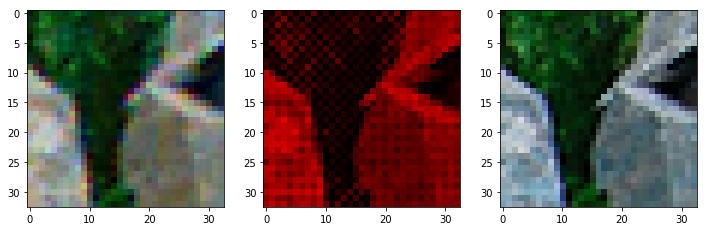

Epoch [95/250], Step [0/782], Loss: 0.024673333391547203
Epoch [95/250], Step [50/782], Loss: 0.022478284314274788
Epoch [95/250], Step [100/782], Loss: 0.020673496648669243
Epoch [95/250], Step [150/782], Loss: 0.027423927560448647
Epoch [95/250], Step [200/782], Loss: 0.015994345769286156
Epoch [95/250], Step [250/782], Loss: 0.03343287482857704
Epoch [95/250], Step [300/782], Loss: 0.03644504025578499
Epoch [95/250], Step [350/782], Loss: 0.020992513746023178
Epoch [95/250], Step [400/782], Loss: 0.023527950048446655
Epoch [95/250], Step [450/782], Loss: 0.026278270408511162
Epoch [95/250], Step [500/782], Loss: 0.029679441824555397
Epoch [95/250], Step [550/782], Loss: 0.03563421219587326
Epoch [95/250], Step [600/782], Loss: 0.019818639382719994
Epoch [95/250], Step [650/782], Loss: 0.028388699516654015
Epoch [95/250], Step [700/782], Loss: 0.02570192702114582
Epoch [95/250], Step [750/782], Loss: 0.02694292925298214


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 95, Loss --- mean: 0.02664466667920351, std 0.005895032832778022



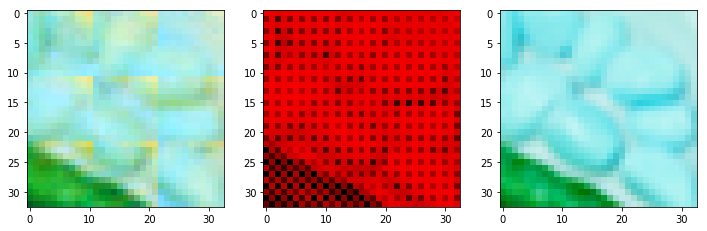

Epoch [96/250], Step [0/782], Loss: 0.02018807828426361
Epoch [96/250], Step [50/782], Loss: 0.02328411303460598
Epoch [96/250], Step [100/782], Loss: 0.04027959704399109
Epoch [96/250], Step [150/782], Loss: 0.02201426587998867
Epoch [96/250], Step [200/782], Loss: 0.021076520904898643
Epoch [96/250], Step [250/782], Loss: 0.026852352544665337
Epoch [96/250], Step [300/782], Loss: 0.03901970759034157
Epoch [96/250], Step [350/782], Loss: 0.034508705139160156
Epoch [96/250], Step [400/782], Loss: 0.02282380871474743
Epoch [96/250], Step [450/782], Loss: 0.02017970383167267
Epoch [96/250], Step [500/782], Loss: 0.018328066915273666
Epoch [96/250], Step [550/782], Loss: 0.03066438063979149
Epoch [96/250], Step [600/782], Loss: 0.021803725510835648
Epoch [96/250], Step [650/782], Loss: 0.03504157438874245
Epoch [96/250], Step [700/782], Loss: 0.024282170459628105
Epoch [96/250], Step [750/782], Loss: 0.027018601074814796


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 96, Loss --- mean: 0.02681367296387282, std 0.005934885478302044



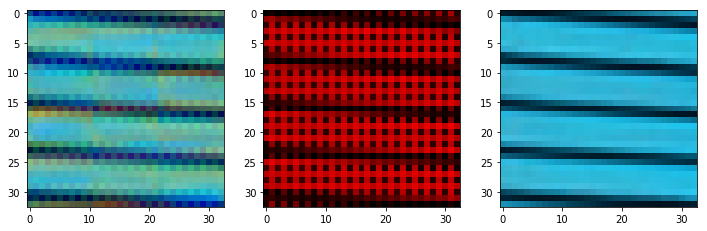

Epoch [97/250], Step [0/782], Loss: 0.026620225980877876
Epoch [97/250], Step [50/782], Loss: 0.033620789647102356
Epoch [97/250], Step [100/782], Loss: 0.02158895879983902
Epoch [97/250], Step [150/782], Loss: 0.03060801886022091
Epoch [97/250], Step [200/782], Loss: 0.02785082533955574
Epoch [97/250], Step [250/782], Loss: 0.023338941857218742
Epoch [97/250], Step [300/782], Loss: 0.01740657351911068
Epoch [97/250], Step [350/782], Loss: 0.027262413874268532
Epoch [97/250], Step [400/782], Loss: 0.023036684840917587
Epoch [97/250], Step [450/782], Loss: 0.02651410922408104
Epoch [97/250], Step [500/782], Loss: 0.02766706608235836
Epoch [97/250], Step [550/782], Loss: 0.029903866350650787
Epoch [97/250], Step [600/782], Loss: 0.032463438808918
Epoch [97/250], Step [650/782], Loss: 0.03537944331765175
Epoch [97/250], Step [700/782], Loss: 0.03476756438612938
Epoch [97/250], Step [750/782], Loss: 0.026232510805130005


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 97, Loss --- mean: 0.0269228836504833, std 0.006048929663555664



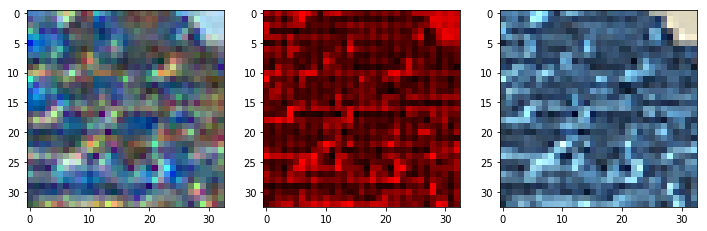

Epoch [98/250], Step [0/782], Loss: 0.027604348957538605
Epoch [98/250], Step [50/782], Loss: 0.018635280430316925
Epoch [98/250], Step [100/782], Loss: 0.03450021147727966
Epoch [98/250], Step [150/782], Loss: 0.0338294580578804
Epoch [98/250], Step [200/782], Loss: 0.022741476073861122
Epoch [98/250], Step [250/782], Loss: 0.01800660789012909
Epoch [98/250], Step [300/782], Loss: 0.021211454644799232
Epoch [98/250], Step [350/782], Loss: 0.021646499633789062
Epoch [98/250], Step [400/782], Loss: 0.03188661113381386
Epoch [98/250], Step [450/782], Loss: 0.021337568759918213
Epoch [98/250], Step [500/782], Loss: 0.03341946750879288
Epoch [98/250], Step [550/782], Loss: 0.031043289229273796
Epoch [98/250], Step [600/782], Loss: 0.02241165190935135
Epoch [98/250], Step [650/782], Loss: 0.023888729512691498
Epoch [98/250], Step [700/782], Loss: 0.03553662449121475
Epoch [98/250], Step [750/782], Loss: 0.029697012156248093


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 98, Loss --- mean: 0.026722085151268775, std 0.006081181489951962



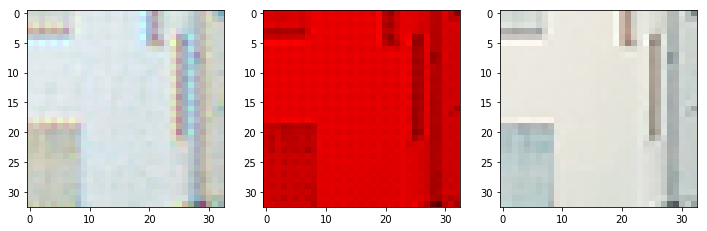

Epoch [99/250], Step [0/782], Loss: 0.019768238067626953
Epoch [99/250], Step [50/782], Loss: 0.03397829085588455
Epoch [99/250], Step [100/782], Loss: 0.023960324004292488
Epoch [99/250], Step [150/782], Loss: 0.02466600388288498
Epoch [99/250], Step [200/782], Loss: 0.026023557409644127
Epoch [99/250], Step [250/782], Loss: 0.032100096344947815
Epoch [99/250], Step [300/782], Loss: 0.026439925655722618
Epoch [99/250], Step [350/782], Loss: 0.022202225401997566
Epoch [99/250], Step [400/782], Loss: 0.026288120076060295
Epoch [99/250], Step [450/782], Loss: 0.02469019405543804
Epoch [99/250], Step [500/782], Loss: 0.03292332589626312
Epoch [99/250], Step [550/782], Loss: 0.03144614398479462
Epoch [99/250], Step [600/782], Loss: 0.028187330812215805
Epoch [99/250], Step [650/782], Loss: 0.025565745308995247
Epoch [99/250], Step [700/782], Loss: 0.02653920091688633
Epoch [99/250], Step [750/782], Loss: 0.018226364627480507

Finished Epoch 99, Loss --- mean: 0.026268659594237728, std 0.00

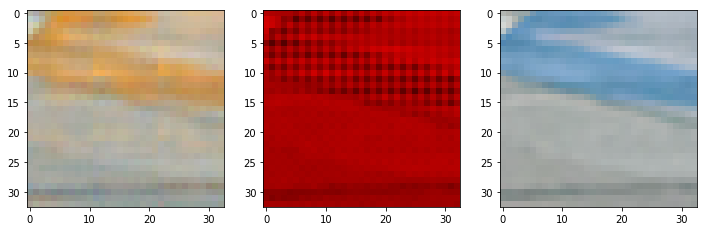

Epoch [100/250], Step [0/782], Loss: 0.03146728500723839
Epoch [100/250], Step [50/782], Loss: 0.027299826964735985
Epoch [100/250], Step [100/782], Loss: 0.030073659494519234
Epoch [100/250], Step [150/782], Loss: 0.025969604030251503
Epoch [100/250], Step [200/782], Loss: 0.022334272041916847
Epoch [100/250], Step [250/782], Loss: 0.032950811088085175
Epoch [100/250], Step [300/782], Loss: 0.023915525525808334
Epoch [100/250], Step [350/782], Loss: 0.02816728875041008
Epoch [100/250], Step [400/782], Loss: 0.029223423451185226
Epoch [100/250], Step [450/782], Loss: 0.024367010220885277
Epoch [100/250], Step [500/782], Loss: 0.025876477360725403
Epoch [100/250], Step [550/782], Loss: 0.02711181342601776
Epoch [100/250], Step [600/782], Loss: 0.021300042048096657
Epoch [100/250], Step [650/782], Loss: 0.042773641645908356
Epoch [100/250], Step [700/782], Loss: 0.03267938271164894
Epoch [100/250], Step [750/782], Loss: 0.019803790375590324

Finished Epoch 100, Loss --- mean: 0.026524363

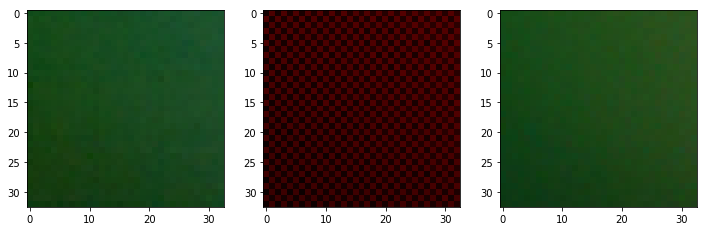

Epoch [101/250], Step [0/782], Loss: 0.021204620599746704
Epoch [101/250], Step [50/782], Loss: 0.027703024446964264
Epoch [101/250], Step [100/782], Loss: 0.022165294736623764
Epoch [101/250], Step [150/782], Loss: 0.021807311102747917
Epoch [101/250], Step [200/782], Loss: 0.024938998743891716
Epoch [101/250], Step [250/782], Loss: 0.0362408421933651
Epoch [101/250], Step [300/782], Loss: 0.03177228569984436
Epoch [101/250], Step [350/782], Loss: 0.021815123036503792
Epoch [101/250], Step [400/782], Loss: 0.01859717257320881
Epoch [101/250], Step [450/782], Loss: 0.0333743542432785
Epoch [101/250], Step [500/782], Loss: 0.026482293382287025
Epoch [101/250], Step [550/782], Loss: 0.020356226712465286
Epoch [101/250], Step [600/782], Loss: 0.028020182624459267
Epoch [101/250], Step [650/782], Loss: 0.02134154923260212
Epoch [101/250], Step [700/782], Loss: 0.02538297511637211
Epoch [101/250], Step [750/782], Loss: 0.024630501866340637

Finished Epoch 101, Loss --- mean: 0.0265009591565

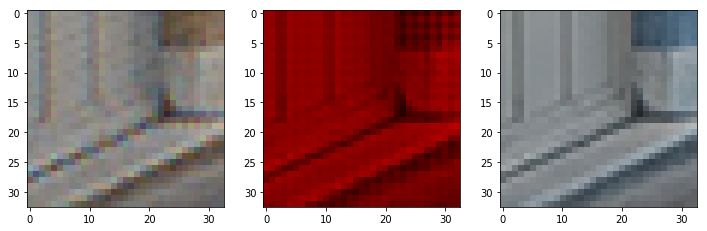

Epoch [102/250], Step [0/782], Loss: 0.030047591775655746
Epoch [102/250], Step [50/782], Loss: 0.027067286893725395
Epoch [102/250], Step [100/782], Loss: 0.03193994238972664
Epoch [102/250], Step [150/782], Loss: 0.01939886063337326
Epoch [102/250], Step [200/782], Loss: 0.02558939717710018
Epoch [102/250], Step [250/782], Loss: 0.026039816439151764
Epoch [102/250], Step [300/782], Loss: 0.02830575406551361
Epoch [102/250], Step [350/782], Loss: 0.024019798263907433
Epoch [102/250], Step [400/782], Loss: 0.02402624487876892
Epoch [102/250], Step [450/782], Loss: 0.024981429800391197
Epoch [102/250], Step [500/782], Loss: 0.02222948707640171
Epoch [102/250], Step [550/782], Loss: 0.04150650277733803
Epoch [102/250], Step [600/782], Loss: 0.024404024705290794
Epoch [102/250], Step [650/782], Loss: 0.01914721541106701
Epoch [102/250], Step [700/782], Loss: 0.03348520025610924
Epoch [102/250], Step [750/782], Loss: 0.01968357339501381

Finished Epoch 102, Loss --- mean: 0.026373257578286

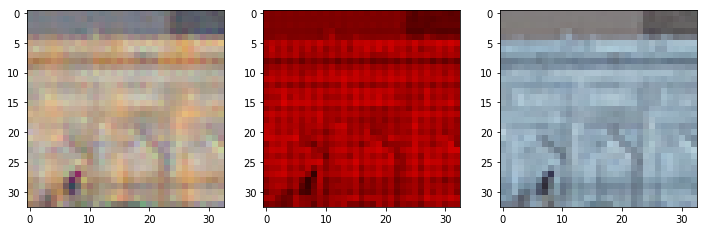

Epoch [103/250], Step [0/782], Loss: 0.023623790591955185
Epoch [103/250], Step [50/782], Loss: 0.024383284151554108
Epoch [103/250], Step [100/782], Loss: 0.02524174563586712
Epoch [103/250], Step [150/782], Loss: 0.021717721596360207
Epoch [103/250], Step [200/782], Loss: 0.01840808428823948
Epoch [103/250], Step [250/782], Loss: 0.03864044323563576
Epoch [103/250], Step [300/782], Loss: 0.026390232145786285
Epoch [103/250], Step [350/782], Loss: 0.02380007691681385
Epoch [103/250], Step [400/782], Loss: 0.033117350190877914
Epoch [103/250], Step [450/782], Loss: 0.02256746031343937
Epoch [103/250], Step [500/782], Loss: 0.0228543970733881
Epoch [103/250], Step [550/782], Loss: 0.03334653377532959
Epoch [103/250], Step [600/782], Loss: 0.02764131687581539
Epoch [103/250], Step [650/782], Loss: 0.03408537060022354
Epoch [103/250], Step [700/782], Loss: 0.025189658626914024
Epoch [103/250], Step [750/782], Loss: 0.02292575314640999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 103, Loss --- mean: 0.026011219810303826, std 0.005585374399769693



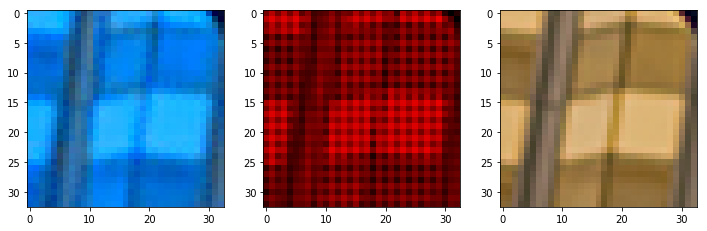

Epoch [104/250], Step [0/782], Loss: 0.031301598995923996
Epoch [104/250], Step [50/782], Loss: 0.03180485963821411
Epoch [104/250], Step [100/782], Loss: 0.030161231756210327
Epoch [104/250], Step [150/782], Loss: 0.028942693024873734
Epoch [104/250], Step [200/782], Loss: 0.025006843730807304
Epoch [104/250], Step [250/782], Loss: 0.02016284316778183
Epoch [104/250], Step [300/782], Loss: 0.0256041307002306
Epoch [104/250], Step [350/782], Loss: 0.022778673097491264
Epoch [104/250], Step [400/782], Loss: 0.023867692798376083
Epoch [104/250], Step [450/782], Loss: 0.030420077964663506
Epoch [104/250], Step [500/782], Loss: 0.026491740718483925
Epoch [104/250], Step [550/782], Loss: 0.0255613774061203
Epoch [104/250], Step [600/782], Loss: 0.030186191201210022
Epoch [104/250], Step [650/782], Loss: 0.030064275488257408
Epoch [104/250], Step [700/782], Loss: 0.02184252440929413
Epoch [104/250], Step [750/782], Loss: 0.022488834336400032

Finished Epoch 104, Loss --- mean: 0.025926979400

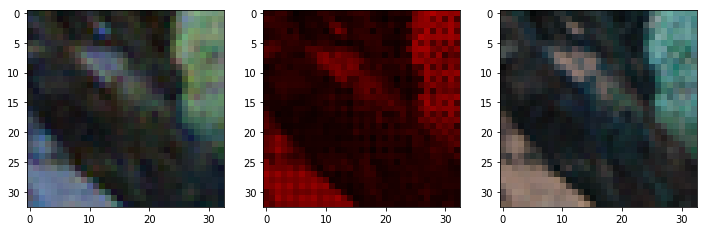

Epoch [105/250], Step [0/782], Loss: 0.029794516041874886
Epoch [105/250], Step [50/782], Loss: 0.02164607122540474
Epoch [105/250], Step [100/782], Loss: 0.022964876145124435
Epoch [105/250], Step [150/782], Loss: 0.020430367439985275
Epoch [105/250], Step [200/782], Loss: 0.027043692767620087
Epoch [105/250], Step [250/782], Loss: 0.018286261707544327
Epoch [105/250], Step [300/782], Loss: 0.032418202608823776
Epoch [105/250], Step [350/782], Loss: 0.01771790161728859
Epoch [105/250], Step [400/782], Loss: 0.02554214745759964
Epoch [105/250], Step [450/782], Loss: 0.02053956128656864
Epoch [105/250], Step [500/782], Loss: 0.030954349786043167
Epoch [105/250], Step [550/782], Loss: 0.031294915825128555
Epoch [105/250], Step [600/782], Loss: 0.030054990202188492
Epoch [105/250], Step [650/782], Loss: 0.025008756667375565
Epoch [105/250], Step [700/782], Loss: 0.027222713455557823
Epoch [105/250], Step [750/782], Loss: 0.023875627666711807


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 105, Loss --- mean: 0.02573444923895704, std 0.0057765723633881605



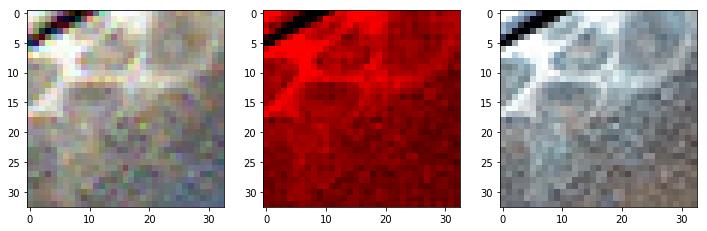

Epoch [106/250], Step [0/782], Loss: 0.02671627141535282
Epoch [106/250], Step [50/782], Loss: 0.023175250738859177
Epoch [106/250], Step [100/782], Loss: 0.0393436960875988
Epoch [106/250], Step [150/782], Loss: 0.02300960198044777
Epoch [106/250], Step [200/782], Loss: 0.03404146805405617
Epoch [106/250], Step [250/782], Loss: 0.03208604454994202
Epoch [106/250], Step [300/782], Loss: 0.019361618906259537
Epoch [106/250], Step [350/782], Loss: 0.018288295716047287
Epoch [106/250], Step [400/782], Loss: 0.022203976288437843
Epoch [106/250], Step [450/782], Loss: 0.026999009773135185
Epoch [106/250], Step [500/782], Loss: 0.04706435650587082
Epoch [106/250], Step [550/782], Loss: 0.02219480276107788
Epoch [106/250], Step [600/782], Loss: 0.04647597298026085
Epoch [106/250], Step [650/782], Loss: 0.026806624606251717
Epoch [106/250], Step [700/782], Loss: 0.020309027284383774
Epoch [106/250], Step [750/782], Loss: 0.038712866604328156

Finished Epoch 106, Loss --- mean: 0.02575479306118

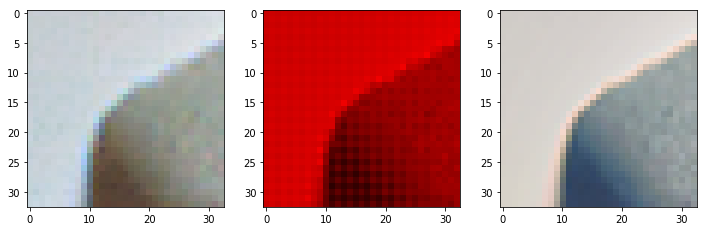

Epoch [107/250], Step [0/782], Loss: 0.03127874433994293
Epoch [107/250], Step [50/782], Loss: 0.02663971669971943
Epoch [107/250], Step [100/782], Loss: 0.026625802740454674
Epoch [107/250], Step [150/782], Loss: 0.024839110672473907
Epoch [107/250], Step [200/782], Loss: 0.018453067168593407
Epoch [107/250], Step [250/782], Loss: 0.020996075123548508
Epoch [107/250], Step [300/782], Loss: 0.026027925312519073
Epoch [107/250], Step [350/782], Loss: 0.025671983137726784
Epoch [107/250], Step [400/782], Loss: 0.032803263515233994
Epoch [107/250], Step [450/782], Loss: 0.027447834610939026
Epoch [107/250], Step [500/782], Loss: 0.0243455171585083
Epoch [107/250], Step [550/782], Loss: 0.029455190524458885
Epoch [107/250], Step [600/782], Loss: 0.02353440597653389
Epoch [107/250], Step [650/782], Loss: 0.03762422874569893
Epoch [107/250], Step [700/782], Loss: 0.02533438615500927
Epoch [107/250], Step [750/782], Loss: 0.017557362094521523

Finished Epoch 107, Loss --- mean: 0.025625952480

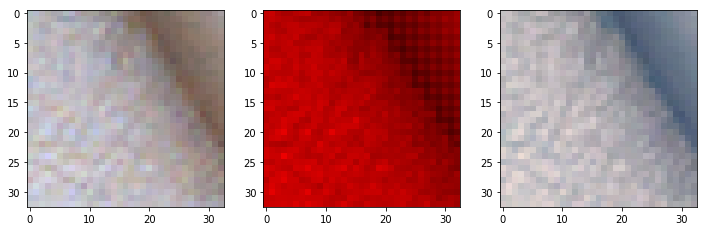

Epoch [108/250], Step [0/782], Loss: 0.0359581857919693
Epoch [108/250], Step [50/782], Loss: 0.020909002050757408
Epoch [108/250], Step [100/782], Loss: 0.036673933267593384
Epoch [108/250], Step [150/782], Loss: 0.018054215237498283
Epoch [108/250], Step [200/782], Loss: 0.02454996295273304
Epoch [108/250], Step [250/782], Loss: 0.027397412806749344
Epoch [108/250], Step [300/782], Loss: 0.023391593247652054
Epoch [108/250], Step [350/782], Loss: 0.016745593398809433
Epoch [108/250], Step [400/782], Loss: 0.02094282954931259
Epoch [108/250], Step [450/782], Loss: 0.02037523314356804
Epoch [108/250], Step [500/782], Loss: 0.026265878230333328
Epoch [108/250], Step [550/782], Loss: 0.0301093477755785
Epoch [108/250], Step [600/782], Loss: 0.02327202633023262
Epoch [108/250], Step [650/782], Loss: 0.047636065632104874
Epoch [108/250], Step [700/782], Loss: 0.052715763449668884
Epoch [108/250], Step [750/782], Loss: 0.02861720696091652


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 108, Loss --- mean: 0.025367746366630962, std 0.005711930617845319



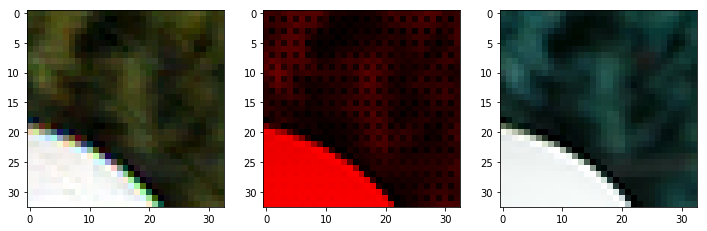

Epoch [109/250], Step [0/782], Loss: 0.02100396901369095
Epoch [109/250], Step [50/782], Loss: 0.03047320619225502
Epoch [109/250], Step [100/782], Loss: 0.025823337957262993
Epoch [109/250], Step [150/782], Loss: 0.03114679828286171
Epoch [109/250], Step [200/782], Loss: 0.020687788724899292
Epoch [109/250], Step [250/782], Loss: 0.026840815320611
Epoch [109/250], Step [300/782], Loss: 0.024670518934726715
Epoch [109/250], Step [350/782], Loss: 0.024407651275396347
Epoch [109/250], Step [400/782], Loss: 0.024616653099656105
Epoch [109/250], Step [450/782], Loss: 0.021349390968680382
Epoch [109/250], Step [500/782], Loss: 0.02446584217250347
Epoch [109/250], Step [550/782], Loss: 0.02398841828107834
Epoch [109/250], Step [600/782], Loss: 0.021521180868148804
Epoch [109/250], Step [650/782], Loss: 0.021686822175979614
Epoch [109/250], Step [700/782], Loss: 0.015123211778700352
Epoch [109/250], Step [750/782], Loss: 0.027206087484955788


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 109, Loss --- mean: 0.02541372324209041, std 0.005920149933912094



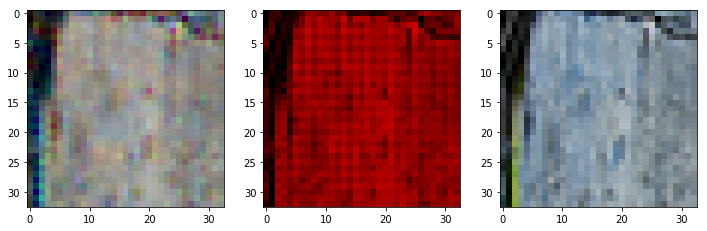

Epoch [110/250], Step [0/782], Loss: 0.032691601663827896
Epoch [110/250], Step [50/782], Loss: 0.016907325014472008
Epoch [110/250], Step [100/782], Loss: 0.025426993146538734
Epoch [110/250], Step [150/782], Loss: 0.024656016379594803
Epoch [110/250], Step [200/782], Loss: 0.029111992567777634
Epoch [110/250], Step [250/782], Loss: 0.024666788056492805
Epoch [110/250], Step [300/782], Loss: 0.02235465869307518
Epoch [110/250], Step [350/782], Loss: 0.02080380544066429
Epoch [110/250], Step [400/782], Loss: 0.020581429824233055
Epoch [110/250], Step [450/782], Loss: 0.040319476276636124
Epoch [110/250], Step [500/782], Loss: 0.03091404028236866
Epoch [110/250], Step [550/782], Loss: 0.02290305867791176
Epoch [110/250], Step [600/782], Loss: 0.02026819810271263
Epoch [110/250], Step [650/782], Loss: 0.016930438578128815
Epoch [110/250], Step [700/782], Loss: 0.03089211881160736
Epoch [110/250], Step [750/782], Loss: 0.03047867678105831


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 110, Loss --- mean: 0.025363537353103805, std 0.005822785364909613



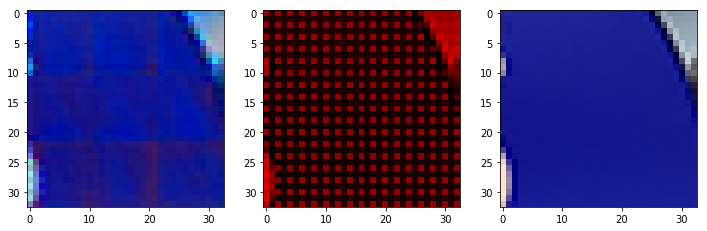

Epoch [111/250], Step [0/782], Loss: 0.023903347551822662
Epoch [111/250], Step [50/782], Loss: 0.019062481820583344
Epoch [111/250], Step [100/782], Loss: 0.028638159856200218
Epoch [111/250], Step [150/782], Loss: 0.021815458312630653
Epoch [111/250], Step [200/782], Loss: 0.024051744490861893
Epoch [111/250], Step [250/782], Loss: 0.02463540993630886
Epoch [111/250], Step [300/782], Loss: 0.02038593403995037
Epoch [111/250], Step [350/782], Loss: 0.029414325952529907
Epoch [111/250], Step [400/782], Loss: 0.02819713205099106
Epoch [111/250], Step [450/782], Loss: 0.022125346586108208
Epoch [111/250], Step [500/782], Loss: 0.025010738521814346
Epoch [111/250], Step [550/782], Loss: 0.021131597459316254
Epoch [111/250], Step [600/782], Loss: 0.024798627942800522
Epoch [111/250], Step [650/782], Loss: 0.022709239274263382
Epoch [111/250], Step [700/782], Loss: 0.02066825143992901
Epoch [111/250], Step [750/782], Loss: 0.033114004880189896


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 111, Loss --- mean: 0.02496587375507635, std 0.0057731807068953245



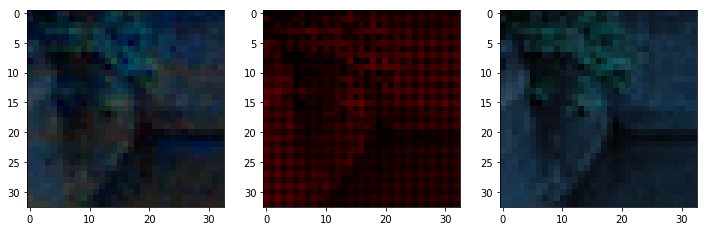

Epoch [112/250], Step [0/782], Loss: 0.020670248195528984
Epoch [112/250], Step [50/782], Loss: 0.029842641204595566
Epoch [112/250], Step [100/782], Loss: 0.023763103410601616
Epoch [112/250], Step [150/782], Loss: 0.021495020017027855
Epoch [112/250], Step [200/782], Loss: 0.019039791077375412
Epoch [112/250], Step [250/782], Loss: 0.026655428111553192
Epoch [112/250], Step [300/782], Loss: 0.014410855248570442
Epoch [112/250], Step [350/782], Loss: 0.02906028926372528
Epoch [112/250], Step [400/782], Loss: 0.02289879508316517
Epoch [112/250], Step [450/782], Loss: 0.018897611647844315
Epoch [112/250], Step [500/782], Loss: 0.024818086996674538
Epoch [112/250], Step [550/782], Loss: 0.020031532272696495
Epoch [112/250], Step [600/782], Loss: 0.019698619842529297
Epoch [112/250], Step [650/782], Loss: 0.027095673605799675
Epoch [112/250], Step [700/782], Loss: 0.019804803654551506
Epoch [112/250], Step [750/782], Loss: 0.024406081065535545


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 112, Loss --- mean: 0.025051837382109268, std 0.005714892921044567



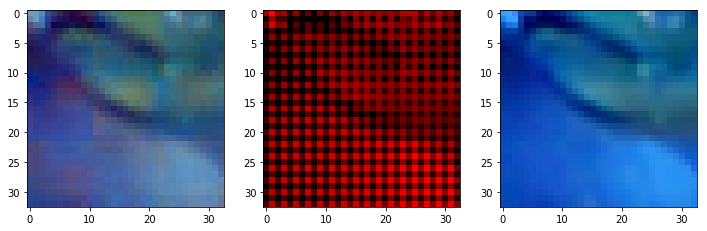

Epoch [113/250], Step [0/782], Loss: 0.026774978265166283
Epoch [113/250], Step [50/782], Loss: 0.02164667285978794
Epoch [113/250], Step [100/782], Loss: 0.01978951133787632
Epoch [113/250], Step [150/782], Loss: 0.022397305816411972
Epoch [113/250], Step [200/782], Loss: 0.024621762335300446
Epoch [113/250], Step [250/782], Loss: 0.0168074332177639
Epoch [113/250], Step [300/782], Loss: 0.020719759166240692
Epoch [113/250], Step [350/782], Loss: 0.029779551550745964
Epoch [113/250], Step [400/782], Loss: 0.024592697620391846
Epoch [113/250], Step [450/782], Loss: 0.028712274506688118
Epoch [113/250], Step [500/782], Loss: 0.036347709596157074
Epoch [113/250], Step [550/782], Loss: 0.029513593763113022
Epoch [113/250], Step [600/782], Loss: 0.03124895691871643
Epoch [113/250], Step [650/782], Loss: 0.022580616176128387
Epoch [113/250], Step [700/782], Loss: 0.019028866663575172
Epoch [113/250], Step [750/782], Loss: 0.02815314009785652


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 113, Loss --- mean: 0.024817206884932032, std 0.005681664051634528



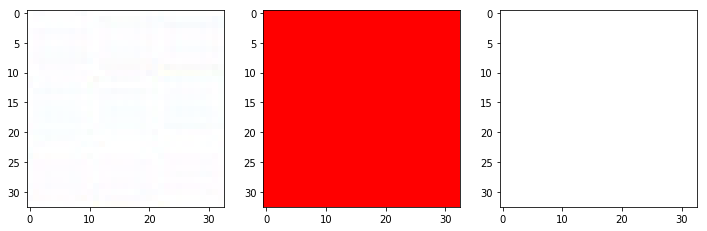

Epoch [114/250], Step [0/782], Loss: 0.019252218306064606
Epoch [114/250], Step [50/782], Loss: 0.024662351235747337
Epoch [114/250], Step [100/782], Loss: 0.019432079046964645
Epoch [114/250], Step [150/782], Loss: 0.022000137716531754
Epoch [114/250], Step [200/782], Loss: 0.021484477445483208
Epoch [114/250], Step [250/782], Loss: 0.0238888468593359
Epoch [114/250], Step [300/782], Loss: 0.018548881635069847
Epoch [114/250], Step [350/782], Loss: 0.028343623504042625
Epoch [114/250], Step [400/782], Loss: 0.019876092672348022
Epoch [114/250], Step [450/782], Loss: 0.02895566262304783
Epoch [114/250], Step [500/782], Loss: 0.02574683539569378
Epoch [114/250], Step [550/782], Loss: 0.02721339464187622
Epoch [114/250], Step [600/782], Loss: 0.018134599551558495
Epoch [114/250], Step [650/782], Loss: 0.030757781118154526
Epoch [114/250], Step [700/782], Loss: 0.03378849849104881
Epoch [114/250], Step [750/782], Loss: 0.02286764234304428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 114, Loss --- mean: 0.024844706568228618, std 0.005661978707168517



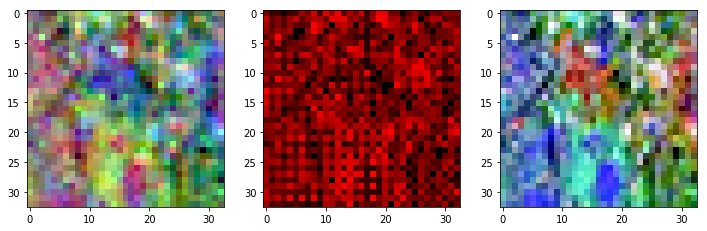

Epoch [115/250], Step [0/782], Loss: 0.02606029249727726
Epoch [115/250], Step [50/782], Loss: 0.020672043785452843
Epoch [115/250], Step [100/782], Loss: 0.037150222808122635
Epoch [115/250], Step [150/782], Loss: 0.02716708369553089
Epoch [115/250], Step [200/782], Loss: 0.03804125636816025
Epoch [115/250], Step [250/782], Loss: 0.02391352877020836
Epoch [115/250], Step [300/782], Loss: 0.021020105108618736
Epoch [115/250], Step [350/782], Loss: 0.026142532005906105
Epoch [115/250], Step [400/782], Loss: 0.025425441563129425
Epoch [115/250], Step [450/782], Loss: 0.030214428901672363
Epoch [115/250], Step [500/782], Loss: 0.02666478231549263
Epoch [115/250], Step [550/782], Loss: 0.0264980997890234
Epoch [115/250], Step [600/782], Loss: 0.02426750212907791
Epoch [115/250], Step [650/782], Loss: 0.03273113816976547
Epoch [115/250], Step [700/782], Loss: 0.026688938960433006
Epoch [115/250], Step [750/782], Loss: 0.024142205715179443


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 115, Loss --- mean: 0.0248521889031143, std 0.005533677747570145



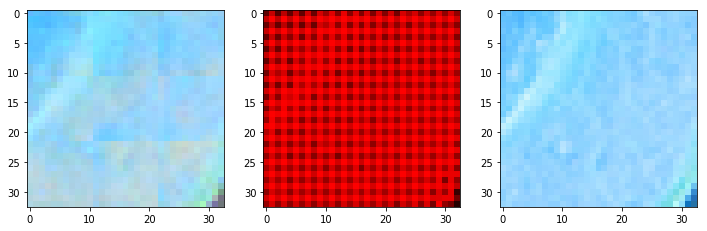

Epoch [116/250], Step [0/782], Loss: 0.02475416101515293
Epoch [116/250], Step [50/782], Loss: 0.016718633472919464
Epoch [116/250], Step [100/782], Loss: 0.027006641030311584
Epoch [116/250], Step [150/782], Loss: 0.024945449084043503
Epoch [116/250], Step [200/782], Loss: 0.021040409803390503
Epoch [116/250], Step [250/782], Loss: 0.020493272691965103
Epoch [116/250], Step [300/782], Loss: 0.034061726182699203
Epoch [116/250], Step [350/782], Loss: 0.03296723589301109
Epoch [116/250], Step [400/782], Loss: 0.024332843720912933
Epoch [116/250], Step [450/782], Loss: 0.01891346462070942
Epoch [116/250], Step [500/782], Loss: 0.019830826669931412
Epoch [116/250], Step [550/782], Loss: 0.022414855659008026
Epoch [116/250], Step [600/782], Loss: 0.019087476655840874
Epoch [116/250], Step [650/782], Loss: 0.026178373023867607
Epoch [116/250], Step [700/782], Loss: 0.027596773579716682
Epoch [116/250], Step [750/782], Loss: 0.023506442084908485


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 116, Loss --- mean: 0.024354748350456167, std 0.005580941339487712



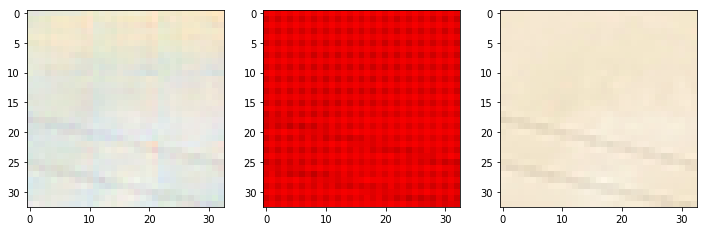

Epoch [117/250], Step [0/782], Loss: 0.022192196920514107
Epoch [117/250], Step [50/782], Loss: 0.02172396332025528
Epoch [117/250], Step [100/782], Loss: 0.036224912852048874
Epoch [117/250], Step [150/782], Loss: 0.014224117621779442
Epoch [117/250], Step [200/782], Loss: 0.017461486160755157
Epoch [117/250], Step [250/782], Loss: 0.024819986894726753
Epoch [117/250], Step [300/782], Loss: 0.01716069132089615
Epoch [117/250], Step [350/782], Loss: 0.017718013375997543
Epoch [117/250], Step [400/782], Loss: 0.028837401419878006
Epoch [117/250], Step [450/782], Loss: 0.015483465977013111
Epoch [117/250], Step [500/782], Loss: 0.030419420450925827
Epoch [117/250], Step [550/782], Loss: 0.02014871872961521
Epoch [117/250], Step [600/782], Loss: 0.02263551764190197
Epoch [117/250], Step [650/782], Loss: 0.02486865036189556
Epoch [117/250], Step [700/782], Loss: 0.017701031640172005
Epoch [117/250], Step [750/782], Loss: 0.0245827529579401


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 117, Loss --- mean: 0.024448767527128042, std 0.005585544955790924



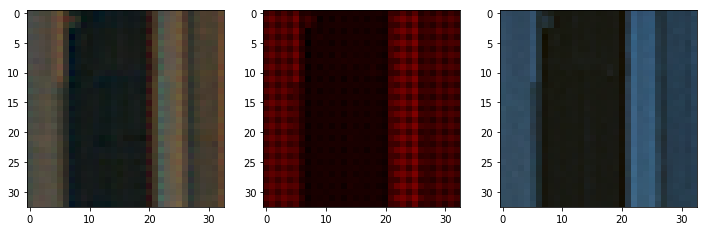

Epoch [118/250], Step [0/782], Loss: 0.020526424050331116
Epoch [118/250], Step [50/782], Loss: 0.02872375212609768
Epoch [118/250], Step [100/782], Loss: 0.016999410465359688
Epoch [118/250], Step [150/782], Loss: 0.02104794606566429
Epoch [118/250], Step [200/782], Loss: 0.02474351041018963
Epoch [118/250], Step [250/782], Loss: 0.0205097459256649
Epoch [118/250], Step [300/782], Loss: 0.037011321634054184
Epoch [118/250], Step [350/782], Loss: 0.022649668157100677
Epoch [118/250], Step [400/782], Loss: 0.021555772051215172
Epoch [118/250], Step [450/782], Loss: 0.025744711980223656
Epoch [118/250], Step [500/782], Loss: 0.018427232280373573
Epoch [118/250], Step [550/782], Loss: 0.02911314368247986
Epoch [118/250], Step [600/782], Loss: 0.03642567992210388
Epoch [118/250], Step [650/782], Loss: 0.019837060943245888
Epoch [118/250], Step [700/782], Loss: 0.025227628648281097
Epoch [118/250], Step [750/782], Loss: 0.02335025556385517


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 118, Loss --- mean: 0.02416525880598923, std 0.0062506917480185135



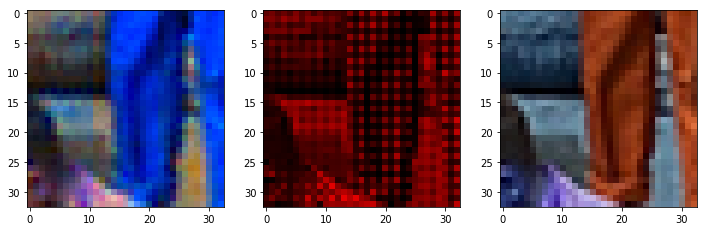

Epoch [119/250], Step [0/782], Loss: 0.033880565315485
Epoch [119/250], Step [50/782], Loss: 0.019324369728565216
Epoch [119/250], Step [100/782], Loss: 0.019669823348522186
Epoch [119/250], Step [150/782], Loss: 0.029624037444591522
Epoch [119/250], Step [200/782], Loss: 0.017122982069849968
Epoch [119/250], Step [250/782], Loss: 0.01959291659295559
Epoch [119/250], Step [300/782], Loss: 0.035351432859897614
Epoch [119/250], Step [350/782], Loss: 0.038443345576524734
Epoch [119/250], Step [400/782], Loss: 0.018325643613934517
Epoch [119/250], Step [450/782], Loss: 0.0167933888733387
Epoch [119/250], Step [500/782], Loss: 0.03308035060763359
Epoch [119/250], Step [550/782], Loss: 0.0168499443680048
Epoch [119/250], Step [600/782], Loss: 0.027721209451556206
Epoch [119/250], Step [650/782], Loss: 0.020060304552316666
Epoch [119/250], Step [700/782], Loss: 0.027043964713811874
Epoch [119/250], Step [750/782], Loss: 0.026165788993239403


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 119, Loss --- mean: 0.02431070673472398, std 0.0057075653943726365



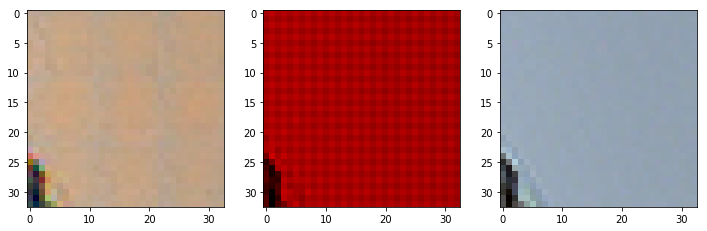

Epoch [120/250], Step [0/782], Loss: 0.03120778501033783
Epoch [120/250], Step [50/782], Loss: 0.02943490445613861
Epoch [120/250], Step [100/782], Loss: 0.022548573091626167
Epoch [120/250], Step [150/782], Loss: 0.016802724450826645
Epoch [120/250], Step [200/782], Loss: 0.02591080591082573
Epoch [120/250], Step [250/782], Loss: 0.02972937375307083
Epoch [120/250], Step [300/782], Loss: 0.030804770067334175
Epoch [120/250], Step [350/782], Loss: 0.024770721793174744
Epoch [120/250], Step [400/782], Loss: 0.014379246160387993
Epoch [120/250], Step [450/782], Loss: 0.03242082893848419
Epoch [120/250], Step [500/782], Loss: 0.03279890865087509
Epoch [120/250], Step [550/782], Loss: 0.024784360080957413
Epoch [120/250], Step [600/782], Loss: 0.0254292581230402
Epoch [120/250], Step [650/782], Loss: 0.03503263369202614
Epoch [120/250], Step [700/782], Loss: 0.02057574689388275
Epoch [120/250], Step [750/782], Loss: 0.022007444873452187


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 120, Loss --- mean: 0.024045239626656254, std 0.005615163244824861



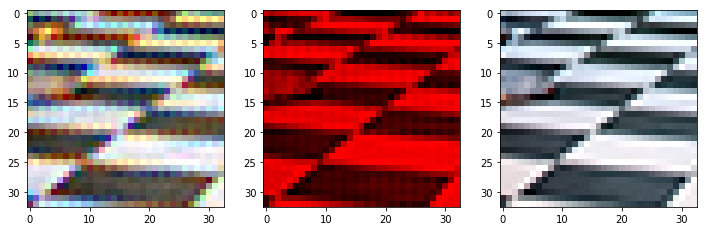

Epoch [121/250], Step [0/782], Loss: 0.016315102577209473
Epoch [121/250], Step [50/782], Loss: 0.019973408430814743
Epoch [121/250], Step [100/782], Loss: 0.014747546054422855
Epoch [121/250], Step [150/782], Loss: 0.01903720572590828
Epoch [121/250], Step [200/782], Loss: 0.02924232743680477
Epoch [121/250], Step [250/782], Loss: 0.02684735506772995
Epoch [121/250], Step [300/782], Loss: 0.0283559188246727
Epoch [121/250], Step [350/782], Loss: 0.02505849115550518
Epoch [121/250], Step [400/782], Loss: 0.017478374764323235
Epoch [121/250], Step [450/782], Loss: 0.02467557229101658
Epoch [121/250], Step [500/782], Loss: 0.02539864368736744
Epoch [121/250], Step [550/782], Loss: 0.021920733153820038
Epoch [121/250], Step [600/782], Loss: 0.018311822786927223
Epoch [121/250], Step [650/782], Loss: 0.018614307045936584
Epoch [121/250], Step [700/782], Loss: 0.02015295810997486
Epoch [121/250], Step [750/782], Loss: 0.017962224781513214


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 121, Loss --- mean: 0.02396634142117008, std 0.005534961773026601



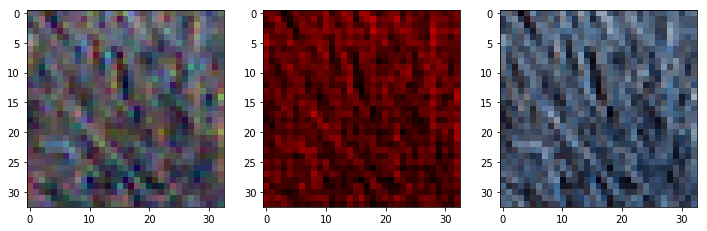

Epoch [122/250], Step [0/782], Loss: 0.025671107694506645
Epoch [122/250], Step [50/782], Loss: 0.02478918991982937
Epoch [122/250], Step [100/782], Loss: 0.02108318917453289
Epoch [122/250], Step [150/782], Loss: 0.019303949549794197
Epoch [122/250], Step [200/782], Loss: 0.01883680745959282
Epoch [122/250], Step [250/782], Loss: 0.020821144804358482
Epoch [122/250], Step [300/782], Loss: 0.023064829409122467
Epoch [122/250], Step [350/782], Loss: 0.023933174088597298
Epoch [122/250], Step [400/782], Loss: 0.026394309476017952
Epoch [122/250], Step [450/782], Loss: 0.02892996184527874
Epoch [122/250], Step [500/782], Loss: 0.024231478571891785
Epoch [122/250], Step [550/782], Loss: 0.023952800780534744
Epoch [122/250], Step [600/782], Loss: 0.036467503756284714
Epoch [122/250], Step [650/782], Loss: 0.02134888805449009
Epoch [122/250], Step [700/782], Loss: 0.01943759247660637
Epoch [122/250], Step [750/782], Loss: 0.019723042845726013

Finished Epoch 122, Loss --- mean: 0.02365998276

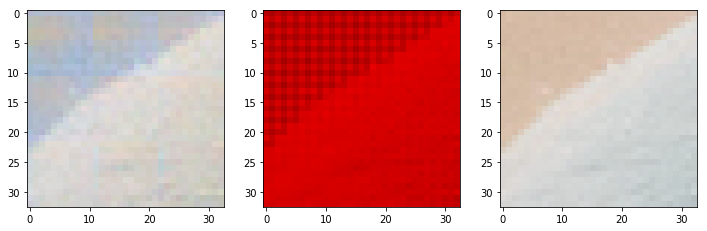

Epoch [123/250], Step [0/782], Loss: 0.02234429121017456
Epoch [123/250], Step [50/782], Loss: 0.022696012631058693
Epoch [123/250], Step [100/782], Loss: 0.0267073642462492
Epoch [123/250], Step [150/782], Loss: 0.035834185779094696
Epoch [123/250], Step [200/782], Loss: 0.021198395639657974
Epoch [123/250], Step [250/782], Loss: 0.024796372279524803
Epoch [123/250], Step [300/782], Loss: 0.026122141629457474
Epoch [123/250], Step [350/782], Loss: 0.015023449435830116
Epoch [123/250], Step [400/782], Loss: 0.022578710690140724
Epoch [123/250], Step [450/782], Loss: 0.039339568465948105
Epoch [123/250], Step [500/782], Loss: 0.027946002781391144
Epoch [123/250], Step [550/782], Loss: 0.03534265607595444
Epoch [123/250], Step [600/782], Loss: 0.02204936556518078
Epoch [123/250], Step [650/782], Loss: 0.02348528988659382
Epoch [123/250], Step [700/782], Loss: 0.024196039885282516
Epoch [123/250], Step [750/782], Loss: 0.03039432130753994


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 123, Loss --- mean: 0.02348296234474691, std 0.0053751198064598



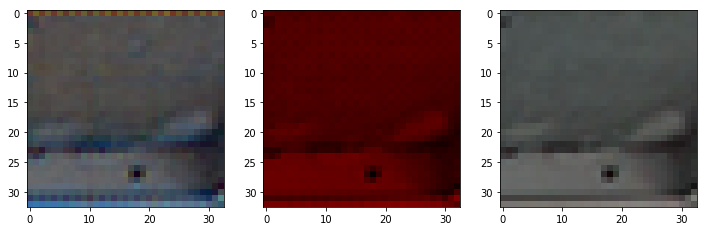

Epoch [124/250], Step [0/782], Loss: 0.022968783974647522
Epoch [124/250], Step [50/782], Loss: 0.03312414512038231
Epoch [124/250], Step [100/782], Loss: 0.022129934281110764
Epoch [124/250], Step [150/782], Loss: 0.015121419914066792
Epoch [124/250], Step [200/782], Loss: 0.023577598854899406
Epoch [124/250], Step [250/782], Loss: 0.03219757229089737
Epoch [124/250], Step [300/782], Loss: 0.024319805204868317
Epoch [124/250], Step [350/782], Loss: 0.018521638587117195
Epoch [124/250], Step [400/782], Loss: 0.0295744389295578
Epoch [124/250], Step [450/782], Loss: 0.02299131453037262
Epoch [124/250], Step [500/782], Loss: 0.0295286662876606
Epoch [124/250], Step [550/782], Loss: 0.024038808420300484
Epoch [124/250], Step [600/782], Loss: 0.018851136788725853
Epoch [124/250], Step [650/782], Loss: 0.01749539002776146
Epoch [124/250], Step [700/782], Loss: 0.02218635380268097
Epoch [124/250], Step [750/782], Loss: 0.0229856688529253


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 124, Loss --- mean: 0.023454611943534497, std 0.005152344704175686



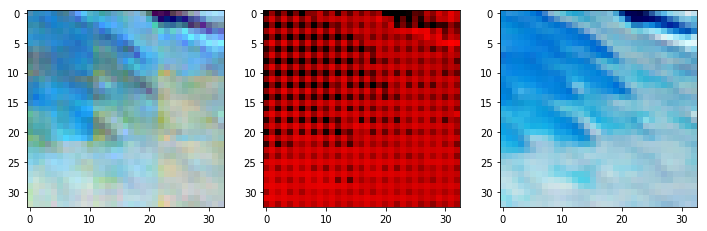

Epoch [125/250], Step [0/782], Loss: 0.022561591118574142
Epoch [125/250], Step [50/782], Loss: 0.02117200940847397
Epoch [125/250], Step [100/782], Loss: 0.02308080345392227
Epoch [125/250], Step [150/782], Loss: 0.026013769209384918
Epoch [125/250], Step [200/782], Loss: 0.028290634974837303
Epoch [125/250], Step [250/782], Loss: 0.020869124680757523
Epoch [125/250], Step [300/782], Loss: 0.021388797089457512
Epoch [125/250], Step [350/782], Loss: 0.027448400855064392
Epoch [125/250], Step [400/782], Loss: 0.032199740409851074
Epoch [125/250], Step [450/782], Loss: 0.018913304433226585
Epoch [125/250], Step [500/782], Loss: 0.020072415471076965
Epoch [125/250], Step [550/782], Loss: 0.015741286799311638
Epoch [125/250], Step [600/782], Loss: 0.024093838408589363
Epoch [125/250], Step [650/782], Loss: 0.01990850642323494
Epoch [125/250], Step [700/782], Loss: 0.01702420972287655
Epoch [125/250], Step [750/782], Loss: 0.01654689945280552


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 125, Loss --- mean: 0.02343574431284195, std 0.00534984279084118



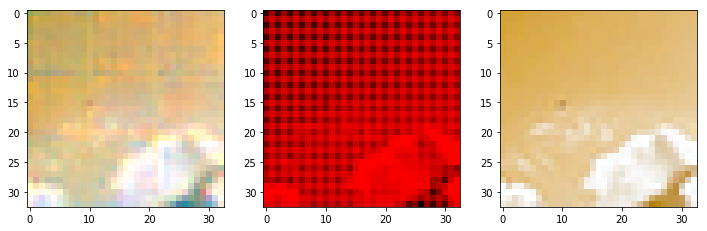

Epoch [126/250], Step [0/782], Loss: 0.026150673627853394
Epoch [126/250], Step [50/782], Loss: 0.023570172488689423
Epoch [126/250], Step [100/782], Loss: 0.016627054661512375
Epoch [126/250], Step [150/782], Loss: 0.022242482751607895
Epoch [126/250], Step [200/782], Loss: 0.03101915679872036
Epoch [126/250], Step [250/782], Loss: 0.021934235468506813
Epoch [126/250], Step [300/782], Loss: 0.02445285953581333
Epoch [126/250], Step [350/782], Loss: 0.0197459664195776
Epoch [126/250], Step [400/782], Loss: 0.026523008942604065
Epoch [126/250], Step [450/782], Loss: 0.02212469093501568
Epoch [126/250], Step [500/782], Loss: 0.01875033788383007
Epoch [126/250], Step [550/782], Loss: 0.02041412703692913
Epoch [126/250], Step [600/782], Loss: 0.03311026468873024
Epoch [126/250], Step [650/782], Loss: 0.031170742586255074
Epoch [126/250], Step [700/782], Loss: 0.018898222595453262
Epoch [126/250], Step [750/782], Loss: 0.023191723972558975


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 126, Loss --- mean: 0.023086153280437754, std 0.005385332595781757



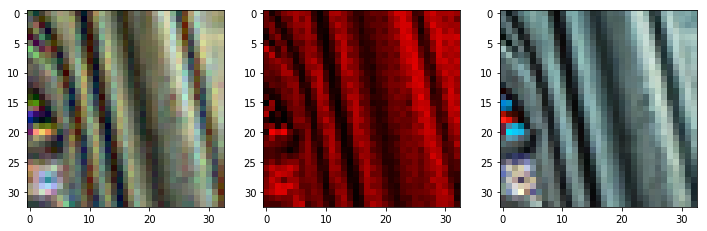

Epoch [127/250], Step [0/782], Loss: 0.017804110422730446
Epoch [127/250], Step [50/782], Loss: 0.020529823377728462
Epoch [127/250], Step [100/782], Loss: 0.02307603508234024
Epoch [127/250], Step [150/782], Loss: 0.023847078904509544
Epoch [127/250], Step [200/782], Loss: 0.021975701674818993
Epoch [127/250], Step [250/782], Loss: 0.03458937630057335
Epoch [127/250], Step [300/782], Loss: 0.016284167766571045
Epoch [127/250], Step [350/782], Loss: 0.049709901213645935
Epoch [127/250], Step [400/782], Loss: 0.018089180812239647
Epoch [127/250], Step [450/782], Loss: 0.02300095558166504
Epoch [127/250], Step [500/782], Loss: 0.017516065388917923
Epoch [127/250], Step [550/782], Loss: 0.026828845962882042
Epoch [127/250], Step [600/782], Loss: 0.03435339406132698
Epoch [127/250], Step [650/782], Loss: 0.029806675389409065
Epoch [127/250], Step [700/782], Loss: 0.025882814079523087
Epoch [127/250], Step [750/782], Loss: 0.017365097999572754


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 127, Loss --- mean: 0.023157557847735752, std 0.005237716483926154



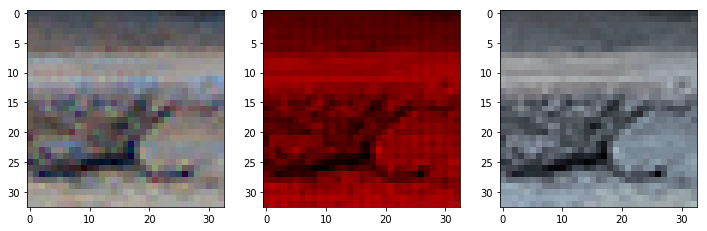

Epoch [128/250], Step [0/782], Loss: 0.02122524194419384
Epoch [128/250], Step [50/782], Loss: 0.018511509522795677
Epoch [128/250], Step [100/782], Loss: 0.022950507700443268
Epoch [128/250], Step [150/782], Loss: 0.02023990824818611
Epoch [128/250], Step [200/782], Loss: 0.022374043241143227
Epoch [128/250], Step [250/782], Loss: 0.02067454718053341
Epoch [128/250], Step [300/782], Loss: 0.019395096227526665
Epoch [128/250], Step [350/782], Loss: 0.019003737717866898
Epoch [128/250], Step [400/782], Loss: 0.01593177020549774
Epoch [128/250], Step [450/782], Loss: 0.022860655561089516
Epoch [128/250], Step [500/782], Loss: 0.01557235699146986
Epoch [128/250], Step [550/782], Loss: 0.02385846897959709
Epoch [128/250], Step [600/782], Loss: 0.029338274151086807
Epoch [128/250], Step [650/782], Loss: 0.023339953273534775
Epoch [128/250], Step [700/782], Loss: 0.03224603086709976
Epoch [128/250], Step [750/782], Loss: 0.02290661446750164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 128, Loss --- mean: 0.023394551599765067, std 0.005678120536886967



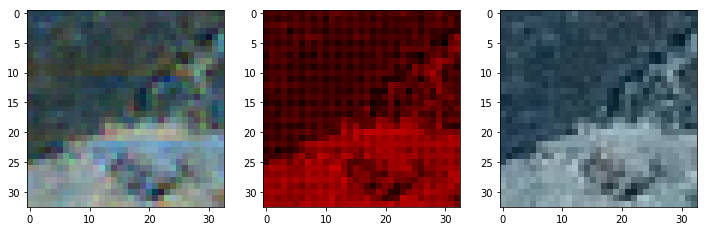

Epoch [129/250], Step [0/782], Loss: 0.031641703099012375
Epoch [129/250], Step [50/782], Loss: 0.021563798189163208
Epoch [129/250], Step [100/782], Loss: 0.02887193113565445
Epoch [129/250], Step [150/782], Loss: 0.0206205602735281
Epoch [129/250], Step [200/782], Loss: 0.017775220796465874
Epoch [129/250], Step [250/782], Loss: 0.016533920541405678
Epoch [129/250], Step [300/782], Loss: 0.02304677851498127
Epoch [129/250], Step [350/782], Loss: 0.026526767760515213
Epoch [129/250], Step [400/782], Loss: 0.02693016827106476
Epoch [129/250], Step [450/782], Loss: 0.028376946225762367
Epoch [129/250], Step [500/782], Loss: 0.024082191288471222
Epoch [129/250], Step [550/782], Loss: 0.015289094299077988
Epoch [129/250], Step [600/782], Loss: 0.020566629245877266
Epoch [129/250], Step [650/782], Loss: 0.021076573058962822
Epoch [129/250], Step [700/782], Loss: 0.02529767155647278
Epoch [129/250], Step [750/782], Loss: 0.023035895079374313


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 129, Loss --- mean: 0.023297950053763818, std 0.005415595755583095



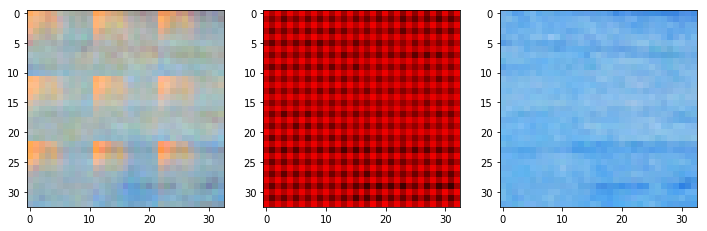

Epoch [130/250], Step [0/782], Loss: 0.0205940380692482
Epoch [130/250], Step [50/782], Loss: 0.022934844717383385
Epoch [130/250], Step [100/782], Loss: 0.030865490436553955


KeyboardInterrupt: 

In [23]:
total_step = len(data_loader)
loss_list = []
for epoch in range(start_epoch, n_epochs):
    epoch_loss = []
    for idx, (cfa, target, bilin) in enumerate(data_loader):
        cfa = cfa.float().to(device)
        target = target.float().to(device)
        bilin = bilin.float().to(device)
        target.cuda()
        outputs = model_vd(cfa)
        
        #print(outputs.shape, target.shape)
        loss = criterion(outputs + bilin, target)
        epoch_loss.append(loss.item())

        optimizer_vd.zero_grad()
        loss.backward()
        optimizer_vd.step()

        if idx % 50 == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Step [{idx}/{total_step}], Loss: {loss.item()}')
    epoch_stats = np.array(epoch_loss)
    print(f'\nFinished Epoch {epoch}, Loss --- mean: {epoch_stats.mean()}, std {epoch_stats.std()}\n')
    loss_list.append(epoch_stats.mean())
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,8))
    ax1.imshow(np.array(outputs[-1].tolist()).reshape((33, 33, 3)) + np.array(bilin[-1].tolist()).reshape((33, 33, 3)))
    ax2.imshow(np.array(cfa[-1].tolist()).reshape((33, 33, 3)), cmap='gray')
    ax3.imshow(np.array(target[-1].tolist()).reshape((33, 33, 3)))
    plt.savefig(f'epoch{epoch}.png')

    checkpoint(os.path.join(weights_path, f'dmcnn_vd_{epoch}.weight'), model_vd, optimizer_vd, loss, epoch=epoch)

    plt.show()

## Evaluation

We'll evaluate the models and compare it to some of the classical methods provided.

In [17]:
from colour_demosaicing import mosaicing_CFA_Bayer

In [18]:
lighthouse = cv2.cvtColor(cv2.imread('data/lighthouse.png'), cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'lighthouse.png')

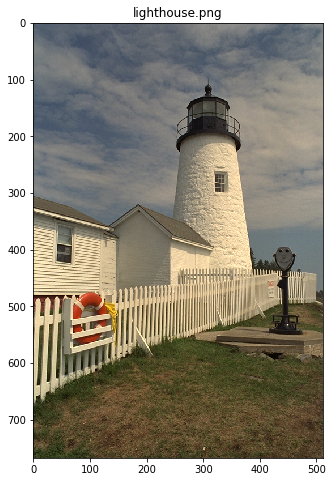

In [19]:
plt.figure(figsize=(10,8))
plt.imshow(lighthouse)
plt.title('lighthouse.png')

We'll turn the model to evaluation mode

In [20]:
model_vd.eval()

DMCNN_VD(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (layer1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [21]:
mosaic = mosaicing_CFA_Bayer(lighthouse)

Text(0.5, 1.0, 'lighthouse_mosaic.png')

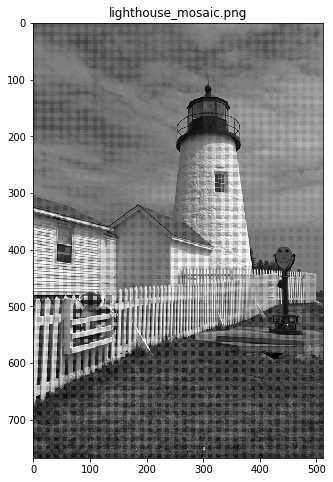

In [22]:
plt.figure(figsize=(10,8))
plt.imshow(mosaic, cmap='gray')
plt.title('lighthouse_mosaic.png')

In [24]:
from colour_demosaicing import demosaicing_CFA_Bayer_bilinear

Text(0.5, 1.0, 'lighthouse_bilin.png')

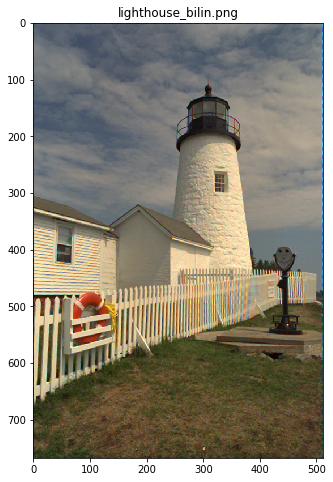

In [25]:
bilin = demosaicing_CFA_Bayer_bilinear(mosaic).astype(np.uint8)
plt.figure(figsize=(10,8))
plt.imshow(bilin, cmap='gray')
plt.title('lighthouse_bilin.png')

Splitting the image to the patches

In [26]:
image_patches = []
patches = []
bilin_patches = []
for i in range(33, mosaic.shape[0], 33):
    for j in range(33, mosaic.shape[1], 33):
        patch_mosaic = mosaic[i-33:i, j-33:j]
        patch = np.zeros((33, 33, 3), np.uint8)
        for idx in range(3):
            patch[:, :, idx] = patch_mosaic
        patches.append((i, j))
        image_patches.append(patch)
        bilin_patches.append(bilin[i-33:i, j-33:j, :])

Convert the patches to tensors and run them through the model

In [27]:
tensor_patches = torch.from_numpy(np.stack(image_patches).reshape((len(image_patches), 3, 33, 33)) / 255).float().to(device)

In [28]:
results = []
with torch.no_grad():
    for i in range(0, tensor_patches.shape[0], 128):
        input_patch = tensor_patches[i:i+128, :, :, :]
        outputs = model_vd(input_patch)
        results.append(outputs)

In [29]:
results = torch.cat(results)

In [30]:
demosaiced = np.zeros(lighthouse.shape, np.uint8)

for idx, patch in enumerate(patches):
    i, j = patch
    demosaic_patch = results[idx, :, :, :].reshape(33, 33, 3)
    demosaiced[i-33:i, j-33:j, :] = np.array(demosaic_patch.tolist()) * 255 + bilin_patches[idx]

Text(0.5, 1.0, 'lighthouse_mosaic.png')

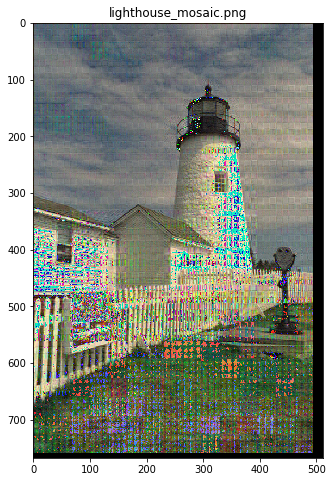

In [31]:
plt.figure(figsize=(10,8))
plt.imshow(demosaiced, cmap='gray')
plt.title('lighthouse_mosaic.png')